<a href="https://colab.research.google.com/github/danielgrgurevic/PortafolioDataScience/blob/main/SQM_forecast_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Proyecto predicciones valor de acciones de SQM con LSTM.


* Objetivo:

  - Predecer em un plazo de 6 meses los valores de las acciones para poder realizar una mejor gestión de cartera.

* Tareas:
 1- importar datos
 2- unir todo en un dataframe

  2.1 - comsiderar alineacion temporal

  2.2 - frecuencia de datos
  
  2.3 limpieza de datos


revisar colinealidad

# 1- Importación de Datos

## 1.1 Datos SQM

In [61]:
!pip install fredapi

In [62]:
import yfinance as yf
import pandas as pd

# Definición del ticker de SQM
sqm_ticker = 'SQM'

# Obtención de datos históricos de precios de SQM
sqm_data = yf.Ticker(sqm_ticker)
df_sqm = sqm_data.history(start="1994-01-01")
df_sqm = df_sqm.reset_index()

In [63]:
# Convertir la columna 'fecha' al formato de fecha 'año-mes-día'
df_sqm['Date'] = pd.to_datetime(df_sqm['Date'], format='%Y %m %d')
df_sqm['Date'] = df_sqm['Date'].dt.strftime('%Y %m %d')

In [64]:
df_sqm['Date'] = pd.to_datetime(df_sqm['Date'], format='%Y %m %d')

In [65]:
df_sqm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7648 entries, 0 to 7647
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          7648 non-null   datetime64[ns]
 1   Open          7648 non-null   float64       
 2   High          7648 non-null   float64       
 3   Low           7648 non-null   float64       
 4   Close         7648 non-null   float64       
 5   Volume        7648 non-null   int64         
 6   Dividends     7648 non-null   float64       
 7   Stock Splits  7648 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 478.1 KB


In [66]:
df_sqm

Date       Open       High        Low      Close   Volume  \
0    1994-01-03   1.146734   1.170624   1.137177   1.161068   960245   
1    1994-01-04   1.156289   1.156289   1.137177   1.146734   413881   
2    1994-01-05   1.146734   1.156289   1.118065   1.141955   610038   
3    1994-01-06   1.146733   1.146733   1.113286   1.113286   115024   
4    1994-01-07   1.113287   1.113287   1.089396   1.089396   218751   
...         ...        ...        ...        ...        ...      ...   
7643 2024-05-13  47.200001  48.209999  46.709999  48.099998   725900   
7644 2024-05-14  48.490002  49.680000  48.400002  49.509998  1106700   
7645 2024-05-15  50.009998  50.009998  47.919998  47.980000  1142900   
7646 2024-05-16  48.040001  48.490002  47.200001  47.970001   878900   
7647 2024-05-17  47.910000  48.665001  47.540100  47.799999   506389   

      Dividends  Stock Splits  
0           0.0           0.0  
1           0.0           0.0  
2           0.0           0.0  
3           0.0           0.0  
4           0.0           0.0  
...         ...           ...  
7643        0.0           0.0  
7644        0.0           0.0  
7645        0.0           0.0  
7646        0.0           0.0  
7647        0.0           0.0  

[7648 rows x 8 columns]

## 1.2 tasa del tesoro a 3 meses

In [67]:
# Definición del ticker para la tasa de fondos federales efectiva diaria
ticker = '^IRX'  # Este es el símbolo para la tasa del Tesoro a 3 meses, ajusta según la tasa que te interese

# Obtención de datos históricos de precios de este indicador
data = yf.Ticker(ticker)
df_tasa_diaria = data.history(period="max")  # Cambia 'max' por las fechas específicas si es necesario

# Filtrar datos desde una fecha específica, por ejemplo, desde 1994
df_tasa_diaria = df_tasa_diaria.loc['1994-01-01':]

In [68]:
# Sacar Date del índice y volverlo una columna
df_tasa_diaria.reset_index(inplace=True)
df_tasa_diaria['Date'] = df_tasa_diaria['Date'].dt.strftime('%Y %m %d')
df_tasa_diaria['Date'] = pd.to_datetime(df_tasa_diaria['Date'], format='%Y %m %d')

In [69]:
df_tasa_diaria.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7629 entries, 0 to 7628
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          7629 non-null   datetime64[ns]
 1   Open          7629 non-null   float64       
 2   High          7629 non-null   float64       
 3   Low           7629 non-null   float64       
 4   Close         7629 non-null   float64       
 5   Volume        7629 non-null   int64         
 6   Dividends     7629 non-null   float64       
 7   Stock Splits  7629 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 476.9 KB


In [70]:
df_tasa_diaria

Date  Open   High    Low  Close  Volume  Dividends  Stock Splits
0    1994-01-03  3.01  3.040  3.010  3.030       0        0.0           0.0
1    1994-01-04  3.09  3.090  3.070  3.080       0        0.0           0.0
2    1994-01-05  3.08  3.080  3.060  3.070       0        0.0           0.0
3    1994-01-06  3.06  3.060  3.040  3.050       0        0.0           0.0
4    1994-01-07  3.04  3.040  3.010  3.010       0        0.0           0.0
...         ...   ...    ...    ...    ...     ...        ...           ...
7624 2024-05-13  5.24  5.245  5.240  5.240       0        0.0           0.0
7625 2024-05-14  5.24  5.243  5.235  5.235       0        0.0           0.0
7626 2024-05-15  5.24  5.243  5.235  5.240       0        0.0           0.0
7627 2024-05-16  5.24  5.243  5.238  5.243       0        0.0           0.0
7628 2024-05-17  5.24  5.243  5.240  5.240       0        0.0           0.0

[7629 rows x 8 columns]

2. indicadores sectoriales, precios de commodities

In [71]:
import yfinance as yf

# Ejemplo para obtener el precio de commodities que están disponibles en forma de ETF o fondos negociables en bolsa
cobre_etf = yf.download("COPX", start="1994-01-01")  # ETF de cobre

# Ejemplo para descargar datos del ETF de oro
gold_etf = yf.download("GLD", start="2004-01-01")

# Ejemplo para descargar datos del ETF que sigue el precio del petróleo
oil_etf = yf.download("USO", start="2007-01-01")

#natural_gas_etf = yf.download("UNG", start="2007-01-01")  # UNG empezó en 2007

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [72]:
cobre_etf

Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2010-04-20  44.700001  44.700001  43.950001  44.040001  32.777866     1933
2010-04-21  43.799999  44.099998  43.230000  43.349998  32.264328     2900
2010-04-22  43.169998  43.169998  42.509998  43.110001  32.085690     3600
2010-04-23  42.959999  43.259998  42.750000  43.259998  32.197338     1100
2010-04-26  44.880001  44.880001  43.200001  43.919998  32.688557     3600
...               ...        ...        ...        ...        ...      ...
2024-05-13  48.480000  48.590000  48.060001  48.290001  48.290001   972100
2024-05-14  48.799999  50.080002  48.709999  49.709999  49.709999  2444200
2024-05-15  50.509998  50.529999  48.730000  49.680000  49.680000  3264900
2024-05-16  49.549999  49.630001  49.139999  49.360001  49.360001  1221700
2024-05-17  50.009998  51.529999  50.000000  51.525200  51.525200  2185279

[3545 rows x 6 columns]

In [73]:
gold_etf

Open        High         Low       Close   Adj Close  \
Date                                                                     
2004-11-18   44.430000   44.490002   44.070000   44.380001   44.380001   
2004-11-19   44.490002   44.919998   44.470001   44.779999   44.779999   
2004-11-22   44.750000   44.970001   44.740002   44.950001   44.950001   
2004-11-23   44.880001   44.919998   44.720001   44.750000   44.750000   
2004-11-24   44.930000   45.049999   44.790001   45.049999   45.049999   
...                ...         ...         ...         ...         ...   
2024-05-13  217.059998  217.309998  215.800003  216.259995  216.259995   
2024-05-14  217.309998  218.380005  216.979996  218.089996  218.089996   
2024-05-15  219.059998  221.190002  217.649994  220.889999  220.889999   
2024-05-16  220.139999  220.589996  219.410004  220.029999  220.029999   
2024-05-17  222.179993  223.850098  221.669998  223.664993  223.664993   

              Volume  
Date                  
2004-11-18   5992000  
2004-11-19  11655300  
2004-11-22  11996000  
2004-11-23   3169200  
2004-11-24   6105100  
...              ...  
2024-05-13   4896300  
2024-05-14   4662700  
2024-05-15   9297700  
2024-05-16   4295400  
2024-05-17   8650822  

[4907 rows x 6 columns]

In [74]:
oil_etf

Open        High         Low       Close   Adj Close  \
Date                                                                     
2007-01-03  411.359985  411.359985  393.040009  395.200012  395.200012   
2007-01-04  388.320007  391.200012  377.760010  379.119995  379.119995   
2007-01-05  379.200012  383.440002  375.119995  382.640015  382.640015   
2007-01-08  389.760010  392.399994  376.000000  379.920013  379.920013   
2007-01-09  370.160004  380.000000  369.440002  378.399994  378.399994   
...                ...         ...         ...         ...         ...   
2024-05-13   75.720001   76.430000   75.599998   76.129997   76.129997   
2024-05-14   75.300003   75.870003   74.839996   75.209999   75.209999   
2024-05-15   74.449997   75.879997   73.879997   75.879997   75.879997   
2024-05-16   76.639999   76.739998   75.930000   76.250000   76.250000   
2024-05-17   76.349998   77.114700   76.169998   77.040001   77.040001   

             Volume  
Date                 
2007-01-03   401713  
2007-01-04   557488  
2007-01-05   454100  
2007-01-08   493650  
2007-01-09   502463  
...             ...  
2024-05-13  3055300  
2024-05-14  2186600  
2024-05-15  3660000  
2024-05-16  3192500  
2024-05-17  1732492  

[4374 rows x 6 columns]

In [75]:
import yfinance as yf

# Obtener datos del índice Shanghai Composite
shanghai_comp = yf.Ticker("000001.SS")
data_shanghai = shanghai_comp.history(period="max")
data_shanghai

Open         High          Low        Close  \
Date                                                                            
1997-07-02 00:00:00+08:00  1255.909058  1261.571045  1147.331055  1199.061035   
1997-07-03 00:00:00+08:00  1194.676025  1194.676025  1149.939941  1150.623047   
1997-07-04 00:00:00+08:00  1138.921021  1163.249023  1124.776001  1159.342041   
1997-07-07 00:00:00+08:00  1161.707031  1163.447021  1085.572021  1096.818970   
1997-07-08 00:00:00+08:00  1092.798950  1115.432983  1066.043945  1109.666016   
...                                ...          ...          ...          ...   
2024-05-13 00:00:00+08:00  3139.475098  3157.365967  3126.169922  3148.020996   
2024-05-14 00:00:00+08:00  3148.849121  3155.806885  3137.608887  3145.773926   
2024-05-15 00:00:00+08:00  3141.251953  3142.972900  3117.928955  3119.902100   
2024-05-16 00:00:00+08:00  3127.184082  3137.877930  3116.163086  3122.400879   
2024-05-17 00:00:00+08:00  3121.712646  3154.026367  3116.784180  3154.026367   

                               Volume  Dividends  Stock Splits  
Date                                                            
1997-07-02 00:00:00+08:00           0        0.0           0.0  
1997-07-03 00:00:00+08:00           0        0.0           0.0  
1997-07-04 00:00:00+08:00           0        0.0           0.0  
1997-07-07 00:00:00+08:00           0        0.0           0.0  
1997-07-08 00:00:00+08:00           0        0.0           0.0  
...                               ...        ...           ...  
2024-05-13 00:00:00+08:00      397000        0.0           0.0  
2024-05-14 00:00:00+08:00      343500        0.0           0.0  
2024-05-15 00:00:00+08:00      321000        0.0           0.0  
2024-05-16 00:00:00+08:00      367400        0.0           0.0  
2024-05-17 00:00:00+08:00  4031786032        0.0           0.0  

[6509 rows x 7 columns]

## 1.3 Datos del Mercado Financiero (S&P 500, NASDAQ, VIX)

In [76]:
# Obtener datos del S&P 500
sp500 = yf.download("^GSPC", start="1994-01-01")

# Obtener datos del NASDAQ
nasdaq = yf.download("^IXIC", start="1994-01-01")

# Obtener datos del VIX
vix = yf.download("^VIX", start="1994-01-01")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [77]:
# Sacar Date del índice y volverlo una columna
sp500.reset_index(inplace=True)

In [78]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7648 entries, 0 to 7647
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       7648 non-null   datetime64[ns]
 1   Open       7648 non-null   float64       
 2   High       7648 non-null   float64       
 3   Low        7648 non-null   float64       
 4   Close      7648 non-null   float64       
 5   Adj Close  7648 non-null   float64       
 6   Volume     7648 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 418.4 KB


In [79]:
sp500

Date         Open         High          Low        Close  \
0    1994-01-03   466.510010   466.940002   464.359985   465.440002   
1    1994-01-04   465.440002   466.890015   464.440002   466.890015   
2    1994-01-05   466.890015   467.820007   465.920013   467.549988   
3    1994-01-06   467.549988   469.000000   467.019989   467.119995   
4    1994-01-07   467.089996   470.260010   467.029999   469.899994   
...         ...          ...          ...          ...          ...   
7643 2024-05-13  5233.080078  5237.259766  5211.160156  5221.419922   
7644 2024-05-14  5221.100098  5250.370117  5217.979980  5246.680176   
7645 2024-05-15  5263.259766  5311.759766  5263.259766  5308.149902   
7646 2024-05-16  5310.069824  5325.490234  5296.189941  5297.100098   
7647 2024-05-17  5303.100098  5305.450195  5283.589844  5301.979980   

        Adj Close      Volume  
0      465.440002   270140000  
1      466.890015   326600000  
2      467.549988   400030000  
3      467.119995   365960000  
4      469.899994   324920000  
...           ...         ...  
7643  5221.419922  4255710000  
7644  5246.680176  4763580000  
7645  5308.149902  4360810000  
7646  5297.100098  3817470000  
7647  5301.979980  1234255000  

[7648 rows x 7 columns]

In [80]:
# Sacar Date del índice y volverlo una columna
nasdaq.reset_index(inplace=True)

In [81]:
nasdaq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7648 entries, 0 to 7647
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       7648 non-null   datetime64[ns]
 1   Open       7648 non-null   float64       
 2   High       7648 non-null   float64       
 3   Low        7648 non-null   float64       
 4   Close      7648 non-null   float64       
 5   Adj Close  7648 non-null   float64       
 6   Volume     7648 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 418.4 KB


In [82]:
nasdaq

Date          Open          High           Low         Close  \
0    1994-01-03    774.109985    777.289978    768.409973    770.760010   
1    1994-01-04    771.429993    774.780029    771.020020    774.280029   
2    1994-01-05    775.229980    778.210022    773.690002    778.049988   
3    1994-01-06    780.359985    781.210022    778.250000    780.409973   
4    1994-01-07    779.289978    783.390015    778.200012    782.940002   
...         ...           ...           ...           ...           ...   
7643 2024-05-13  16400.310547  16407.050781  16334.860352  16388.240234   
7644 2024-05-14  16391.160156  16526.269531  16386.429688  16511.179688   
7645 2024-05-15  16601.140625  16749.740234  16544.089844  16742.390625   
7646 2024-05-16  16738.109375  16797.830078  16693.449219  16698.320312   
7647 2024-05-17  16708.500000  16726.410156  16613.835938  16684.130859   

         Adj Close       Volume  
0       770.760010    253020000  
1       774.280029    298600000  
2       778.049988    349880000  
3       780.409973    349210000  
4       782.940002    330060000  
...            ...          ...  
7643  16388.240234   4452750000  
7644  16511.179688   7270240000  
7645  16742.390625   8538990000  
7646  16698.320312  11932600000  
7647  16684.130859   8111892000  

[7648 rows x 7 columns]

In [83]:
# Sacar Date del índice y volverlo una columna
vix.reset_index(inplace=True)

In [84]:
vix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7648 entries, 0 to 7647
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       7648 non-null   datetime64[ns]
 1   Open       7648 non-null   float64       
 2   High       7648 non-null   float64       
 3   Low        7648 non-null   float64       
 4   Close      7648 non-null   float64       
 5   Adj Close  7648 non-null   float64       
 6   Volume     7648 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 418.4 KB


In [85]:
vix

Date   Open   High    Low  Close  Adj Close  Volume
0    1994-01-03  11.28  13.42  11.28  12.57      12.57       0
1    1994-01-04  12.87  12.87  11.81  11.91      11.91       0
2    1994-01-05  11.47  11.47  10.37  10.94      10.94       0
3    1994-01-06  11.47  11.74  10.34  11.27      11.27       0
4    1994-01-07  11.47  12.14  10.00  10.96      10.96       0
...         ...    ...    ...    ...    ...        ...     ...
7643 2024-05-13  13.26  13.66  13.25  13.60      13.60       0
7644 2024-05-14  13.71  14.03  13.27  13.42      13.42       0
7645 2024-05-15  13.73  13.94  12.38  12.45      12.45       0
7646 2024-05-16  12.52  12.67  12.33  12.42      12.42       0
7647 2024-05-17  12.28  12.48  11.93  11.94      11.94       0

[7648 rows x 7 columns]

## 1.4 Unión de Dataframes

In [86]:
df = pd.merge(df_sqm, df_tasa_diaria, on='Date', how = 'left', suffixes= ('_sqm', '_tasas'))

In [87]:
df = pd.merge(df, sp500, on='Date', how = 'left', suffixes = ('', '_sp500'))
df = pd.merge(df, nasdaq, on='Date', how = 'left', suffixes = ('_sp500', '_nasdaq'))
df = pd.merge(df, vix, on='Date', how = 'left', suffixes = ('', '_vix') )

In [88]:
df

Date   Open_sqm   High_sqm    Low_sqm  Close_sqm  Volume_sqm  \
0    1994-01-03   1.146734   1.170624   1.137177   1.161068      960245   
1    1994-01-04   1.156289   1.156289   1.137177   1.146734      413881   
2    1994-01-05   1.146734   1.156289   1.118065   1.141955      610038   
3    1994-01-06   1.146733   1.146733   1.113286   1.113286      115024   
4    1994-01-07   1.113287   1.113287   1.089396   1.089396      218751   
...         ...        ...        ...        ...        ...         ...   
7643 2024-05-13  47.200001  48.209999  46.709999  48.099998      725900   
7644 2024-05-14  48.490002  49.680000  48.400002  49.509998     1106700   
7645 2024-05-15  50.009998  50.009998  47.919998  47.980000     1142900   
7646 2024-05-16  48.040001  48.490002  47.200001  47.970001      878900   
7647 2024-05-17  47.910000  48.665001  47.540100  47.799999      506389   

      Dividends_sqm  Stock Splits_sqm  Open_tasas  High_tasas  Low_tasas  \
0               0.0               0.0        3.01       3.040      3.010   
1               0.0               0.0        3.09       3.090      3.070   
2               0.0               0.0        3.08       3.080      3.060   
3               0.0               0.0        3.06       3.060      3.040   
4               0.0               0.0        3.04       3.040      3.010   
...             ...               ...         ...         ...        ...   
7643            0.0               0.0        5.24       5.245      5.240   
7644            0.0               0.0        5.24       5.243      5.235   
7645            0.0               0.0        5.24       5.243      5.235   
7646            0.0               0.0        5.24       5.243      5.238   
7647            0.0               0.0        5.24       5.243      5.240   

      Close_tasas  Volume_tasas  Dividends_tasas  Stock Splits_tasas  \
0           3.030           0.0              0.0                 0.0   
1           3.080           0.0              0.0                 0.0   
2           3.070           0.0              0.0                 0.0   
3           3.050           0.0              0.0                 0.0   
4           3.010           0.0              0.0                 0.0   
...           ...           ...              ...                 ...   
7643        5.240           0.0              0.0                 0.0   
7644        5.235           0.0              0.0                 0.0   
7645        5.240           0.0              0.0                 0.0   
7646        5.243           0.0              0.0                 0.0   
7647        5.240           0.0              0.0                 0.0   

       Open_sp500   High_sp500    Low_sp500  Close_sp500  Adj Close_sp500  \
0      466.510010   466.940002   464.359985   465.440002       465.440002   
1      465.440002   466.890015   464.440002   466.890015       466.890015   
2      466.890015   467.820007   465.920013   467.549988       467.549988   
3      467.549988   469.000000   467.019989   467.119995       467.119995   
4      467.089996   470.260010   467.029999   469.899994       469.899994   
...           ...          ...          ...          ...              ...   
7643  5233.080078  5237.259766  5211.160156  5221.419922      5221.419922   
7644  5221.100098  5250.370117  5217.979980  5246.680176      5246.680176   
7645  5263.259766  5311.759766  5263.259766  5308.149902      5308.149902   
7646  5310.069824  5325.490234  5296.189941  5297.100098      5297.100098   
7647  5303.100098  5305.450195  5283.589844  5301.979980      5301.979980   

      Volume_sp500   Open_nasdaq   High_nasdaq    Low_nasdaq  Close_nasdaq  \
0        270140000    774.109985    777.289978    768.409973    770.760010   
1        326600000    771.429993    774.780029    771.020020    774.280029   
2        400030000    775.229980    778.210022    773.690002    778.049988   
3        365960000    780.359985    781.210022    778.250000    780.409973   
4        32492000

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7648 entries, 0 to 7647
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                7648 non-null   datetime64[ns]
 1   Open_sqm            7648 non-null   float64       
 2   High_sqm            7648 non-null   float64       
 3   Low_sqm             7648 non-null   float64       
 4   Close_sqm           7648 non-null   float64       
 5   Volume_sqm          7648 non-null   int64         
 6   Dividends_sqm       7648 non-null   float64       
 7   Stock Splits_sqm    7648 non-null   float64       
 8   Open_tasas          7629 non-null   float64       
 9   High_tasas          7629 non-null   float64       
 10  Low_tasas           7629 non-null   float64       
 11  Close_tasas         7629 non-null   float64       
 12  Volume_tasas        7629 non-null   float64       
 13  Dividends_tasas     7629 non-null   float64     

In [90]:
# Interpolar los valores faltantes
df.interpolate(inplace=True)

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7648 entries, 0 to 7647
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                7648 non-null   datetime64[ns]
 1   Open_sqm            7648 non-null   float64       
 2   High_sqm            7648 non-null   float64       
 3   Low_sqm             7648 non-null   float64       
 4   Close_sqm           7648 non-null   float64       
 5   Volume_sqm          7648 non-null   int64         
 6   Dividends_sqm       7648 non-null   float64       
 7   Stock Splits_sqm    7648 non-null   float64       
 8   Open_tasas          7648 non-null   float64       
 9   High_tasas          7648 non-null   float64       
 10  Low_tasas           7648 non-null   float64       
 11  Close_tasas         7648 non-null   float64       
 12  Volume_tasas        7648 non-null   float64       
 13  Dividends_tasas     7648 non-null   float64     

In [92]:
df

Date   Open_sqm   High_sqm    Low_sqm  Close_sqm  Volume_sqm  \
0    1994-01-03   1.146734   1.170624   1.137177   1.161068      960245   
1    1994-01-04   1.156289   1.156289   1.137177   1.146734      413881   
2    1994-01-05   1.146734   1.156289   1.118065   1.141955      610038   
3    1994-01-06   1.146733   1.146733   1.113286   1.113286      115024   
4    1994-01-07   1.113287   1.113287   1.089396   1.089396      218751   
...         ...        ...        ...        ...        ...         ...   
7643 2024-05-13  47.200001  48.209999  46.709999  48.099998      725900   
7644 2024-05-14  48.490002  49.680000  48.400002  49.509998     1106700   
7645 2024-05-15  50.009998  50.009998  47.919998  47.980000     1142900   
7646 2024-05-16  48.040001  48.490002  47.200001  47.970001      878900   
7647 2024-05-17  47.910000  48.665001  47.540100  47.799999      506389   

      Dividends_sqm  Stock Splits_sqm  Open_tasas  High_tasas  Low_tasas  \
0               0.0               0.0        3.01       3.040      3.010   
1               0.0               0.0        3.09       3.090      3.070   
2               0.0               0.0        3.08       3.080      3.060   
3               0.0               0.0        3.06       3.060      3.040   
4               0.0               0.0        3.04       3.040      3.010   
...             ...               ...         ...         ...        ...   
7643            0.0               0.0        5.24       5.245      5.240   
7644            0.0               0.0        5.24       5.243      5.235   
7645            0.0               0.0        5.24       5.243      5.235   
7646            0.0               0.0        5.24       5.243      5.238   
7647            0.0               0.0        5.24       5.243      5.240   

      Close_tasas  Volume_tasas  Dividends_tasas  Stock Splits_tasas  \
0           3.030           0.0              0.0                 0.0   
1           3.080           0.0              0.0                 0.0   
2           3.070           0.0              0.0                 0.0   
3           3.050           0.0              0.0                 0.0   
4           3.010           0.0              0.0                 0.0   
...           ...           ...              ...                 ...   
7643        5.240           0.0              0.0                 0.0   
7644        5.235           0.0              0.0                 0.0   
7645        5.240           0.0              0.0                 0.0   
7646        5.243           0.0              0.0                 0.0   
7647        5.240           0.0              0.0                 0.0   

       Open_sp500   High_sp500    Low_sp500  Close_sp500  Adj Close_sp500  \
0      466.510010   466.940002   464.359985   465.440002       465.440002   
1      465.440002   466.890015   464.440002   466.890015       466.890015   
2      466.890015   467.820007   465.920013   467.549988       467.549988   
3      467.549988   469.000000   467.019989   467.119995       467.119995   
4      467.089996   470.260010   467.029999   469.899994       469.899994   
...           ...          ...          ...          ...              ...   
7643  5233.080078  5237.259766  5211.160156  5221.419922      5221.419922   
7644  5221.100098  5250.370117  5217.979980  5246.680176      5246.680176   
7645  5263.259766  5311.759766  5263.259766  5308.149902      5308.149902   
7646  5310.069824  5325.490234  5296.189941  5297.100098      5297.100098   
7647  5303.100098  5305.450195  5283.589844  5301.979980      5301.979980   

      Volume_sp500   Open_nasdaq   High_nasdaq    Low_nasdaq  Close_nasdaq  \
0        270140000    774.109985    777.289978    768.409973    770.760010   
1        326600000    771.429993    774.780029    771.020020    774.280029   
2        400030000    775.229980    778.210022    773.690002    778.049988   
3        365960000    780.359985    781.210022    778.250000    780.409973   
4        32492000

# 2. Exploración y Análisis de Datos

In [93]:
df.describe()

Date     Open_sqm     High_sqm      Low_sqm  \
count                           7648  7648.000000  7648.000000  7648.000000   
mean   2009-03-08 12:38:35.899581696    17.812995    18.092613    17.508370   
min              1994-01-03 00:00:00     0.712273     0.727951     0.710033   
25%              2001-07-30 18:00:00     1.782571     1.797026     1.769409   
50%              2009-03-10 12:00:00    12.139123    12.410479    11.906338   
75%              2016-10-11 06:00:00    28.738258    29.127594    28.341932   
max              2024-05-17 00:00:00    99.394079   100.982290    97.248683   
std                              NaN    19.550704    19.895773    19.154298   

         Close_sqm    Volume_sqm  Dividends_sqm  Stock Splits_sqm  \
count  7648.000000  7.648000e+03    7648.000000       7648.000000   
mean     17.797223  6.655533e+05       0.004102          0.001442   
min       0.716752  0.000000e+00       0.000000          0.000000   
25%       1.785716  2.095080e+05       0.000000          0.000000   
50%      12.139732  4.744740e+05       0.000000          0.000000   
75%      28.664975  8.801648e+05       0.000000          0.000000   
max      99.062477  3.025645e+07       3.224000         10.000000   
std      19.517118  9.174527e+05       0.074740          0.114947   

        Open_tasas   High_tasas    Low_tasas  Close_tasas   Volume_tasas  \
count  7648.000000  7648.000000  7648.000000  7648.000000    7648.000000   
mean      2.336877     2.350823     2.319541     2.335027     917.965481   
min      -0.108000    -0.100000    -0.235000    -0.105000       0.000000   
25%       0.135000     0.140000     0.128000     0.135000       0.000000   
50%       1.710000     1.720000     1.690000     1.700000       0.000000   
75%       4.727750     4.750000     4.700000     4.720000       0.000000   
max       6.210000     6.230000     6.210000     6.220000  159700.000000   
std       2.114506     2.119891     2.108011     2.114196   11956.142729   

       Dividends_tasas  Stock Splits_tasas   Open_sp500   High_sp500  \
count           7648.0              7648.0  7648.000000  7648.000000   
mean               0.0                 0.0  1784.532856  1795.049881   
min                0.0                 0.0   439.140015   444.720001   
25%                0.0                 0.0  1089.885010  1097.017517   
50%                0.0                 0.0  1340.320007  1350.219971   
75%                0.0                 0.0  2171.725037  2178.467529   
max                0.0                 0.0  5310.069824  5325.490234   
std                0.0                 0.0  1118.842898  1124.404265   

         Low_sp500  Close_sp500  Adj Close_sp500  Volume_sp500   Open_nasdaq  \
count  7648.000000  7648.000000      7648.000000  7.648000e+03   7648.000000   
mean   1773.333141  1784.910485      1784.910485  2.777232e+09   4409.086928   
min     435.859985   438.920013       438.920013  1.499000e+07    694.159973   
25%    1079.962494  1089.814972      1089.814972  1.164900e+09   1878.825012   
50%    1330.670044  1340.555054      1340.555054  3.073655e+09   2596.354980   
75%    2164.199951  2172.607483      2172.607483  3.960990e+09   5254.240112   
max    5296.189941  5308.149902      5308.149902  1.145623e+10  16738.109375   
std    1112.993599  1119.050418      1119.050418  1.757021e+09   3921.432308   

        High_nasdaq    Low_nasdaq  Close_nasdaq  Adj Close_nasdaq  \
count   7648.000000   7648.000000   7648.000000       7648.000000   
mean    4440.104665   4374.070060   4409.034096       4409.034096   
min      699.780029    690.950012    693.789978        693.789978   
25%     1893.182465   1863.774994   1879.324982       1879.324982   
50%     2613.300049   2569.000000   2596.195068       2596.195068   
75%     5272.049927   5234.017456   5249.992432       5249.992432   
max    16797.830078  16693.449219  16742.390625      16742.390625   
std     3948.153753   3892.108217   3922.040266       3922.040266   

       Volume_nasdaq 

In [94]:
# Lista de columnas a eliminar
columnas_a_eliminar = ['Dividends_tasas', 'Stock Splits_tasas', 'Volume']

# Eliminar las columnas de la lista
df = df.drop(columns=columnas_a_eliminar)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7648 entries, 0 to 7647
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              7648 non-null   datetime64[ns]
 1   Open_sqm          7648 non-null   float64       
 2   High_sqm          7648 non-null   float64       
 3   Low_sqm           7648 non-null   float64       
 4   Close_sqm         7648 non-null   float64       
 5   Volume_sqm        7648 non-null   int64         
 6   Dividends_sqm     7648 non-null   float64       
 7   Stock Splits_sqm  7648 non-null   float64       
 8   Open_tasas        7648 non-null   float64       
 9   High_tasas        7648 non-null   float64       
 10  Low_tasas         7648 non-null   float64       
 11  Close_tasas       7648 non-null   float64       
 12  Volume_tasas      7648 non-null   float64       
 13  Open_sp500        7648 non-null   float64       
 14  High_sp500        7648 n

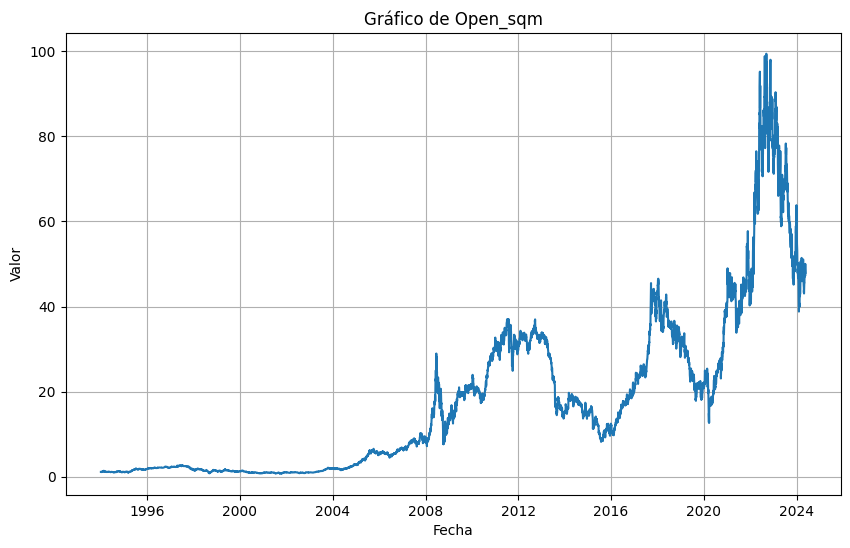

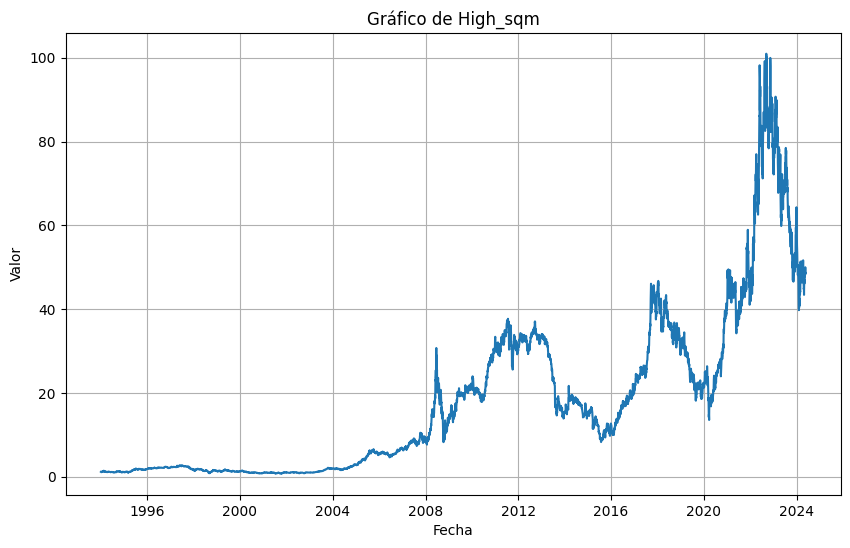

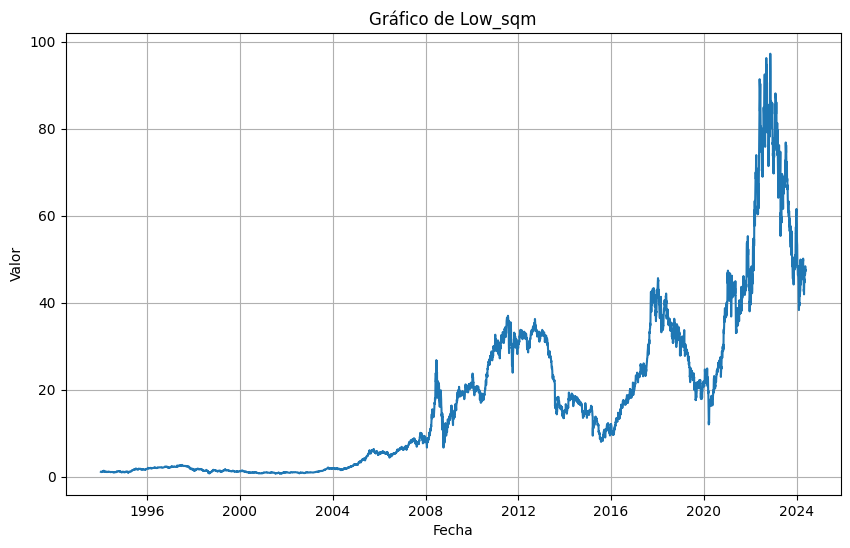

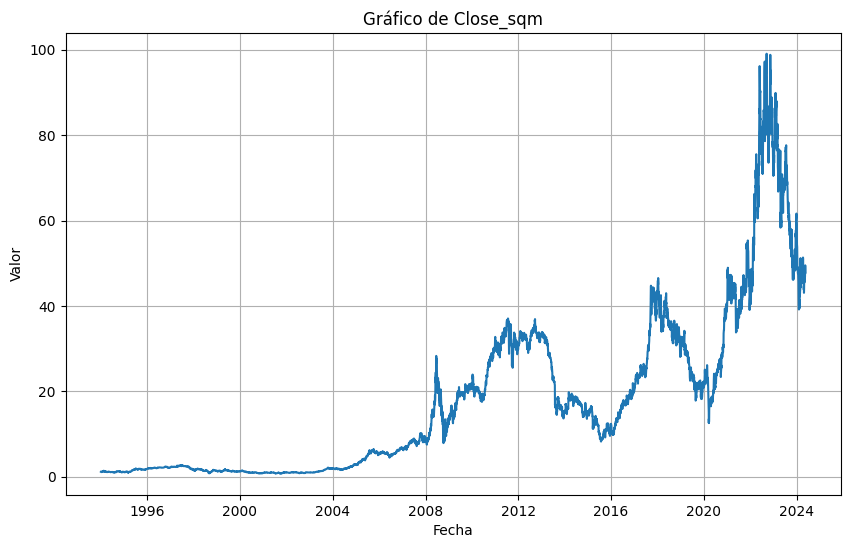

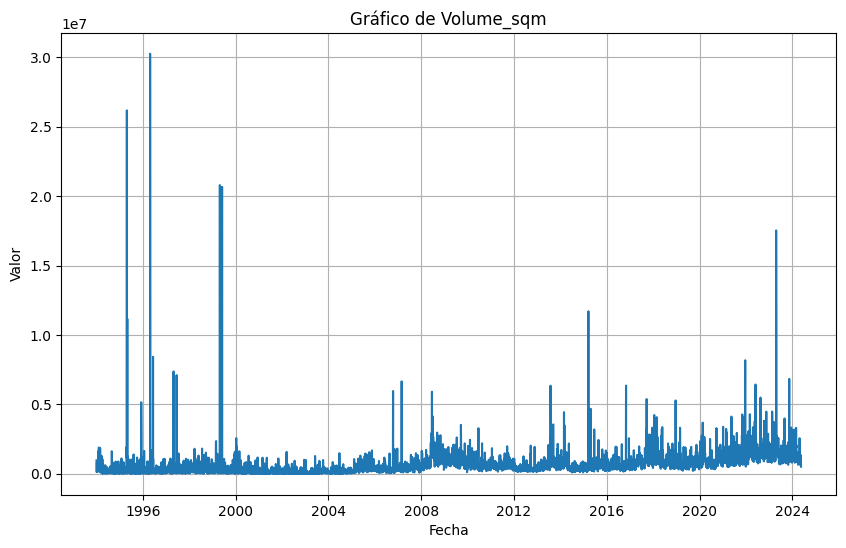

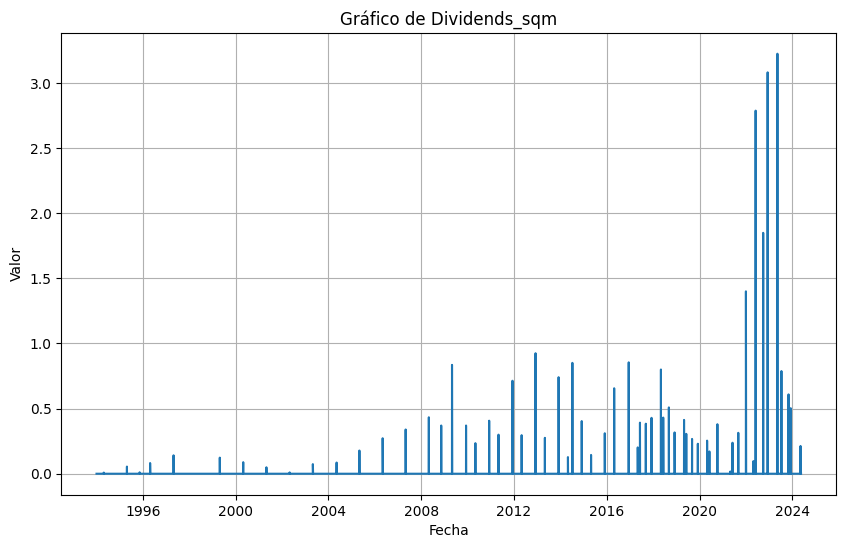

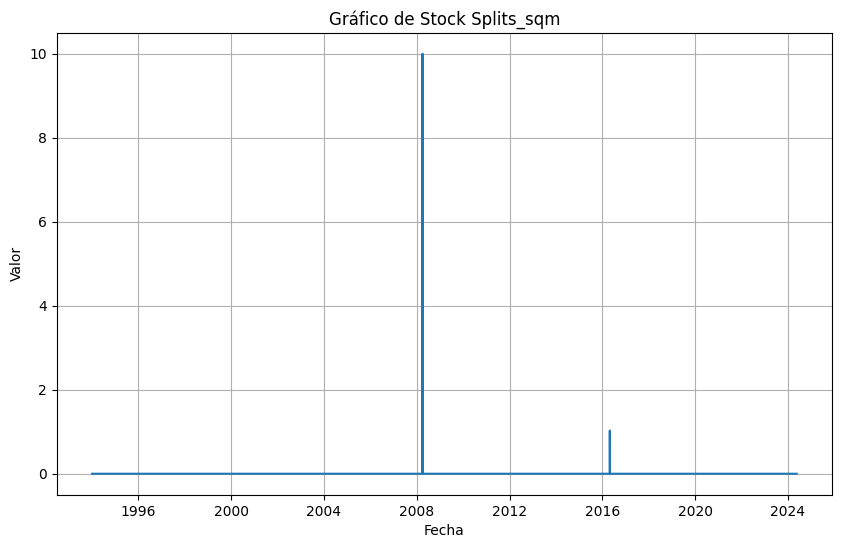

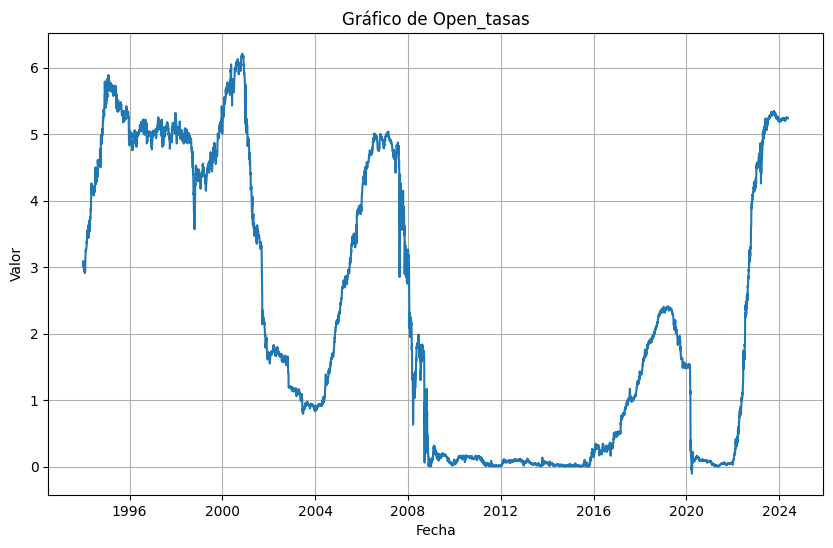

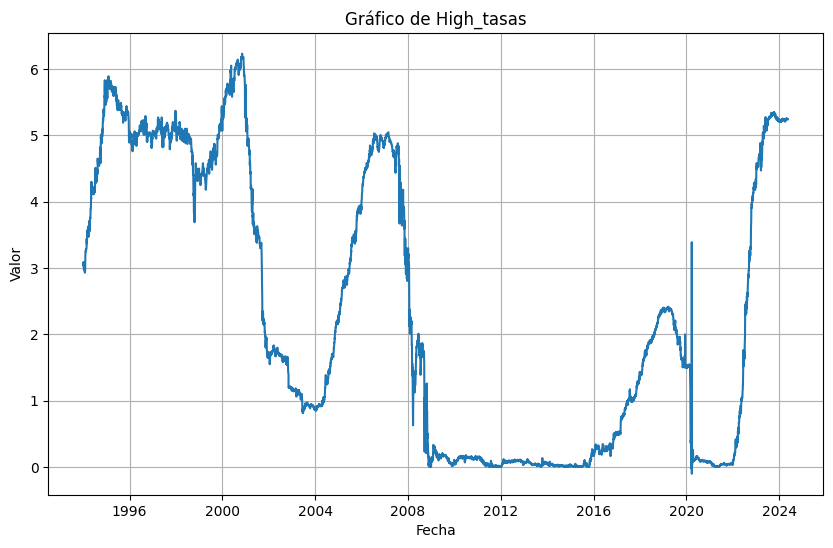

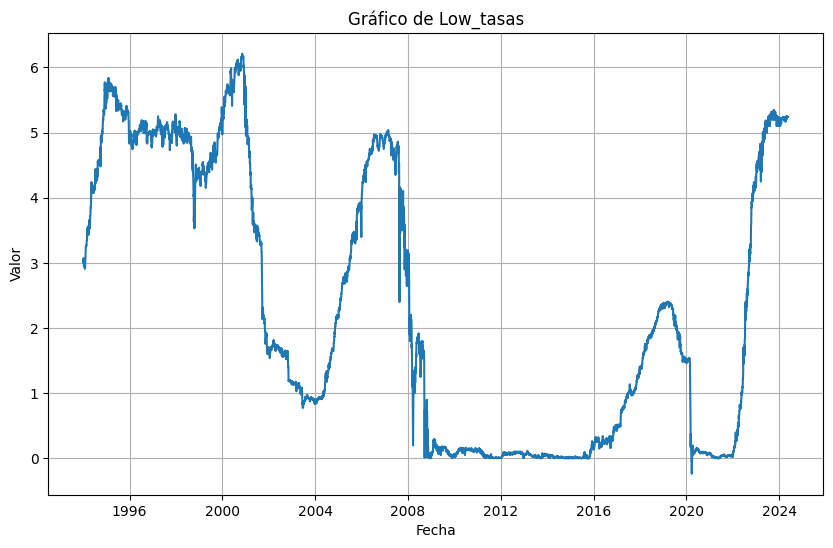

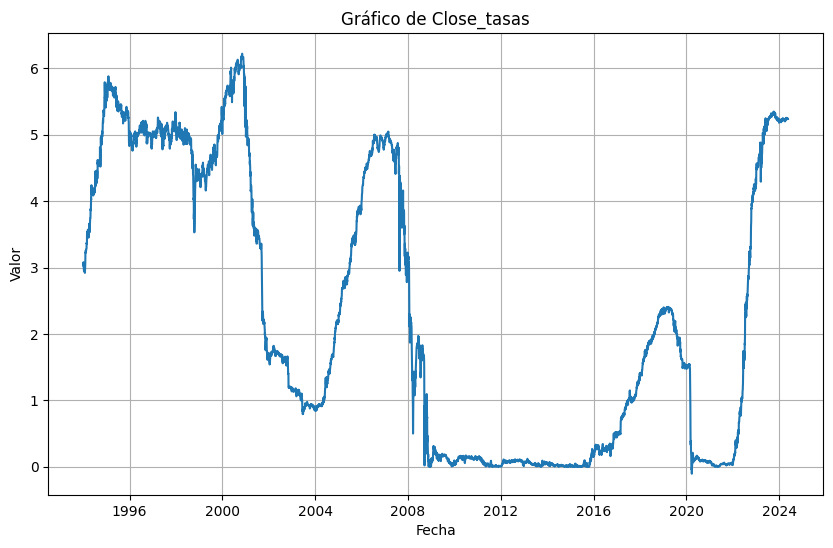

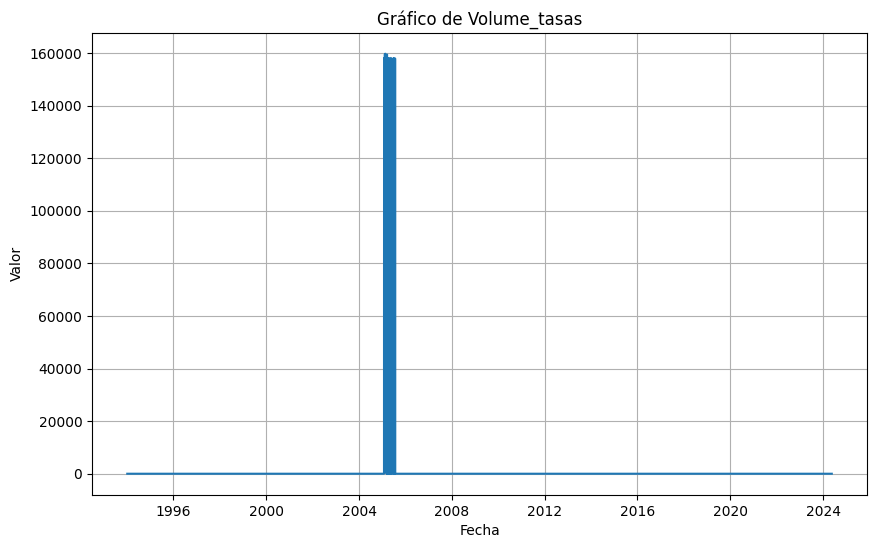

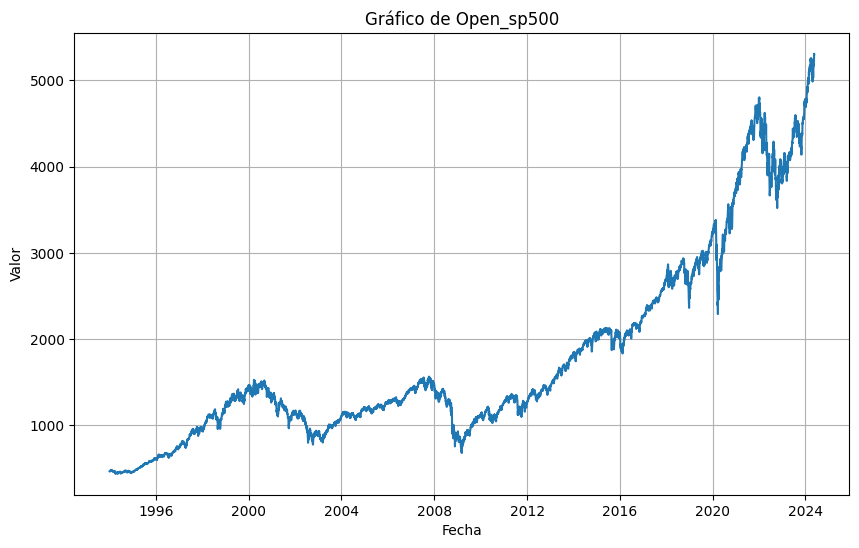

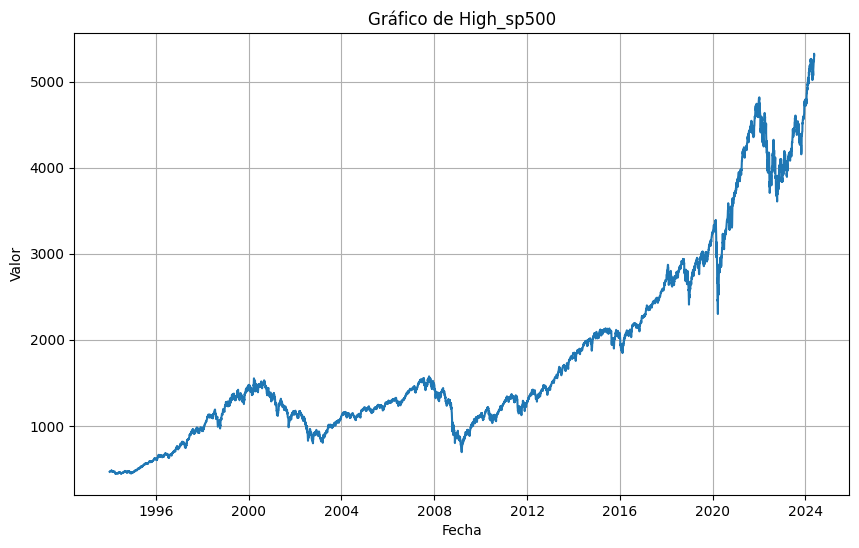

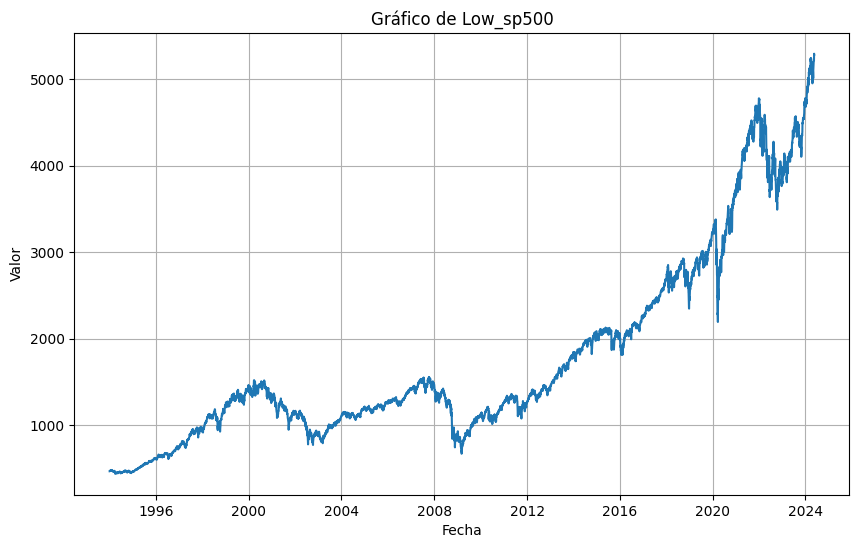

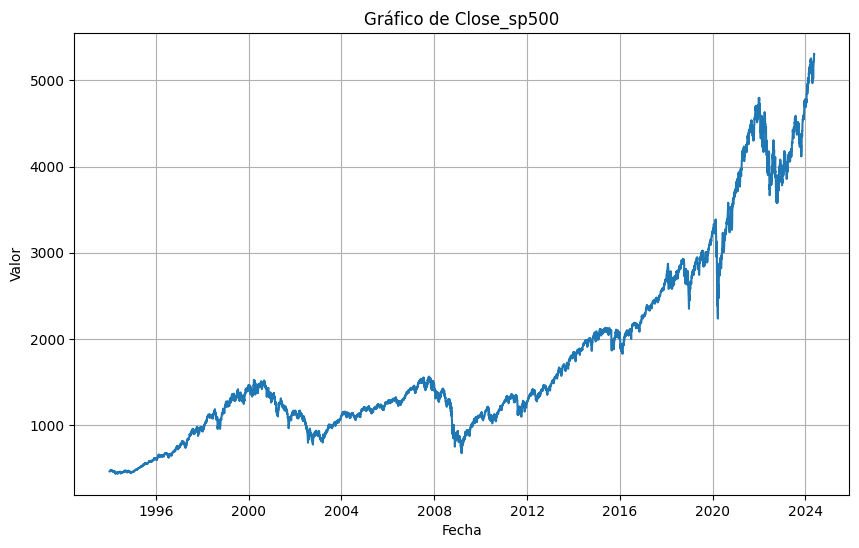

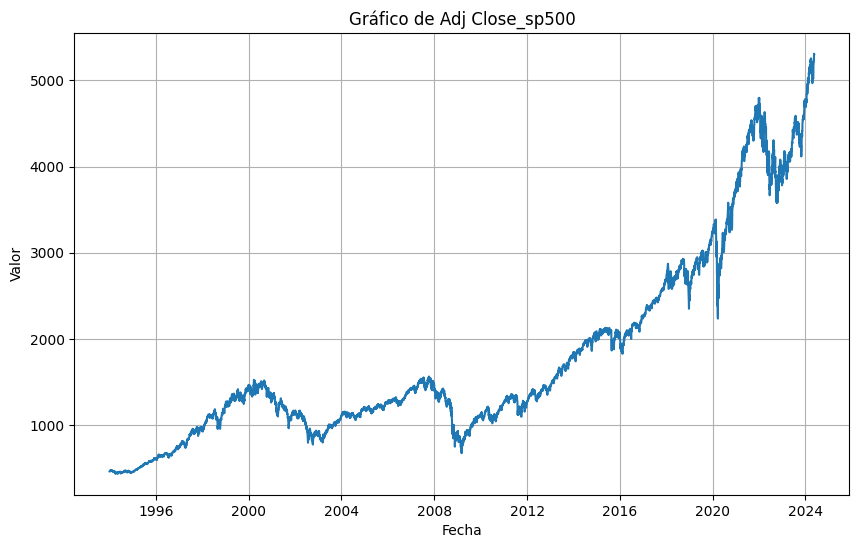

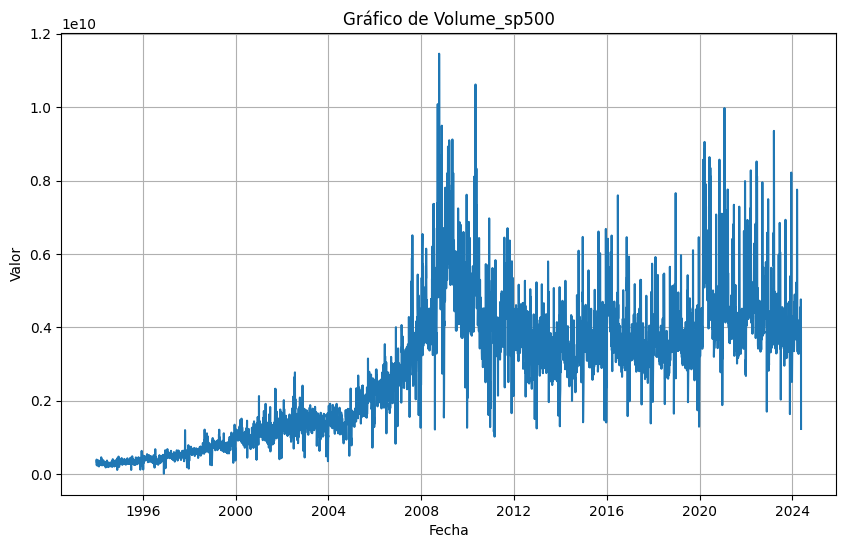

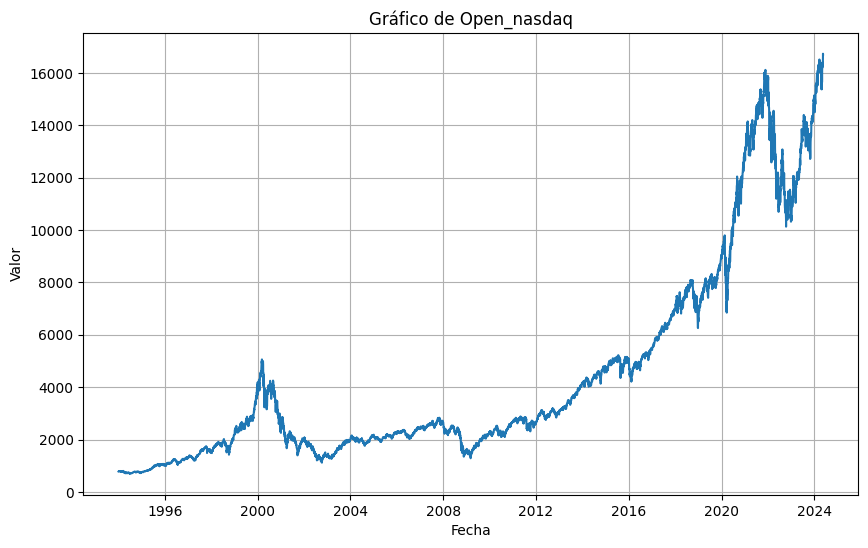

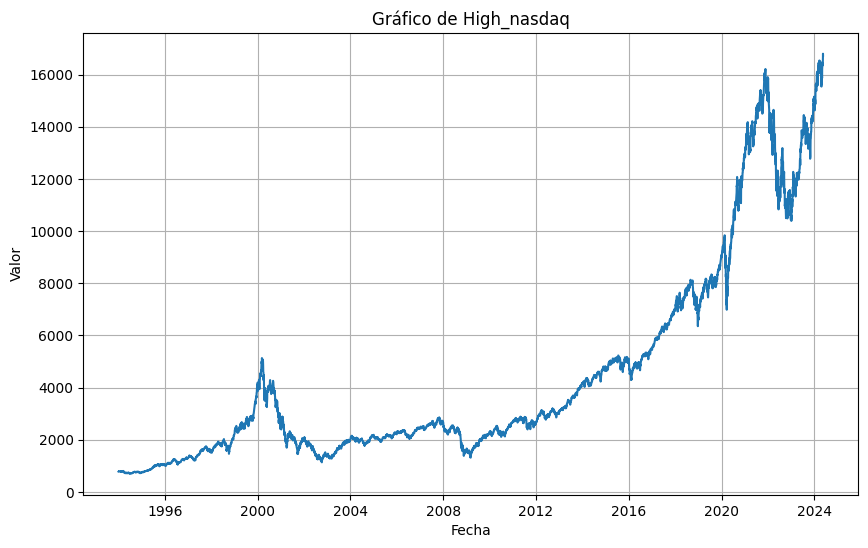

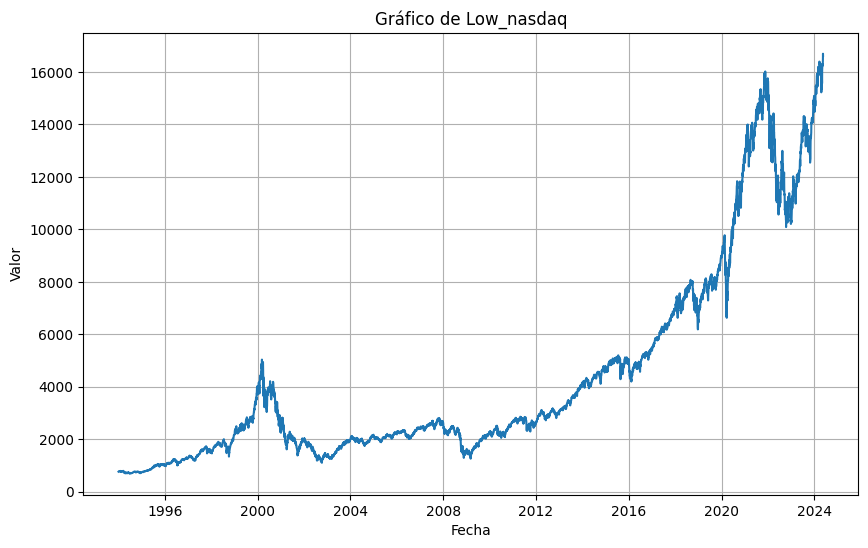

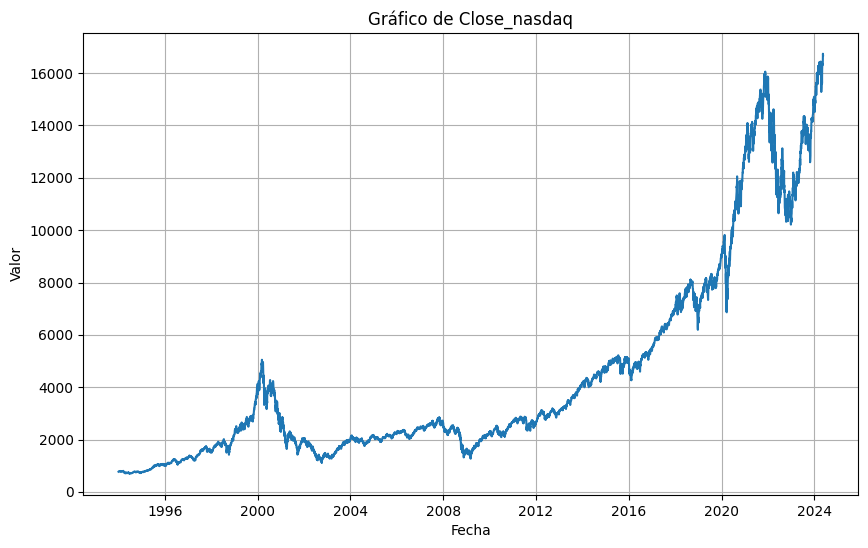

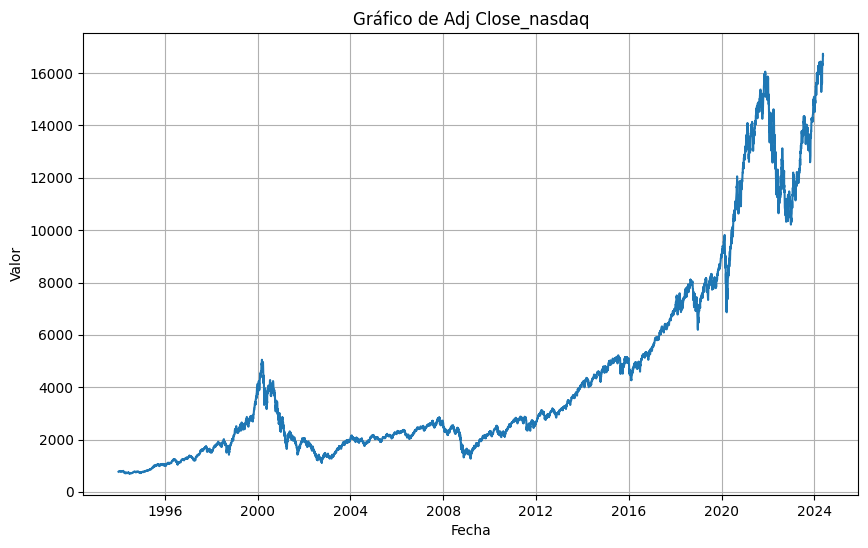

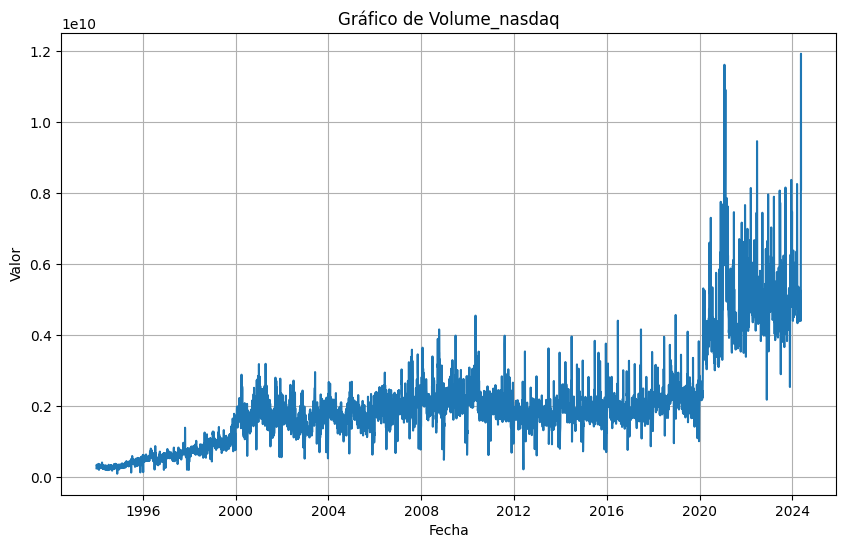

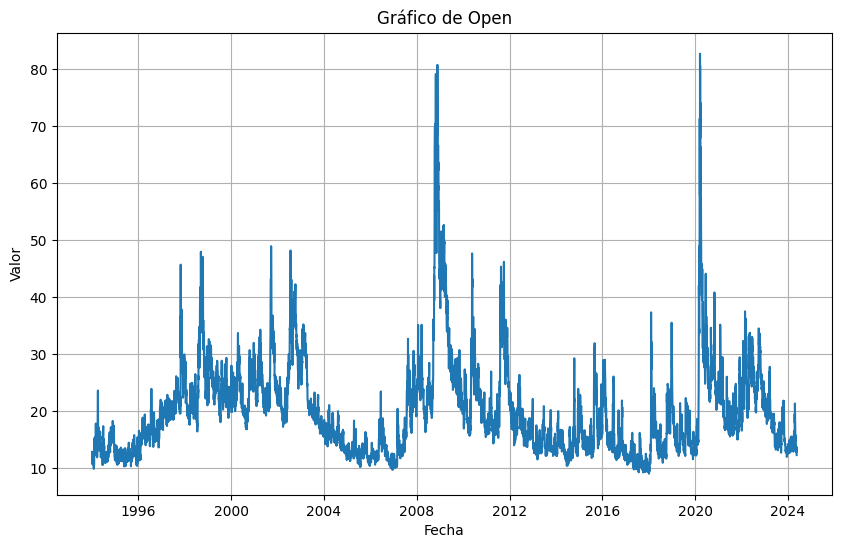

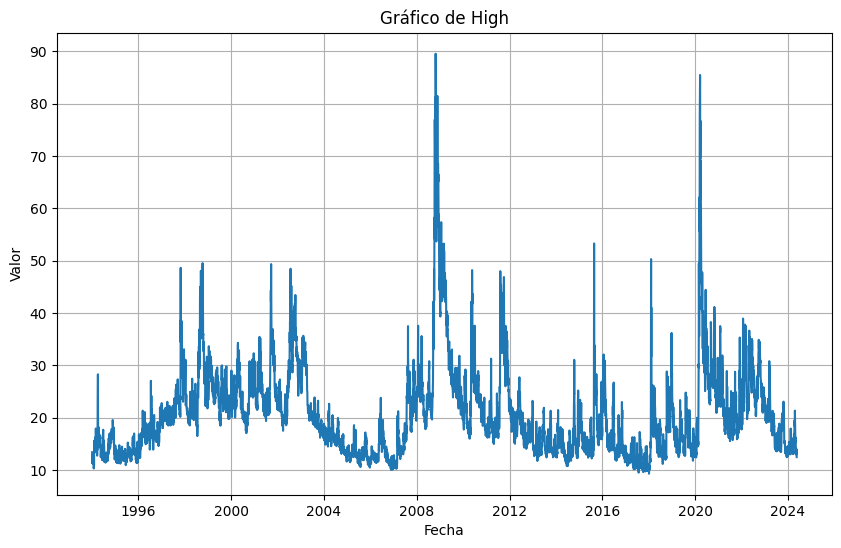

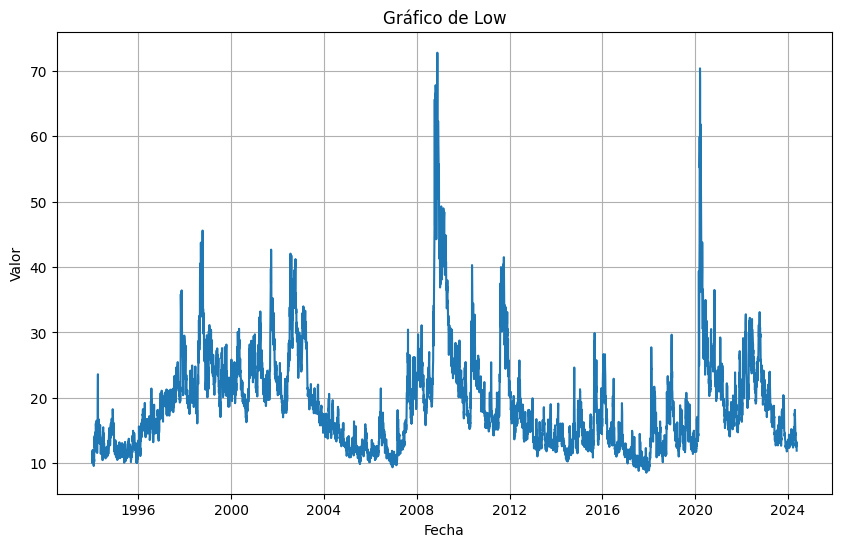

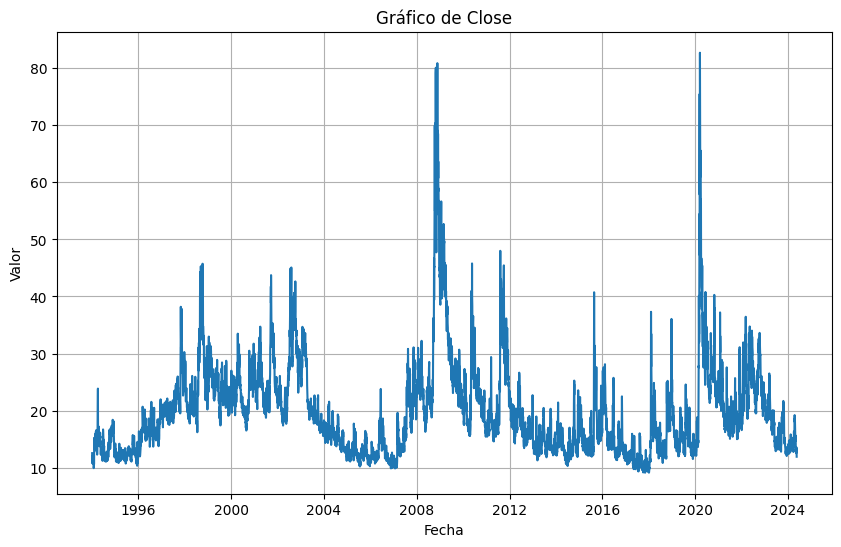

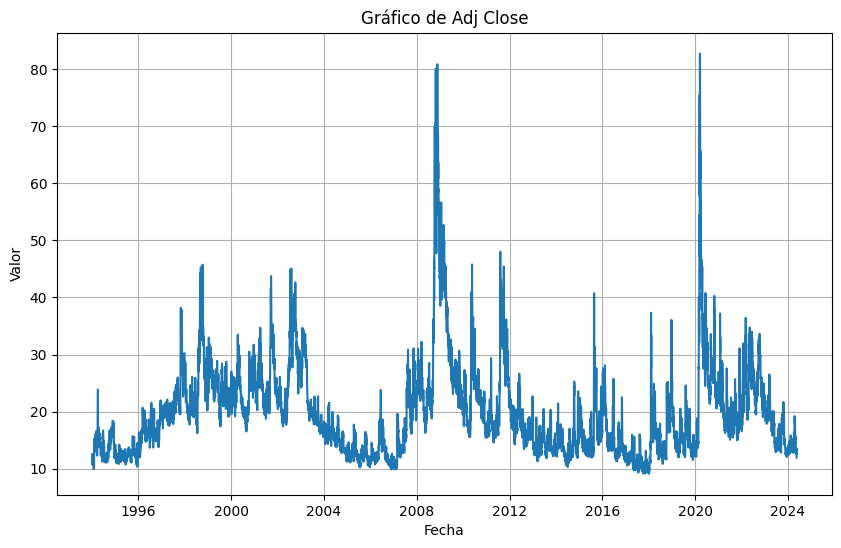

In [95]:
import matplotlib.pyplot as plt

# Suponiendo que df es tu DataFrame resultante
# Iterar sobre cada columna del DataFrame excepto 'Date' y graficarla en un gráfico individual
for column in df.columns:
    if column != 'Date':
        plt.figure(figsize=(10, 6))  # Configurar el tamaño del gráfico
        plt.plot(df['Date'], df[column])  # Graficar la columna contra 'Date'
        plt.title(f'Gráfico de {column}')  # Configurar el título
        plt.xlabel('Fecha')  # Configurar la etiqueta del eje x
        plt.ylabel('Valor')  # Configurar la etiqueta del eje y
        plt.grid(True)  # Mostrar rejilla
        plt.show()  # Mostrar el gráfico

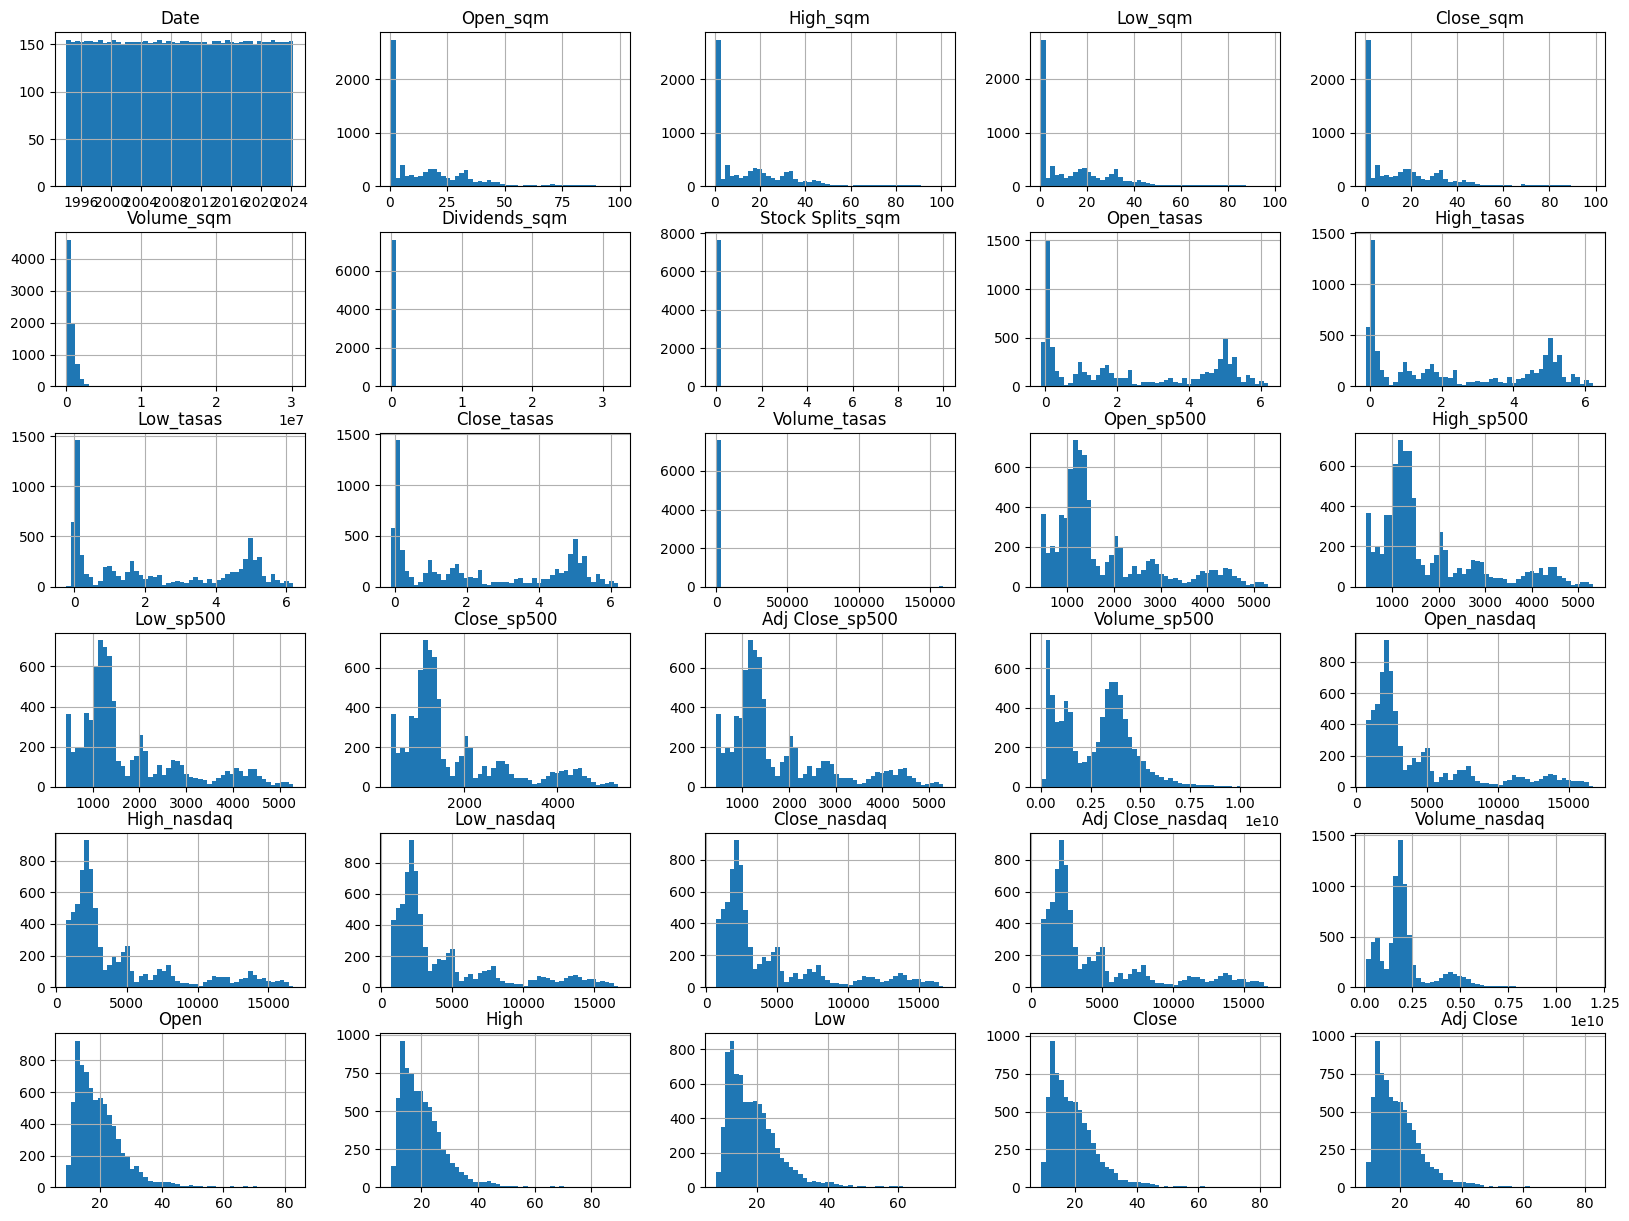

In [96]:
# Histogramas para variables numéricas
df.hist(bins=50, figsize=(20,15))
plt.show()

In [97]:
import numpy as np
# Suponiendo que df es tu DataFrame
columns_to_transform = ['Open_sqm', 'High_sqm', 'Low_sqm', 'Close_sqm', 'Volume_sqm',
                         'Dividends_sqm', 'Stock Splits_sqm', 'Open_tasas', 'High_tasas',
                         'Low_tasas', 'Close_tasas', 'Volume_tasas', 'Open_sp500',
                         'High_sp500', 'Low_sp500', 'Close_sp500', 'Adj Close_sp500',
                         'Volume_sp500', 'Open_nasdaq', 'High_nasdaq', 'Low_nasdaq',
                         'Close_nasdaq', 'Adj Close_nasdaq', 'Volume_nasdaq', 'Open',
                         'High', 'Low', 'Close', 'Adj Close']

df[columns_to_transform] = df[columns_to_transform].apply(lambda x: np.log1p(x))

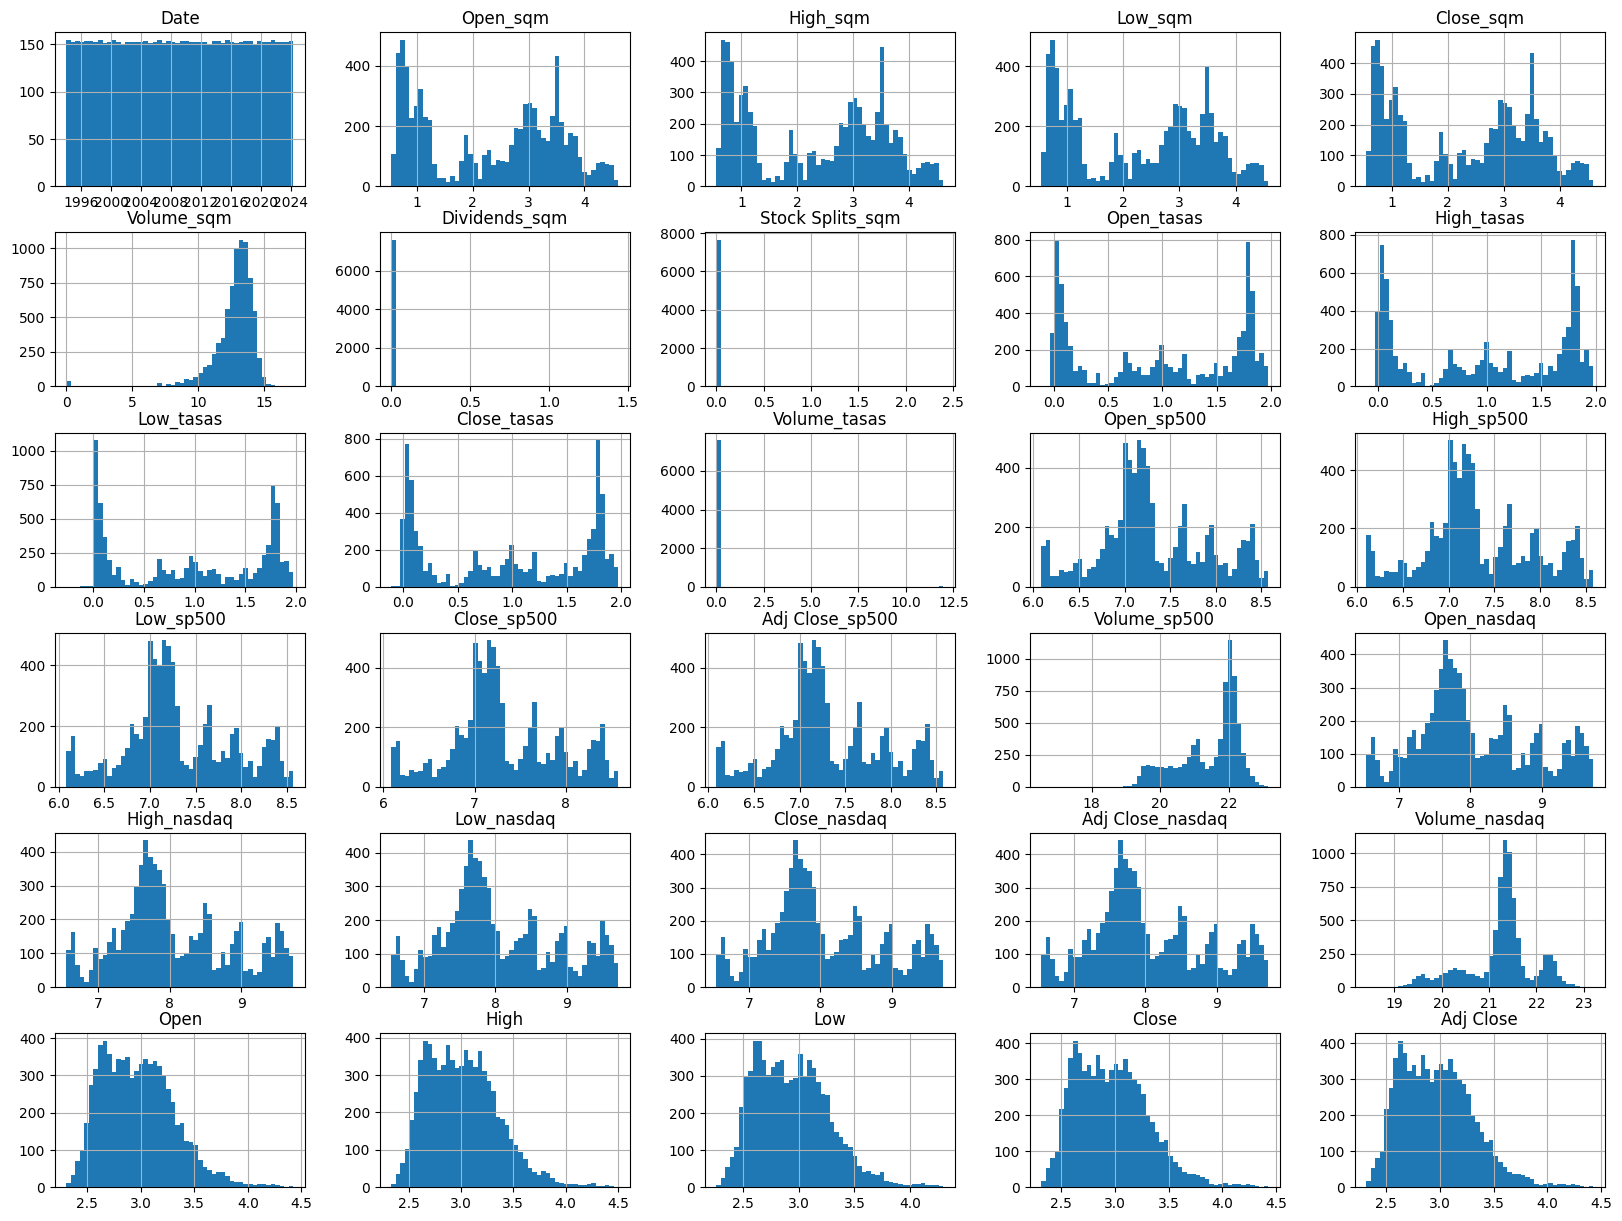

In [98]:
# Histogramas para variables numéricas
df.hist(bins=50, figsize=(20,15))
plt.show()

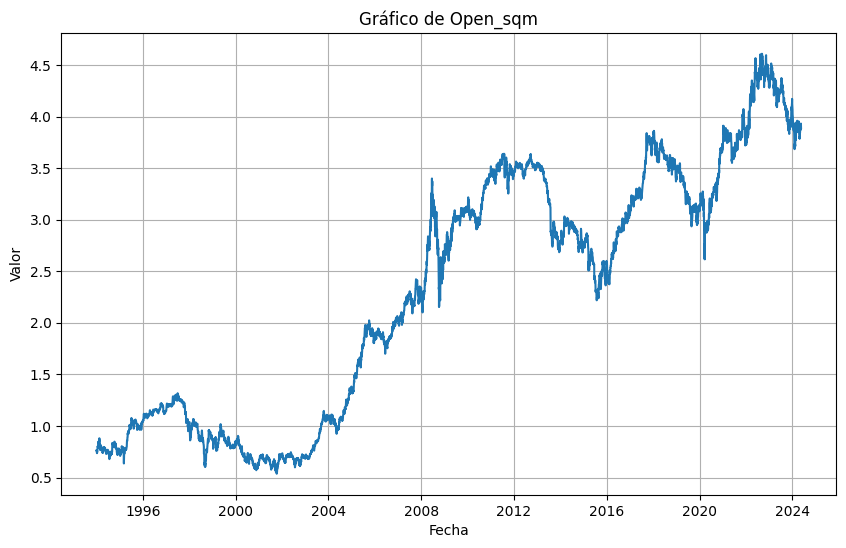

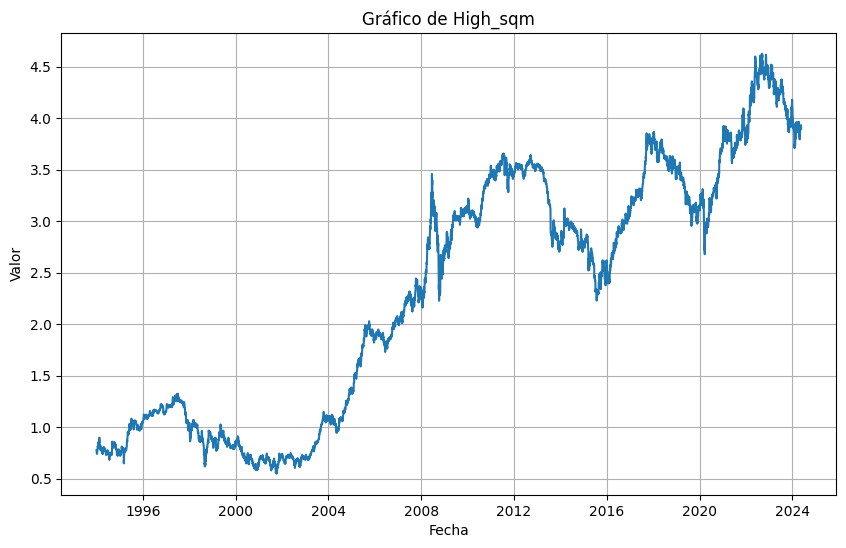

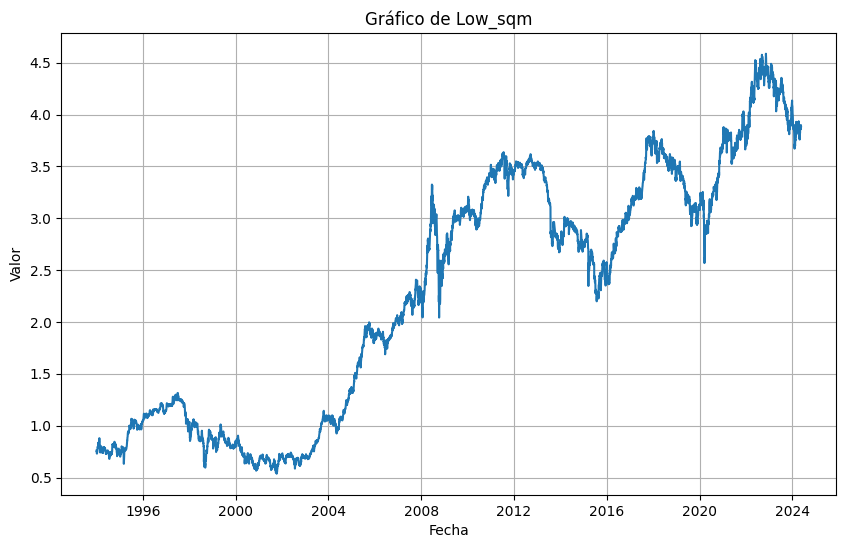

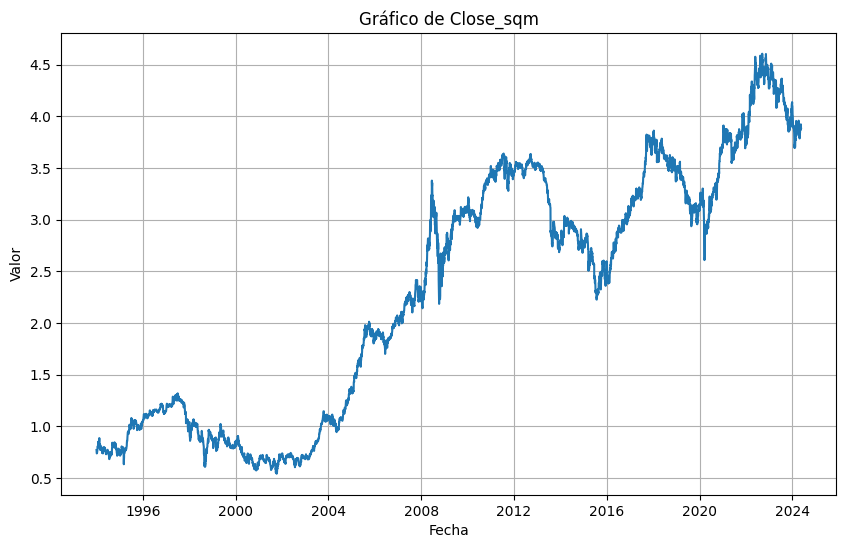

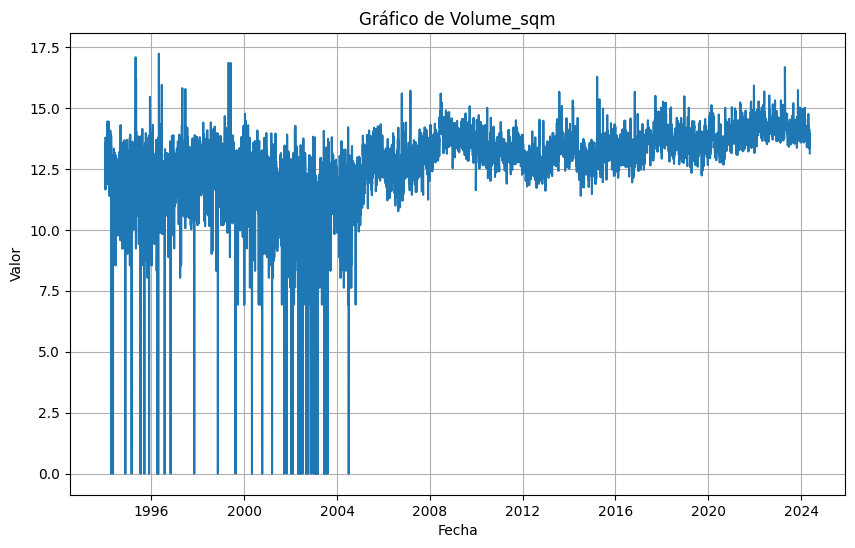

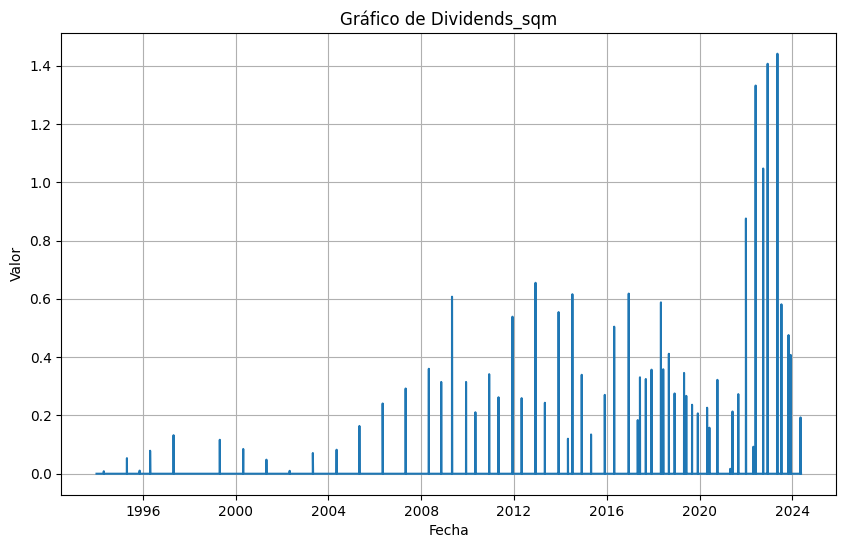

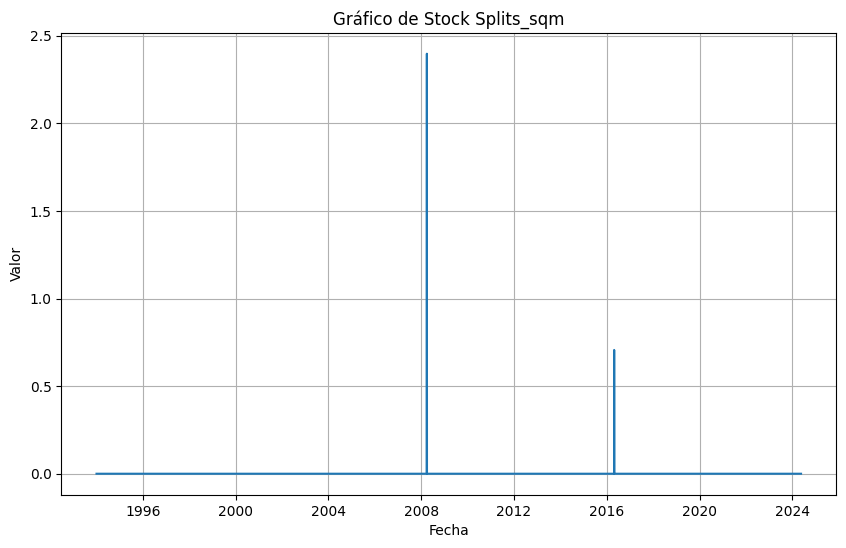

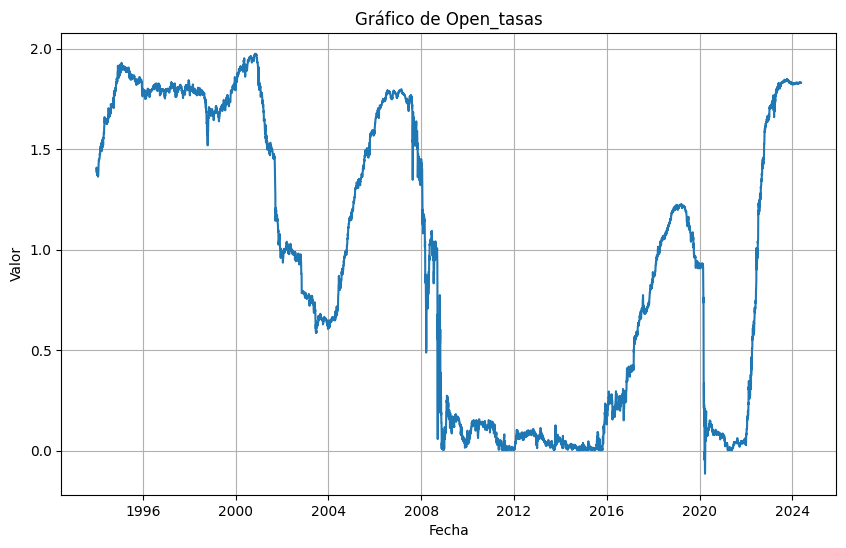

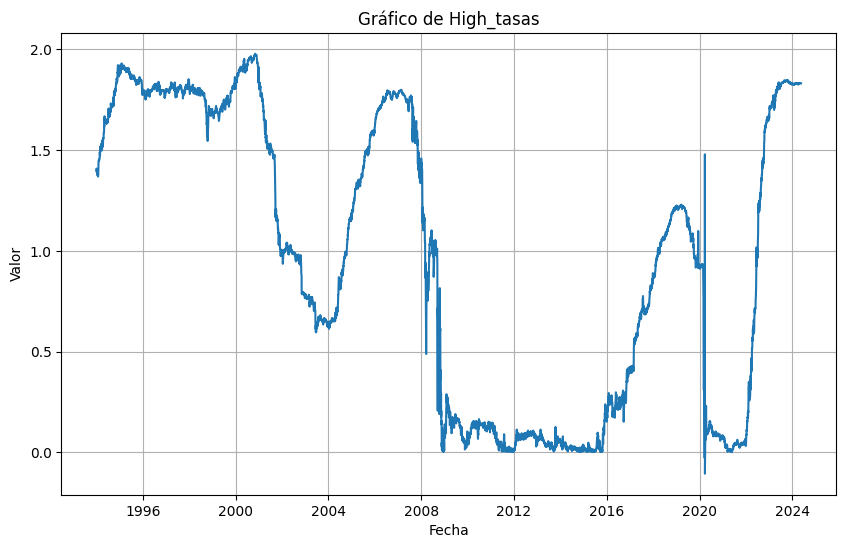

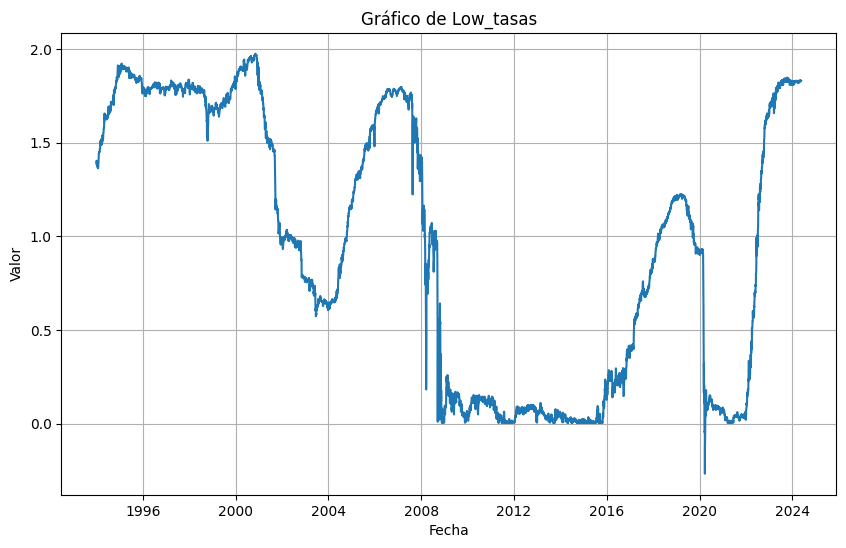

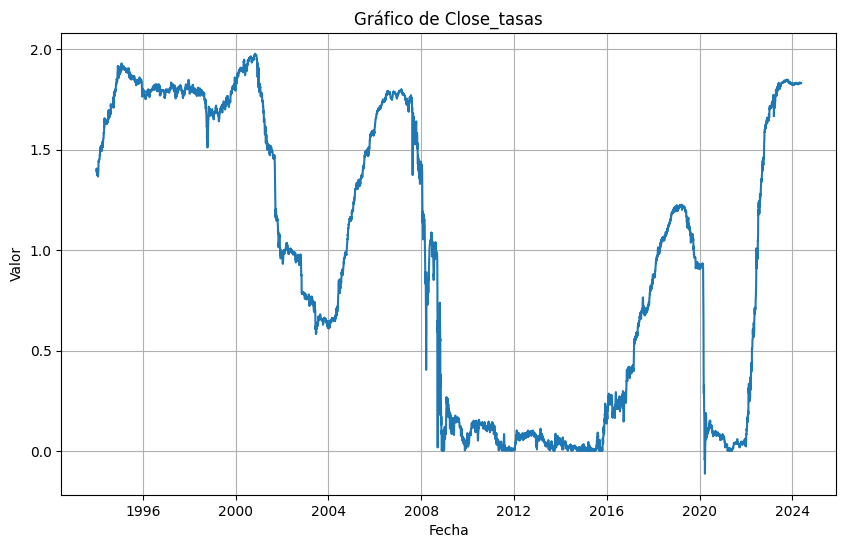

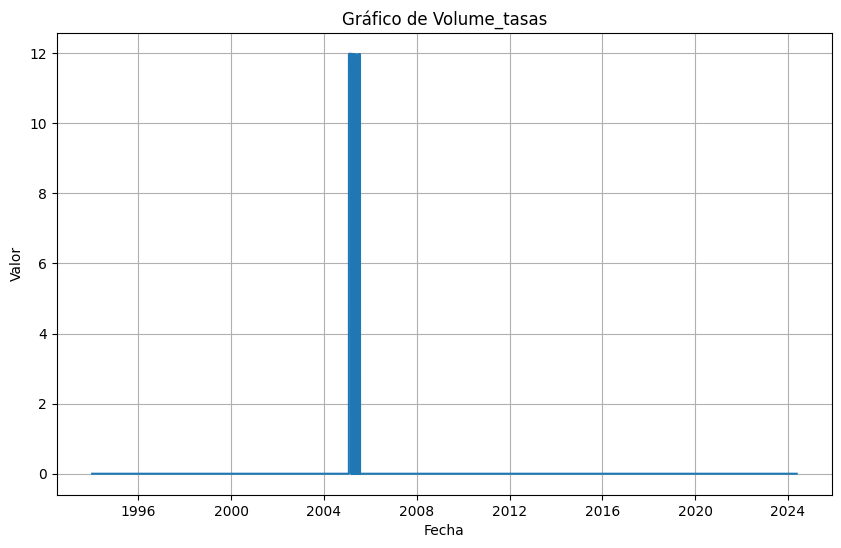

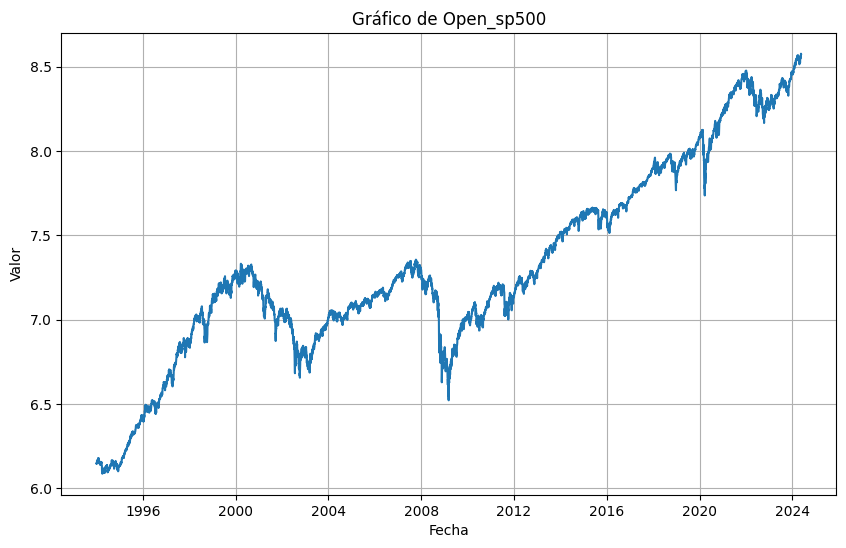

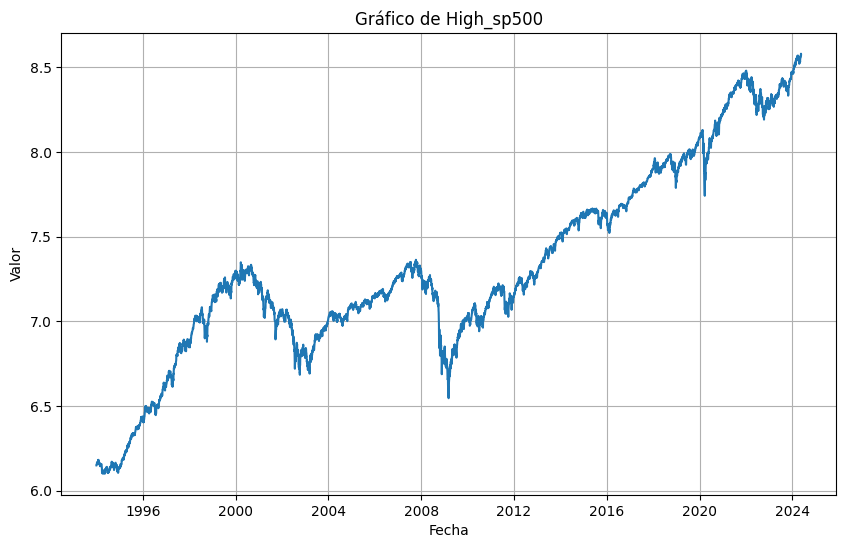

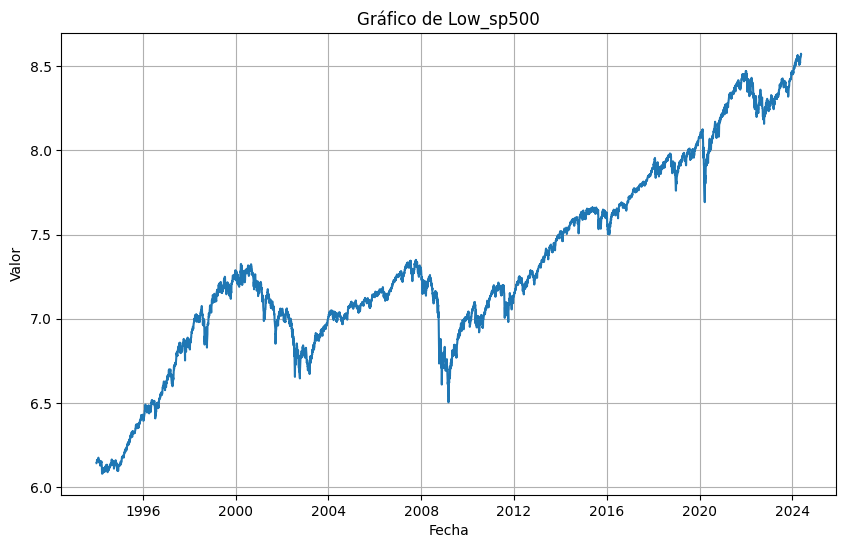

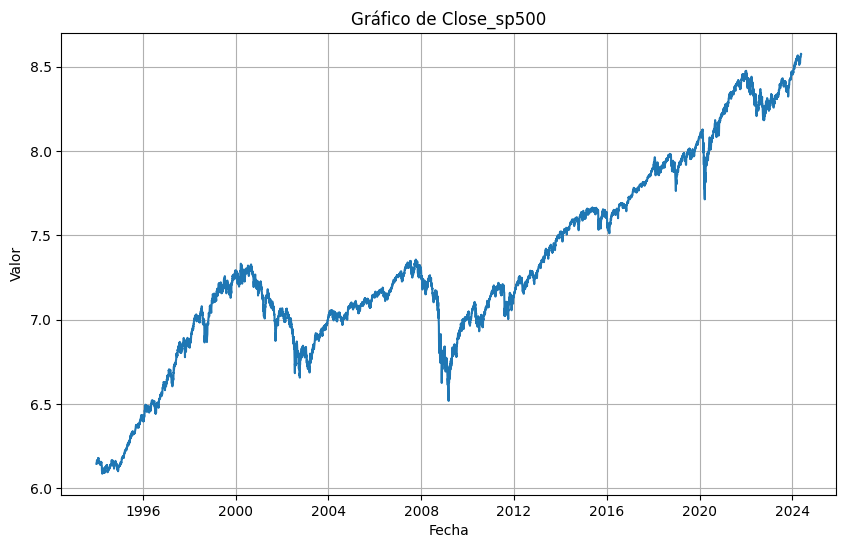

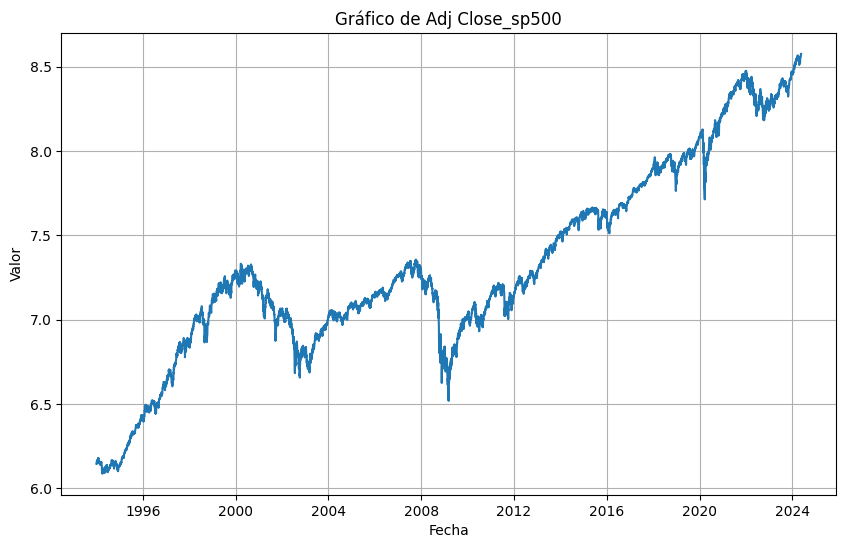

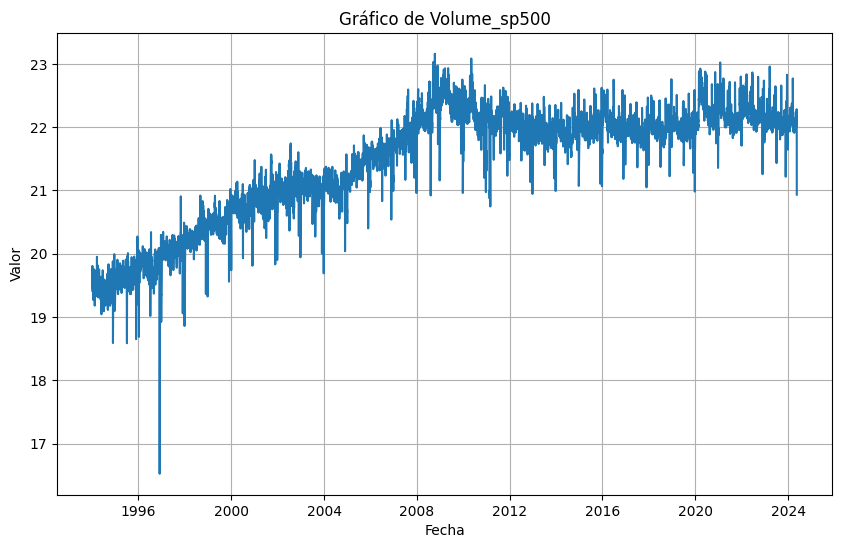

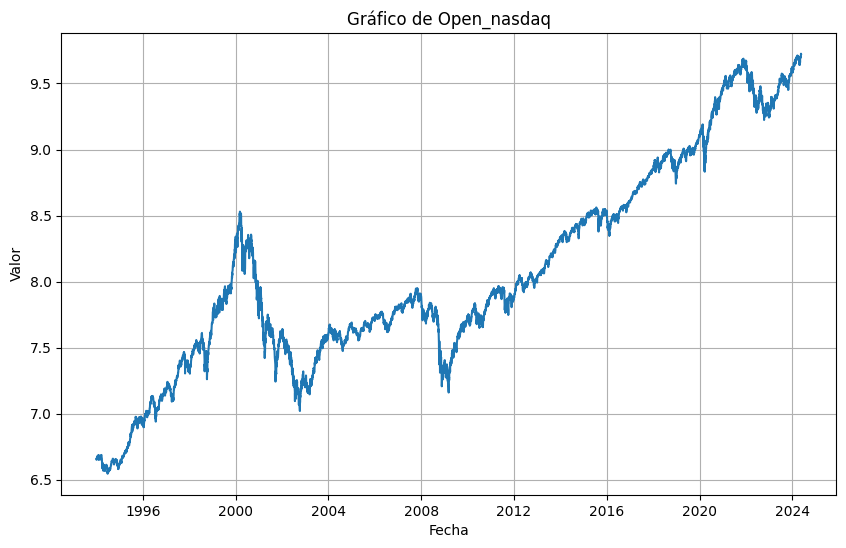

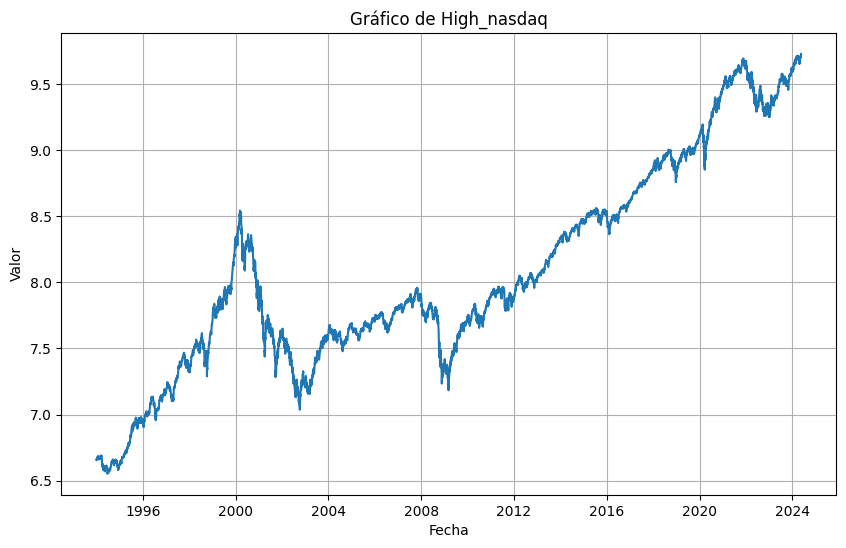

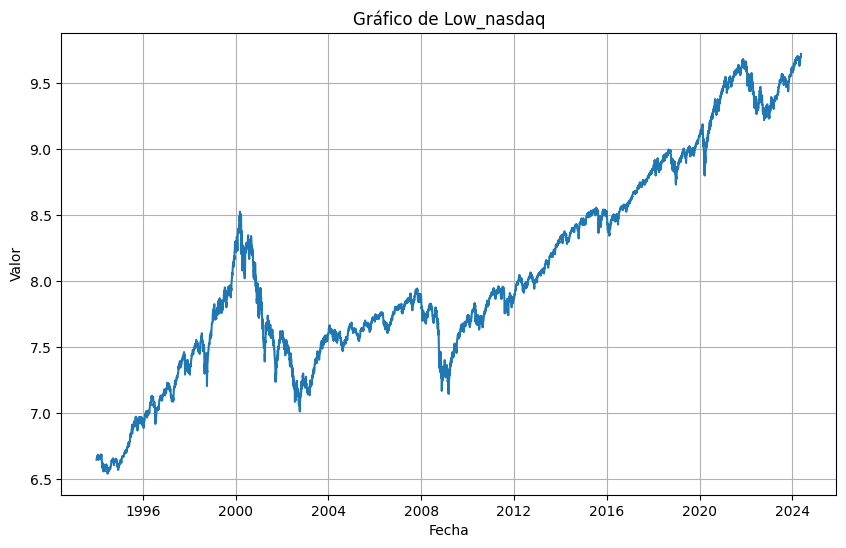

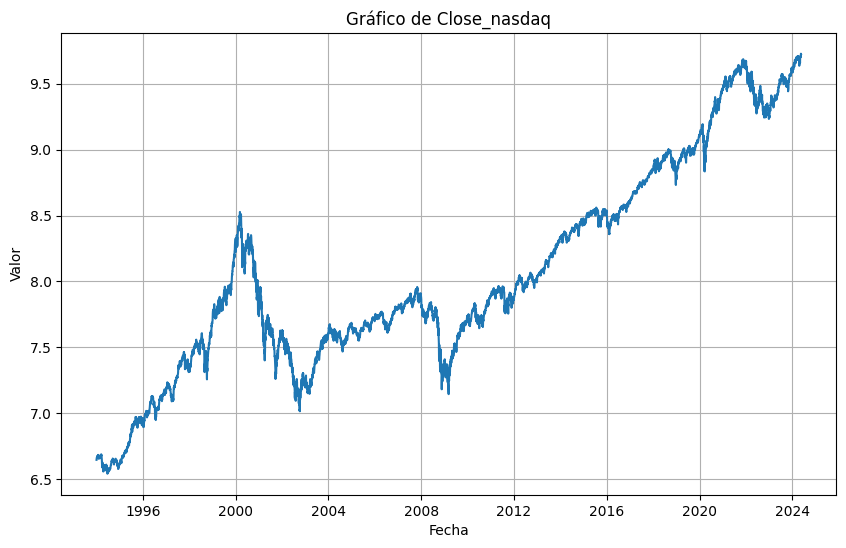

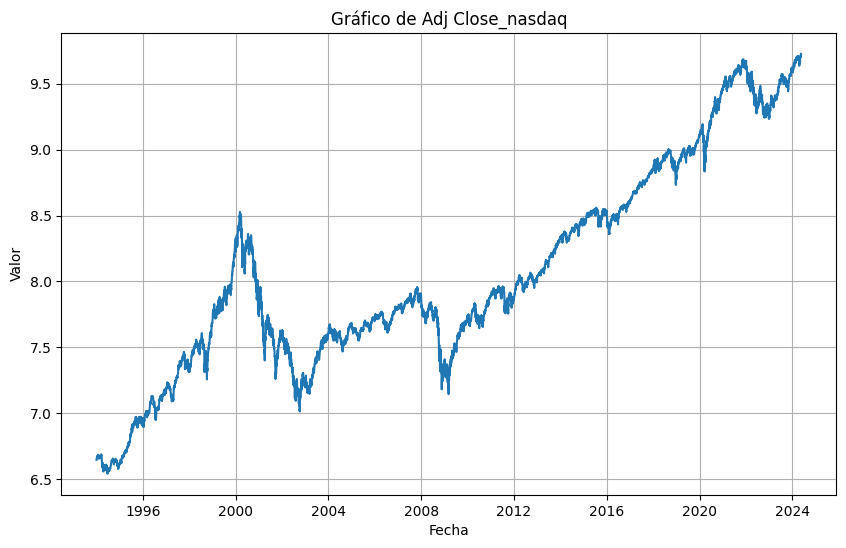

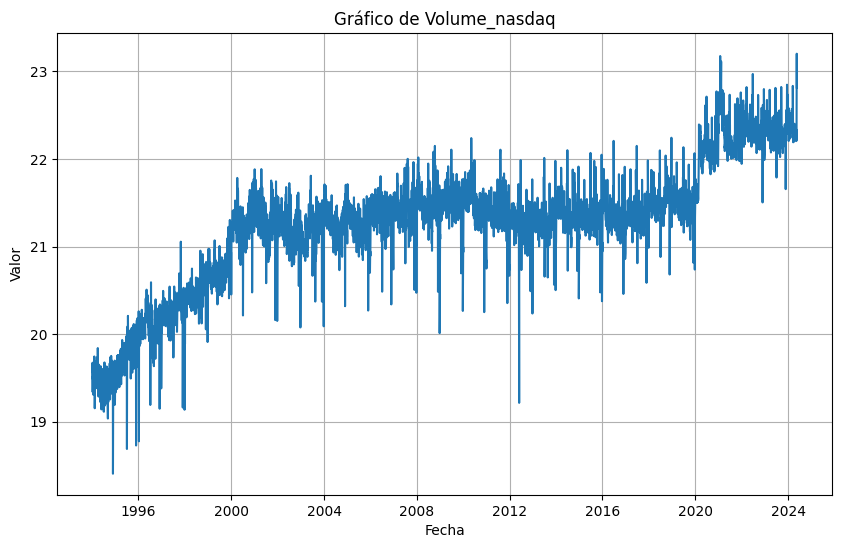

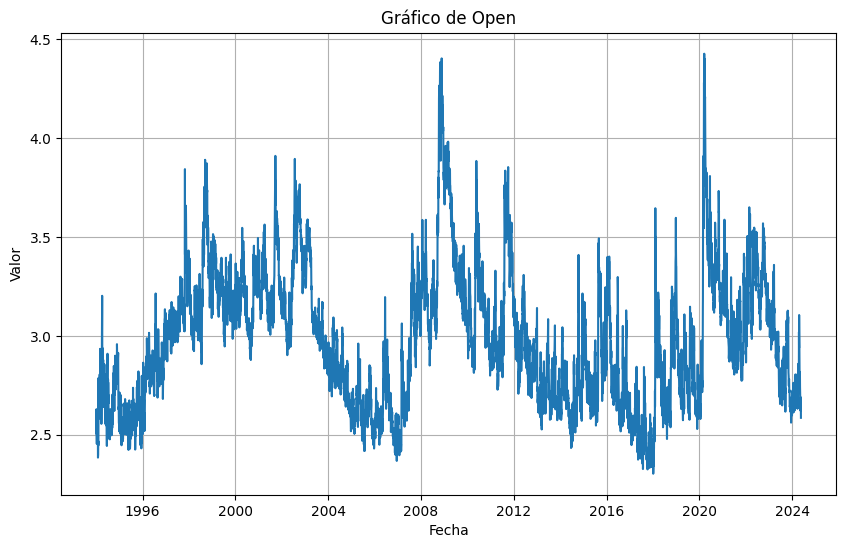

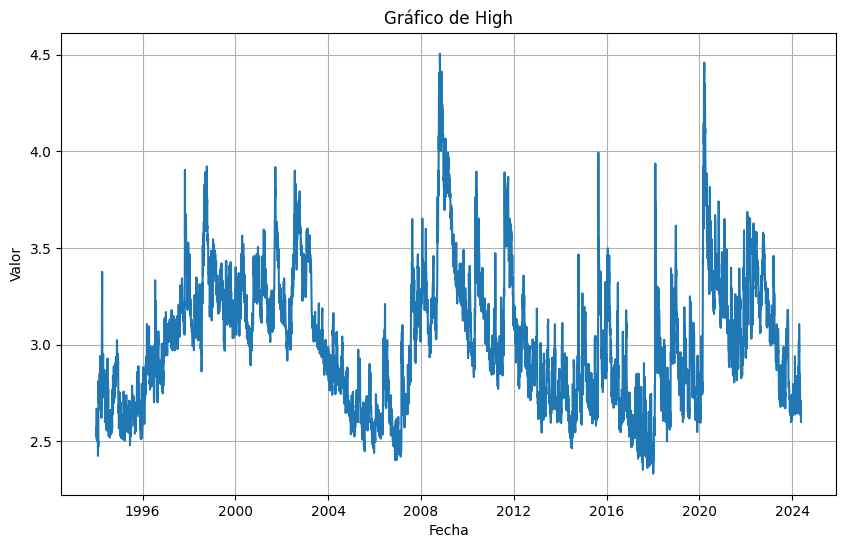

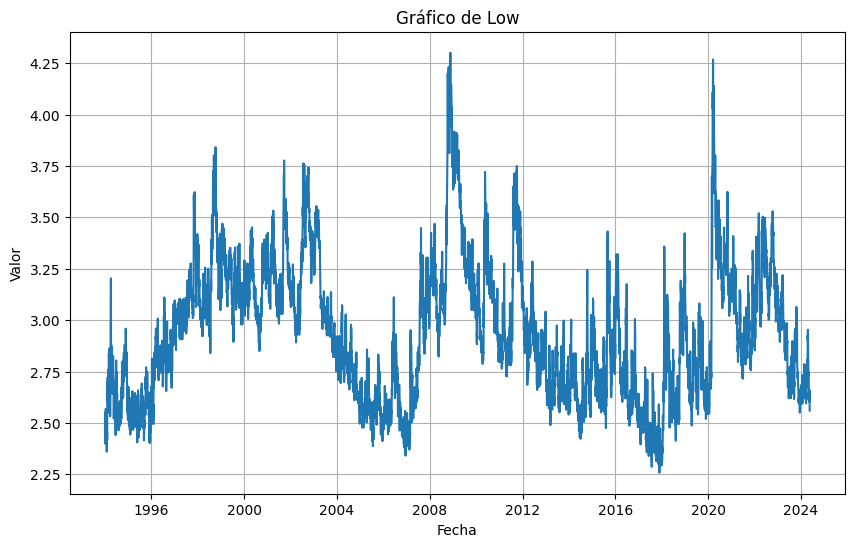

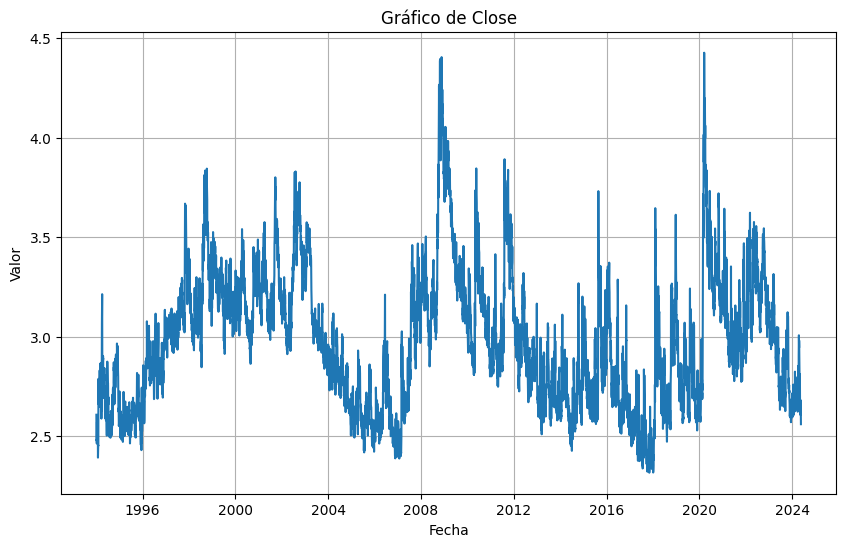

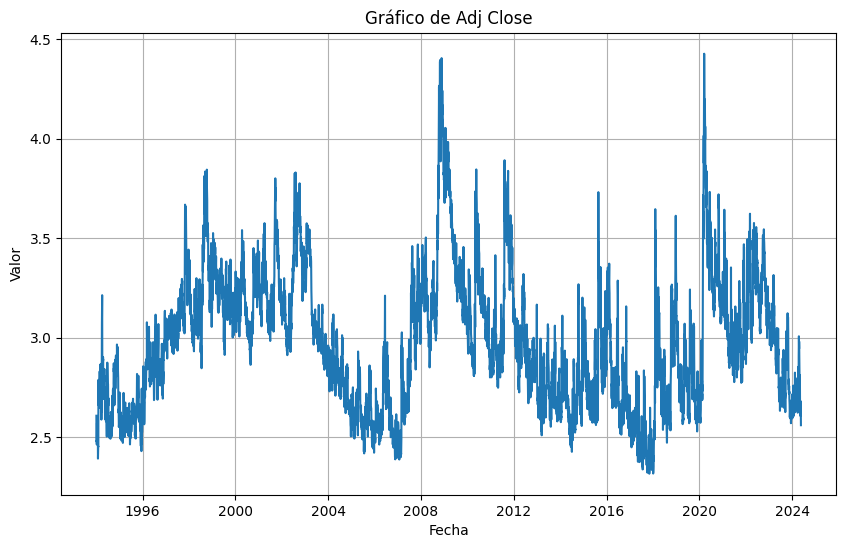

In [99]:
import matplotlib.pyplot as plt

# Suponiendo que df es tu DataFrame resultante
# Iterar sobre cada columna del DataFrame excepto 'Date' y graficarla en un gráfico individual
for column in df.columns:
    if column != 'Date':
        plt.figure(figsize=(10, 6))  # Configurar el tamaño del gráfico
        plt.plot(df['Date'], df[column])  # Graficar la columna contra 'Date'
        plt.title(f'Gráfico de {column}')  # Configurar el título
        plt.xlabel('Fecha')  # Configurar la etiqueta del eje x
        plt.ylabel('Valor')  # Configurar la etiqueta del eje y
        plt.grid(True)  # Mostrar rejilla
        plt.show()  # Mostrar el gráfico

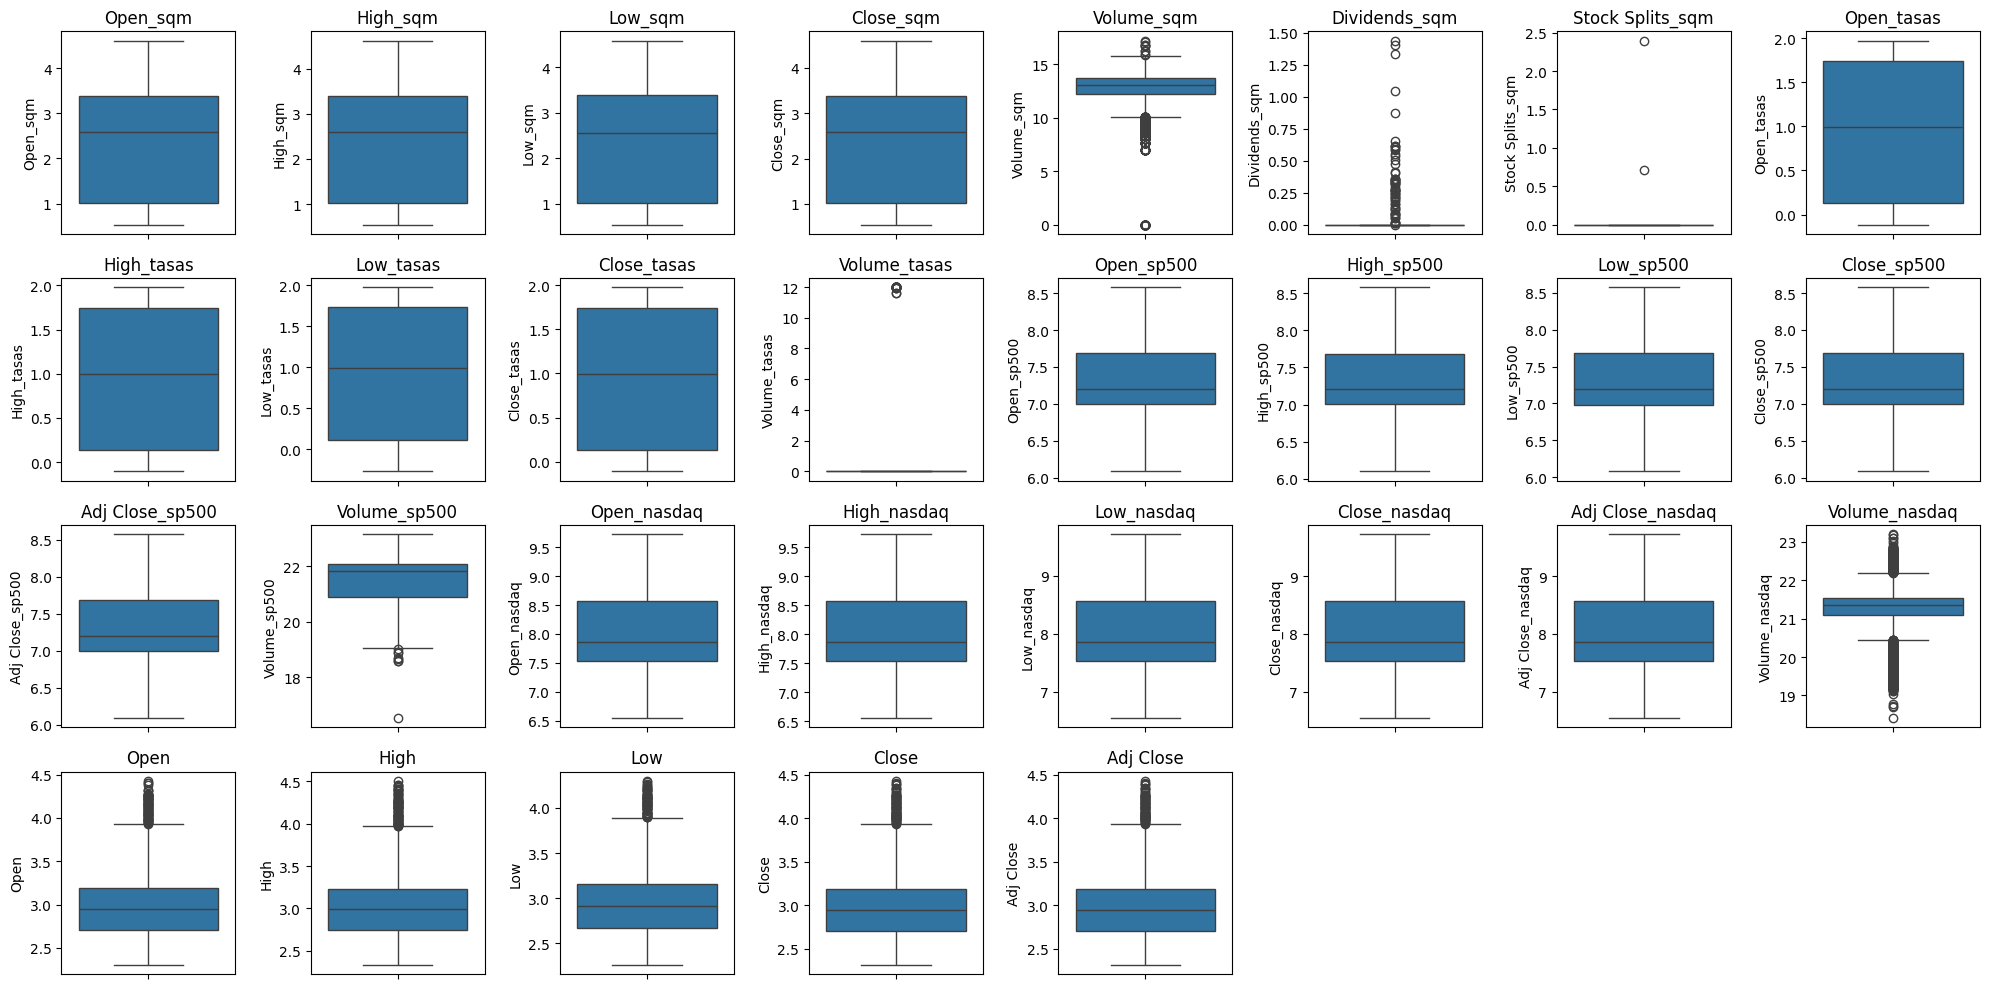

In [100]:
import seaborn as sns

# Lista de variables a graficar
variables = ['Open_sqm', 'High_sqm', 'Low_sqm', 'Close_sqm', 'Volume_sqm',
             'Dividends_sqm', 'Stock Splits_sqm', 'Open_tasas', 'High_tasas',
             'Low_tasas', 'Close_tasas', 'Volume_tasas', 'Open_sp500',
             'High_sp500', 'Low_sp500', 'Close_sp500', 'Adj Close_sp500',
             'Volume_sp500', 'Open_nasdaq', 'High_nasdaq', 'Low_nasdaq',
             'Close_nasdaq', 'Adj Close_nasdaq', 'Volume_nasdaq', 'Open',
             'High', 'Low', 'Close', 'Adj Close']

plt.figure(figsize=(20, 10))

for i, var in enumerate(variables):
    plt.subplot(4, 8, i + 1)
    sns.boxplot(y=df[var])
    plt.title(var)

plt.tight_layout()
plt.show()


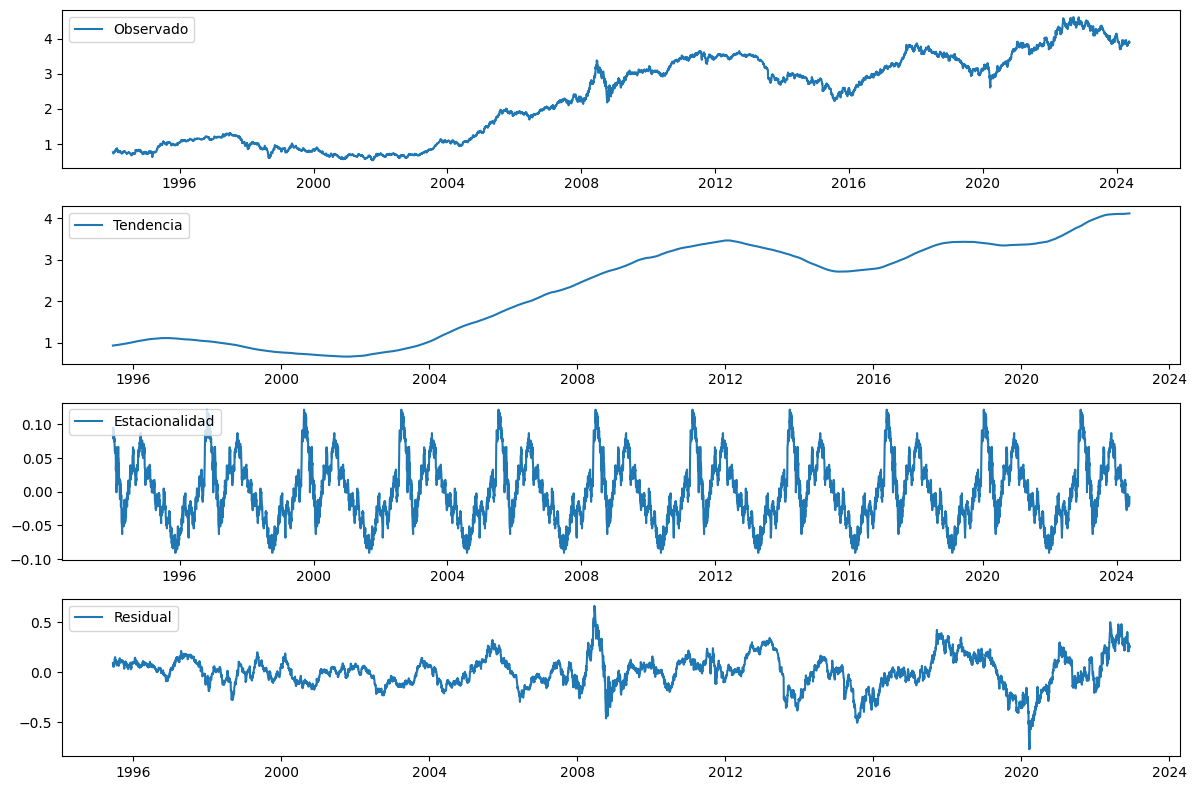

In [101]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Suponiendo que 'Close' es la columna que contiene tus datos de precios de cierre
# y que 'Date' es tu índice de fecha
df.index = df['Date']

# Descomposición de la serie temporal
result = seasonal_decompose(df['Close_sqm'], model='additive', period=730)  # Se asume un período de estacionalidad de 30 días

# Visualización de la descomposición
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(result.observed, label='Observado')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(result.trend, label='Tendencia')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(result.seasonal, label='Estacionalidad')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


In [102]:
result.resid.mean()

0.005434395102976068

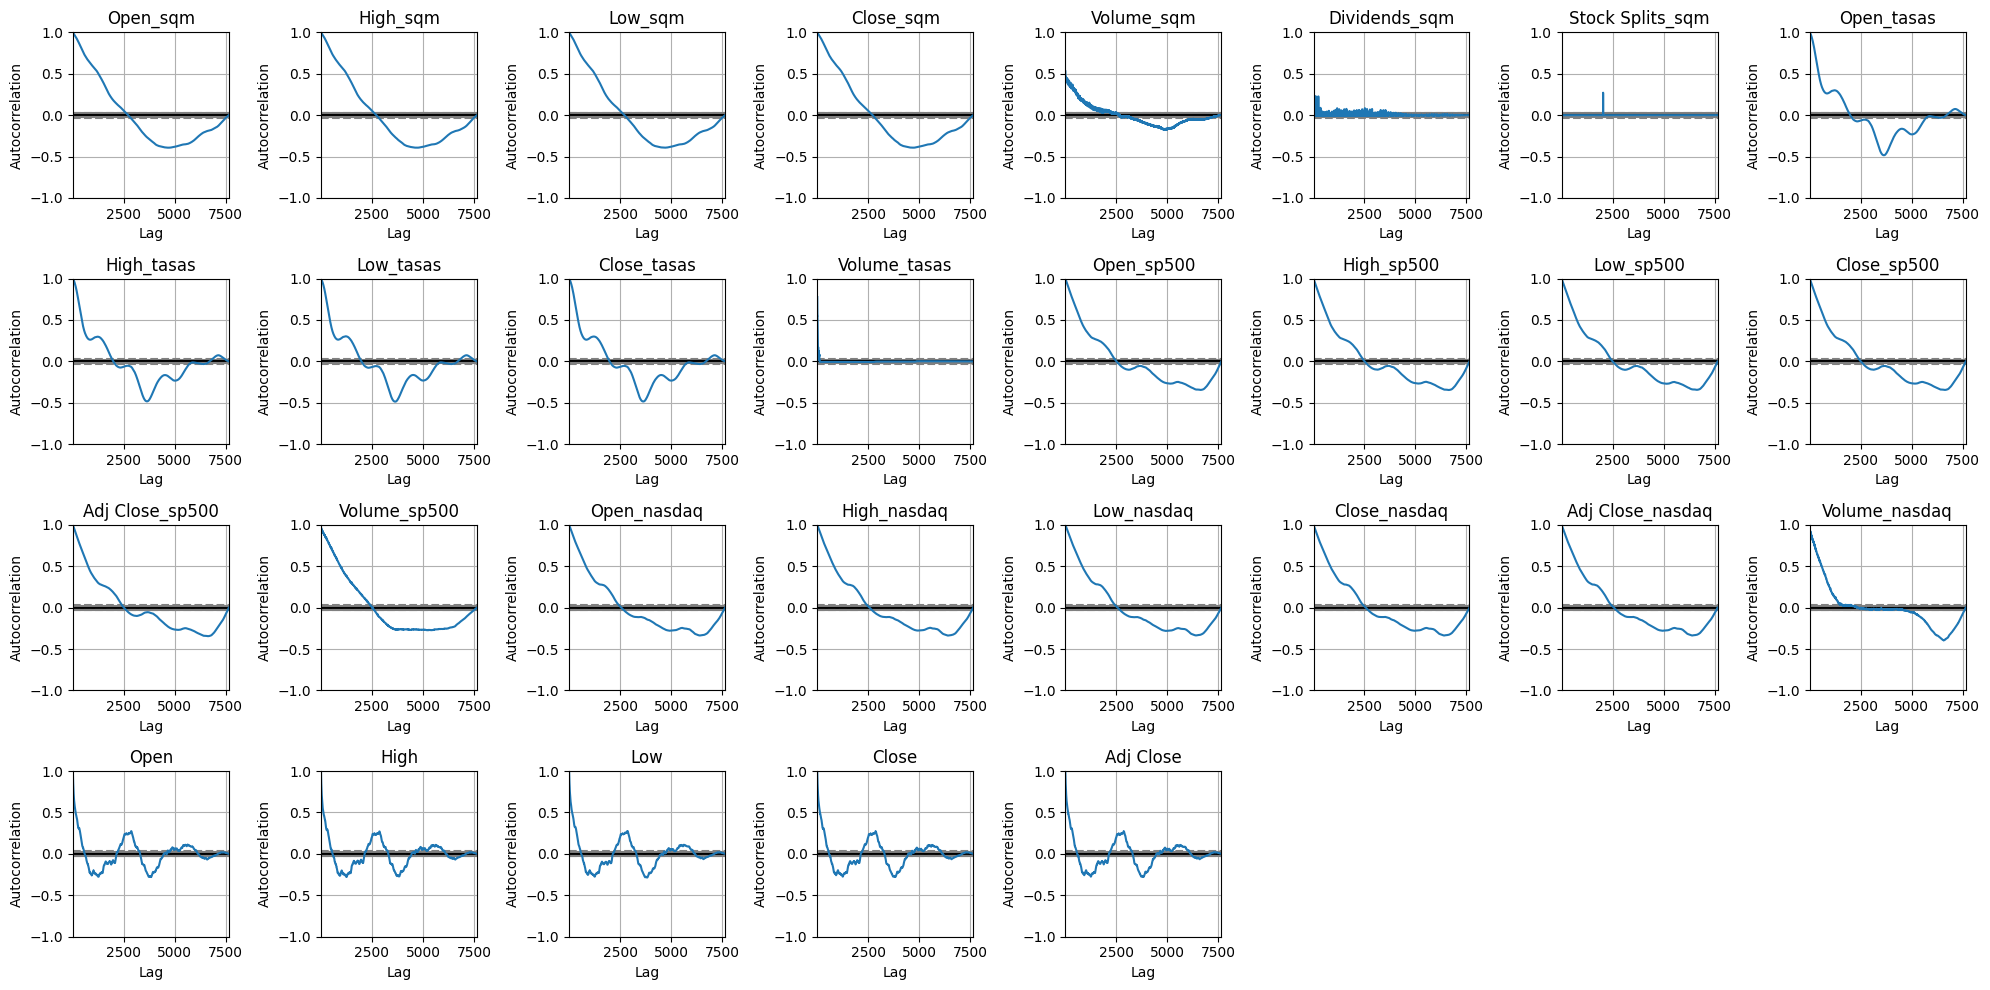

In [103]:
from pandas.plotting import autocorrelation_plot

# Lista de variables a analizar la autocorrelación
variables = ['Open_sqm', 'High_sqm', 'Low_sqm', 'Close_sqm', 'Volume_sqm',
             'Dividends_sqm', 'Stock Splits_sqm', 'Open_tasas', 'High_tasas',
             'Low_tasas', 'Close_tasas', 'Volume_tasas', 'Open_sp500',
             'High_sp500', 'Low_sp500', 'Close_sp500', 'Adj Close_sp500',
             'Volume_sp500', 'Open_nasdaq', 'High_nasdaq', 'Low_nasdaq',
             'Close_nasdaq', 'Adj Close_nasdaq', 'Volume_nasdaq', 'Open',
             'High', 'Low', 'Close', 'Adj Close']

plt.figure(figsize=(20, 10))

for i, var in enumerate(variables):
    plt.subplot(4, 8, i + 1)
    autocorrelation_plot(df[var])
    plt.title(var)

plt.tight_layout()
plt.show()


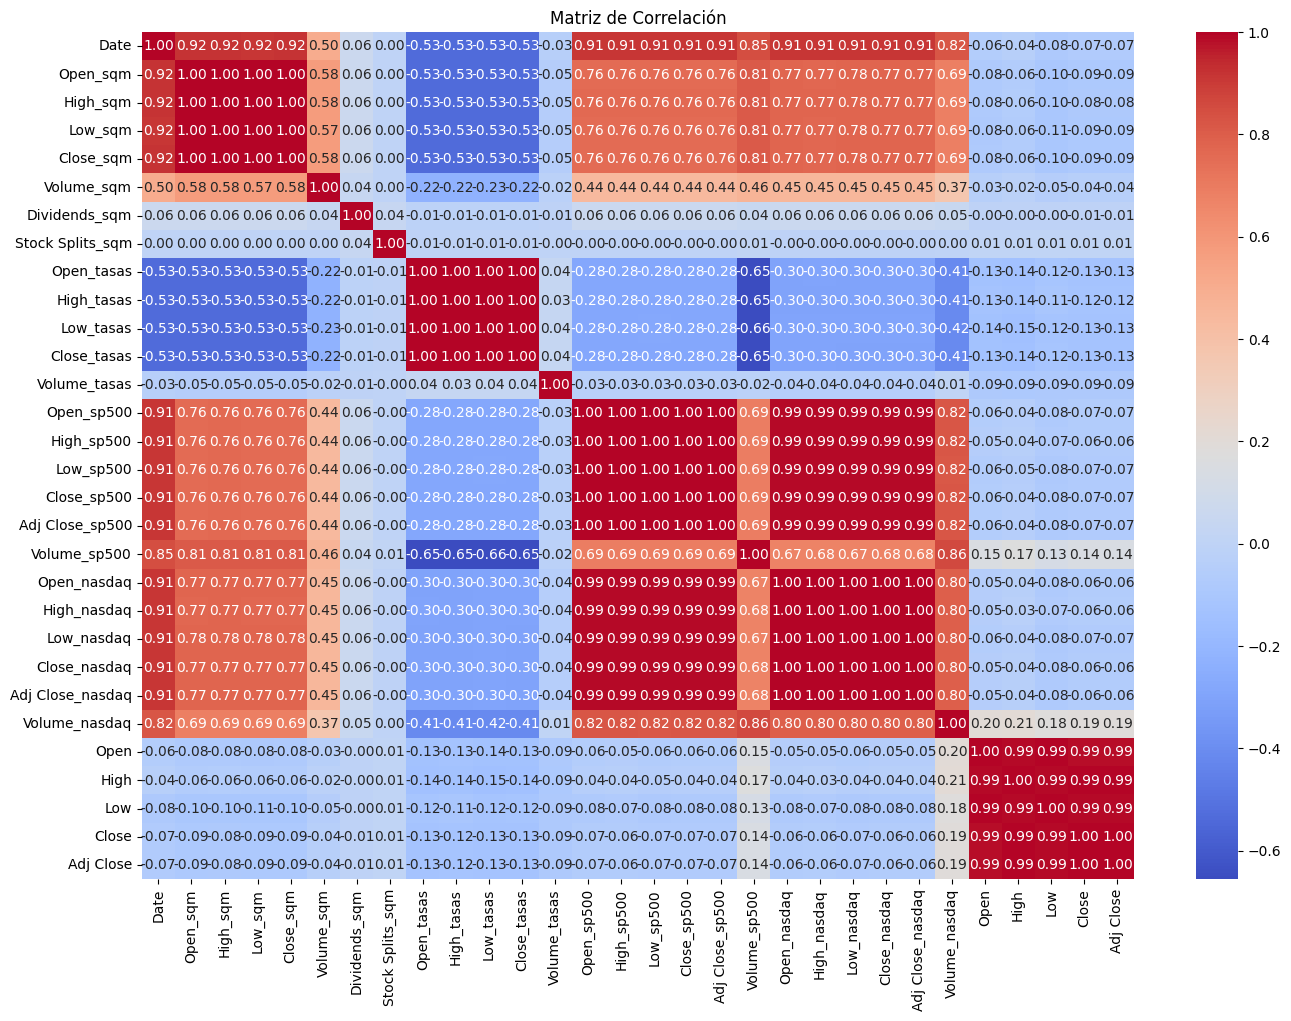

In [104]:
# Calcular la matriz de correlación
corr_matrix = df.corr()

# Crear un mapa de calor para visualizar la matriz de correlación
plt.figure(figsize=(16, 11))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

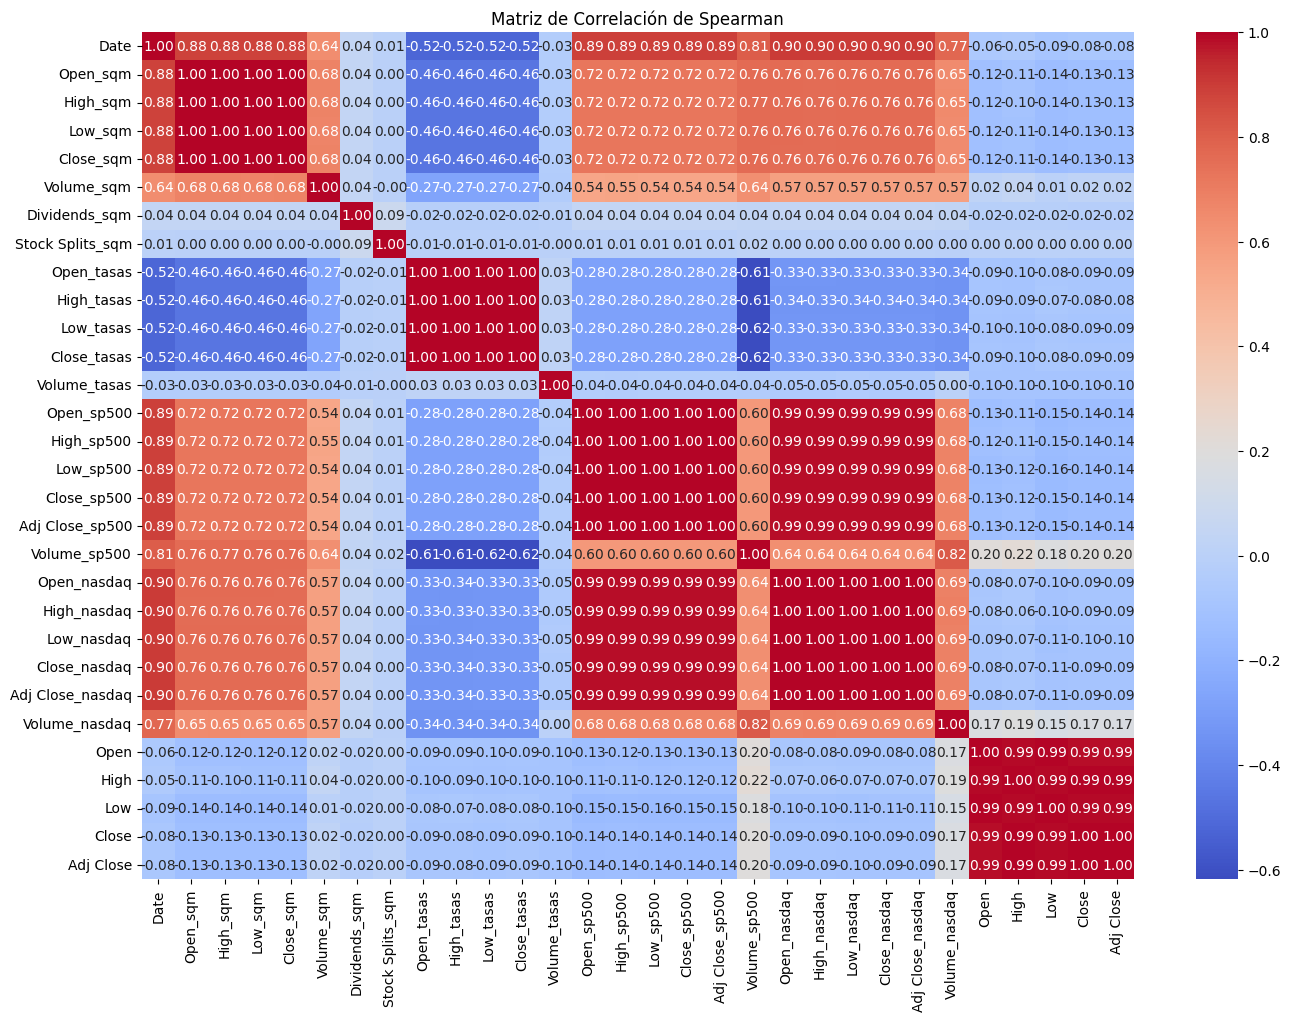

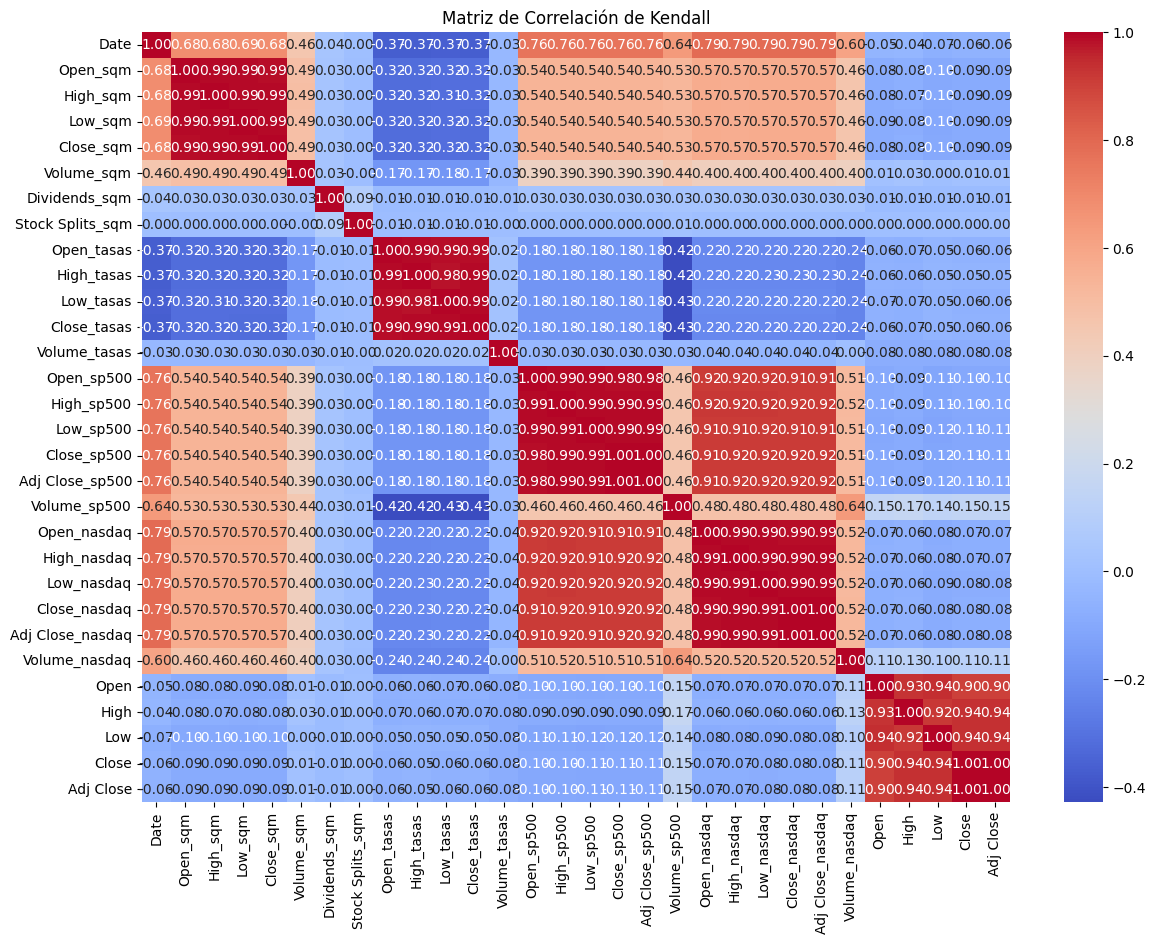

In [105]:
from scipy.stats import spearmanr, kendalltau

# Calcular el coeficiente de correlación de Spearman
spearman_corr = df.corr(method='spearman')

# Calcular el coeficiente de correlación de Kendall
kendall_corr = df.corr(method='kendall')

# Visualizar la matriz de correlación de Spearman como un mapa de calor
plt.figure(figsize=(16, 11))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de Spearman')
plt.show()

# Visualizar la matriz de correlación de Kendall como un mapa de calor
plt.figure(figsize=(14, 10))
sns.heatmap(kendall_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de Kendall')
plt.show()


In [106]:
df.head()

Date  Open_sqm  High_sqm   Low_sqm  Close_sqm  Volume_sqm  \
Date                                                                         
1994-01-03 1994-01-03  0.763947  0.775014  0.759486   0.770602   13.774945   
1994-01-04 1994-01-04  0.768389  0.768389  0.759486   0.763947   12.933336   
1994-01-05 1994-01-05  0.763947  0.768389  0.750503   0.761719   13.321278   
1994-01-06 1994-01-06  0.763947  0.763947  0.748244   0.748244   11.652905   
1994-01-07 1994-01-07  0.748244  0.748244  0.736875   0.736875   12.295694   

            Dividends_sqm  Stock Splits_sqm  Open_tasas  High_tasas  \
Date                                                                  
1994-01-03            0.0               0.0    1.388791    1.396245   
1994-01-04            0.0               0.0    1.408545    1.408545   
1994-01-05            0.0               0.0    1.406097    1.406097   
1994-01-06            0.0               0.0    1.401183    1.401183   
1994-01-07            0.0               0.0    1.396245    1.396245   

            Low_tasas  Close_tasas  Volume_tasas  Open_sp500  High_sp500  \
Date                                                                       
1994-01-03   1.388791     1.393766           0.0    6.147421    6.148340   
1994-01-04   1.403643     1.406097           0.0    6.145129    6.148233   
1994-01-05   1.401183     1.403643           0.0    6.148233    6.150219   
1994-01-06   1.396245     1.398717           0.0    6.149643    6.152733   
1994-01-07   1.388791     1.388791           0.0    6.148661    6.155410   

            Low_sp500  Close_sp500  Adj Close_sp500  Volume_sp500  \
Date                                                                
1994-01-03   6.142811     6.145129         6.145129     19.414451   
1994-01-04   6.142983     6.148233         6.148233     19.604247   
1994-01-05   6.146158     6.149643         6.149643     19.807050   
1994-01-06   6.148511     6.148725         6.148725     19.718035   
1994-01-07   6.148532     6.154646         6.154646     19.599090   

            Open_nasdaq  High_nasdaq  Low_nasdaq  Close_nasdaq  \
Date                                                             
1994-01-03     6.653005     6.657099    6.645624      6.648674   
1994-01-04     6.649541     6.653869    6.649010      6.653224   
1994-01-05     6.654449     6.658281    6.652463      6.658075   
1994-01-06     6.661036     6.662123    6.658332      6.661100   
1994-01-07     6.659666     6.664906    6.658268      6.664332   

            Adj Close_nasdaq  Volume_nasdaq      Open      High       Low  \
Date                                                                        
1994-01-03          6.648674      19.348979  2.507972  2.668616  2.507972   
1994-01-04          6.653224      19.514615  2.629728  2.629728  2.550226   
1994-01-05          6.658075      19.673101  2.523326  2.523326  2.430978   
1994-01-06          6.661100      19.671184  2.523326  2.544747  2.428336   
1994-01-07          6.664332      19.614785  2.523326  2.575661  2.397895   

               Close  Adj Close  
Date                             
1994-01-03  2.607861   2.607861  
1994-01-04  2.558002   2.558002  
1994-01-05  2.479894   2.479894  
1994-01-06  2.507157   2.507157  
1994-01-07  2.481568   2.481568

In [107]:
# Suponiendo que tu DataFrame se llame df y que 'Date' es el nombre de la columna
df.reset_index(drop=True, inplace=True)

In [108]:
# Configurar pandas para mostrar todas las columnas
pd.set_option('display.max_columns', None)

# 3- Desarrollo de modelo predictivo

## 3.1 agregacion de nuevas caracter+isticas,  escalado división de datos en training y testing

In [109]:
# Agregar componentes de la fecha como características
df['Day_of_week'] = df['Date'].dt.dayofweek  # Día de la semana (0 = lunes, 6 = domingo)
df['Month'] = df['Date'].dt.month  # Mes (1 = enero, 12 = diciembre)
df['Year'] = df['Date'].dt.year  # Año

In [110]:
df.head()

Date  Open_sqm  High_sqm   Low_sqm  Close_sqm  Volume_sqm  \
0 1994-01-03  0.763947  0.775014  0.759486   0.770602   13.774945   
1 1994-01-04  0.768389  0.768389  0.759486   0.763947   12.933336   
2 1994-01-05  0.763947  0.768389  0.750503   0.761719   13.321278   
3 1994-01-06  0.763947  0.763947  0.748244   0.748244   11.652905   
4 1994-01-07  0.748244  0.748244  0.736875   0.736875   12.295694   

   Dividends_sqm  Stock Splits_sqm  Open_tasas  High_tasas  Low_tasas  \
0            0.0               0.0    1.388791    1.396245   1.388791   
1            0.0               0.0    1.408545    1.408545   1.403643   
2            0.0               0.0    1.406097    1.406097   1.401183   
3            0.0               0.0    1.401183    1.401183   1.396245   
4            0.0               0.0    1.396245    1.396245   1.388791   

   Close_tasas  Volume_tasas  Open_sp500  High_sp500  Low_sp500  Close_sp500  \
0     1.393766           0.0    6.147421    6.148340   6.142811     6.145129   
1     1.406097           0.0    6.145129    6.148233   6.142983     6.148233   
2     1.403643           0.0    6.148233    6.150219   6.146158     6.149643   
3     1.398717           0.0    6.149643    6.152733   6.148511     6.148725   
4     1.388791           0.0    6.148661    6.155410   6.148532     6.154646   

   Adj Close_sp500  Volume_sp500  Open_nasdaq  High_nasdaq  Low_nasdaq  \
0         6.145129     19.414451     6.653005     6.657099    6.645624   
1         6.148233     19.604247     6.649541     6.653869    6.649010   
2         6.149643     19.807050     6.654449     6.658281    6.652463   
3         6.148725     19.718035     6.661036     6.662123    6.658332   
4         6.154646     19.599090     6.659666     6.664906    6.658268   

   Close_nasdaq  Adj Close_nasdaq  Volume_nasdaq      Open      High  \
0      6.648674          6.648674      19.348979  2.507972  2.668616   
1      6.653224          6.653224      19.514615  2.629728  2.629728   
2      6.658075          6.658075      19.673101  2.523326  2.523326   
3      6.661100          6.661100      19.671184  2.523326  2.544747   
4      6.664332          6.664332      19.614785  2.523326  2.575661   

        Low     Close  Adj Close  Day_of_week  Month  Year  
0  2.507972  2.607861   2.607861            0      1  1994  
1  2.550226  2.558002   2.558002            1      1  1994  
2  2.430978  2.479894   2.479894            2      1  1994  
3  2.428336  2.507157   2.507157            3      1  1994  
4  2.397895  2.481568   2.481568            4      1  1994

In [111]:
# Define las fechas de corte
end_date_2022 = '2022-12-31'
start_date_2023 = '2023-01-01'

# Crea los DataFrames basados en las fechas
df2 = df[df['Date'] >= start_date_2023]
df= df[df['Date'] <= end_date_2022]

In [112]:
df.head()

Date  Open_sqm  High_sqm   Low_sqm  Close_sqm  Volume_sqm  \
0 1994-01-03  0.763947  0.775014  0.759486   0.770602   13.774945   
1 1994-01-04  0.768389  0.768389  0.759486   0.763947   12.933336   
2 1994-01-05  0.763947  0.768389  0.750503   0.761719   13.321278   
3 1994-01-06  0.763947  0.763947  0.748244   0.748244   11.652905   
4 1994-01-07  0.748244  0.748244  0.736875   0.736875   12.295694   

   Dividends_sqm  Stock Splits_sqm  Open_tasas  High_tasas  Low_tasas  \
0            0.0               0.0    1.388791    1.396245   1.388791   
1            0.0               0.0    1.408545    1.408545   1.403643   
2            0.0               0.0    1.406097    1.406097   1.401183   
3            0.0               0.0    1.401183    1.401183   1.396245   
4            0.0               0.0    1.396245    1.396245   1.388791   

   Close_tasas  Volume_tasas  Open_sp500  High_sp500  Low_sp500  Close_sp500  \
0     1.393766           0.0    6.147421    6.148340   6.142811     6.145129   
1     1.406097           0.0    6.145129    6.148233   6.142983     6.148233   
2     1.403643           0.0    6.148233    6.150219   6.146158     6.149643   
3     1.398717           0.0    6.149643    6.152733   6.148511     6.148725   
4     1.388791           0.0    6.148661    6.155410   6.148532     6.154646   

   Adj Close_sp500  Volume_sp500  Open_nasdaq  High_nasdaq  Low_nasdaq  \
0         6.145129     19.414451     6.653005     6.657099    6.645624   
1         6.148233     19.604247     6.649541     6.653869    6.649010   
2         6.149643     19.807050     6.654449     6.658281    6.652463   
3         6.148725     19.718035     6.661036     6.662123    6.658332   
4         6.154646     19.599090     6.659666     6.664906    6.658268   

   Close_nasdaq  Adj Close_nasdaq  Volume_nasdaq      Open      High  \
0      6.648674          6.648674      19.348979  2.507972  2.668616   
1      6.653224          6.653224      19.514615  2.629728  2.629728   
2      6.658075          6.658075      19.673101  2.523326  2.523326   
3      6.661100          6.661100      19.671184  2.523326  2.544747   
4      6.664332          6.664332      19.614785  2.523326  2.575661   

        Low     Close  Adj Close  Day_of_week  Month  Year  
0  2.507972  2.607861   2.607861            0      1  1994  
1  2.550226  2.558002   2.558002            1      1  1994  
2  2.430978  2.479894   2.479894            2      1  1994  
3  2.428336  2.507157   2.507157            3      1  1994  
4  2.397895  2.481568   2.481568            4      1  1994

In [113]:
df.tail()

Date  Open_sqm  High_sqm   Low_sqm  Close_sqm  Volume_sqm  \
7297 2022-12-23  4.337025  4.341823  4.323223   4.337867   13.664340   
7298 2022-12-27  4.331116  4.331479  4.269378   4.283811   14.635423   
7299 2022-12-28  4.284825  4.296412  4.261239   4.269635   14.595019   
7300 2022-12-29  4.290635  4.307000  4.287608   4.297789   14.347491   
7301 2022-12-30  4.289123  4.318457  4.287987   4.309722   13.645553   

      Dividends_sqm  Stock Splits_sqm  Open_tasas  High_tasas  Low_tasas  \
7297            0.0               0.0    1.647697    1.650196   1.645384   
7298            0.0               0.0    1.648274    1.653072   1.639579   
7299            0.0               0.0    1.674851    1.675787   1.672976   
7300            0.0               0.0    1.673914    1.673914   1.666763   
7301            0.0               0.0    1.667329    1.667707   1.653072   

      Close_tasas  Volume_tasas  Open_sp500  High_sp500  Low_sp500  \
7297     1.647312           0.0    8.246987    8.254997   8.242233   
7298     1.647697           0.0    8.254357    8.255218   8.246491   
7299     1.674851           0.0    8.250766    8.255652   8.237950   
7300     1.666763           0.0    8.244452    8.258213   8.244452   
7301     1.660131           0.0    8.250636    8.253449   8.243109   

      Close_sp500  Adj Close_sp500  Volume_sp500  Open_nasdaq  High_nasdaq  \
7297     8.254742         8.254742     21.759747     9.253280     9.260630   
7298     8.250685         8.250685     21.831927     9.255619     9.256586   
7299     8.238595         8.238595     21.849338     9.243795     9.251081   
7300     8.255901         8.255901     21.823104     9.242077     9.259424   
7301     8.253358         8.253358     21.815146     9.246612     9.256203   

      Low_nasdaq  Close_nasdaq  Adj Close_nasdaq  Volume_nasdaq      Open  \
7297    9.245980      9.259022          9.259022      21.988714  3.142858   
7298    9.243942      9.245150          9.245150      22.065423  3.121042   
7299    9.230973      9.231543          9.231543      22.069511  3.112181   
7300    9.240099      9.257137          9.257137      22.147362  3.146305   
7301    9.242391      9.256029          9.256029      22.099265  3.128075   

          High       Low     Close  Adj Close  Day_of_week  Month  Year  
7297  3.162940  3.080992  3.085116   3.085116            4     12  2022  
7298  3.169686  3.117507  3.120160   3.120160            1     12  2022  
7299  3.146735  3.089223  3.141563   3.141563            2     12  2022  
7300  3.148882  3.107274  3.110845   3.110845            3     12  2022  
7301  3.152736  3.117507  3.121042   3.121042            4     12  2022

In [114]:
df2.head()

Date  Open_sqm  High_sqm   Low_sqm  Close_sqm  Volume_sqm  \
7302 2023-01-03  4.326509  4.331116  4.258642   4.271049   14.327736   
7303 2023-01-04  4.279108  4.292774  4.263183   4.289123   14.315316   
7304 2023-01-05  4.290131  4.304519  4.281144   4.293026   13.852036   
7305 2023-01-06  4.316495  4.319681  4.283050   4.307743   13.724930   
7306 2023-01-09  4.328815  4.364422  4.322735   4.334979   14.196205   

      Dividends_sqm  Stock Splits_sqm  Open_tasas  High_tasas  Low_tasas  \
7302            0.0               0.0    1.660131    1.660131   1.653455   
7303            0.0               0.0    1.684545    1.686399   1.682317   
7304            0.0               0.0    1.687879    1.704748   1.686399   
7305            0.0               0.0    1.706565    1.708378   1.696533   
7306            0.0               0.0    1.702928    1.705293   1.697082   

      Close_tasas  Volume_tasas  Open_sp500  High_sp500  Low_sp500  \
7302     1.659180           0.0    8.256942    8.263451   8.241527   
7303     1.686399           0.0    8.253582    8.262084   8.247160   
7304     1.704384           0.0    8.253420    8.253420   8.243656   
7305     1.703475           0.0    8.249149    8.270574   8.245531   
7306     1.701652           0.0    8.271758    8.281868   8.266529   

      Close_sp500  Adj Close_sp500  Volume_sp500  Open_nasdaq  High_nasdaq  \
7302     8.249350         8.249350     22.099293     9.265118     9.269935   
7303     8.256859         8.256859     22.208065     9.256157     9.260674   
7304     8.245148         8.245148     22.082561     9.248725     9.249005   
7305     8.267726         8.267726     22.090265     9.246186     9.269094   
7306     8.266958         8.266958     22.184614     9.274544     9.288066   

      Low_nasdaq  Close_nasdaq  Adj Close_nasdaq  Volume_nasdaq      Open  \
7302    9.240885      9.248405          9.248405      22.287842  3.181797   
7303    9.243644      9.255291          9.255291      22.349636  3.175133   
7304    9.239535      9.240505          9.240505      22.284410  3.144152   
7305    9.236597      9.265803          9.265803      22.371882  3.165053   
7306    9.270506      9.272061          9.272061      22.358798  3.124565   

          High       Low     Close  Adj Close  Day_of_week  Month  Year  
7302  3.209229  3.166740  3.173878   3.173878            1      1  2023  
7303  3.189241  3.132882  3.135929   3.135929            2      1  2023  
7304  3.174715  3.134189  3.155297   3.155297            3      1  2023  
7305  3.173878  3.091042  3.096934   3.096934            4      1  2023  
7306  3.134624  3.103241  3.134189   3.134189            0      1  2023

In [115]:
df2.tail()

Date  Open_sqm  High_sqm   Low_sqm  Close_sqm  Volume_sqm  \
7643 2024-05-13  3.875359  3.896097  3.865141   3.893859   13.495169   
7644 2024-05-14  3.901771  3.925531  3.899950   3.922171   13.916894   
7645 2024-05-15  3.932022  3.932022  3.890186   3.891412   13.949080   
7646 2024-05-16  3.892636  3.901771  3.875359   3.891208   13.686428   
7647 2024-05-17  3.889982  3.905300  3.882390   3.887730   13.135062   

      Dividends_sqm  Stock Splits_sqm  Open_tasas  High_tasas  Low_tasas  \
7643            0.0               0.0     1.83098    1.831781   1.830980   
7644            0.0               0.0     1.83098    1.831461   1.830179   
7645            0.0               0.0     1.83098    1.831461   1.830179   
7646            0.0               0.0     1.83098    1.831461   1.830660   
7647            0.0               0.0     1.83098    1.831461   1.830980   

      Close_tasas  Volume_tasas  Open_sp500  High_sp500  Low_sp500  \
7643     1.830980           0.0    8.562946    8.563745   8.558750   
7644     1.830179           0.0    8.560655    8.566244   8.560057   
7645     1.830980           0.0    8.568696    8.577867   8.568696   
7646     1.831461           0.0    8.577549    8.580448   8.574932   
7647     1.830980           0.0    8.576235    8.576678   8.572550   

      Close_sp500  Adj Close_sp500  Volume_sp500  Open_nasdaq  High_nasdaq  \
7643     8.560716         8.560716     22.171527     9.705117     9.705527   
7644     8.565541         8.565541     22.284265     9.704558     9.712767   
7645     8.577187         8.577187     22.195924     9.717287     9.726198   
7646     8.575104         8.575104     22.062854     9.725503     9.729065   
7647     8.576024         8.576024     20.933733     9.723733     9.724804   

      Low_nasdaq  Close_nasdaq  Adj Close_nasdaq  Volume_nasdaq      Open  \
7643    9.701118      9.704380          9.704380      22.216788  2.657458   
7644    9.704270      9.711854          9.711854      22.707055  2.688528   
7645    9.713845      9.725759          9.725759      22.867909  2.689886   
7646    9.722832      9.723123          9.723123      23.202540  2.604170   
7647    9.718051      9.722273          9.722273      22.816597  2.586259   

          High       Low     Close  Adj Close  Day_of_week  Month  Year  
7643  2.685123  2.656757  2.681022   2.681022            0      5  2024  
7644  2.710048  2.658159  2.668616   2.668616            1      5  2024  
7645  2.704042  2.593761  2.598979   2.598979            2      5  2024  
7646  2.615204  2.590017  2.596746   2.596746            3      5  2024  
7647  2.601207  2.559550  2.560323   2.560323            4      5  2024

In [116]:
from sklearn.preprocessing import MinMaxScaler

# Suponiendo que "df" es tu DataFrame
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df.select_dtypes(include=[np.number]))
df_scaled = pd.DataFrame(df_scaled, columns=df.select_dtypes(include=[np.number]).columns)
df = pd.concat([df['Date'], df_scaled], axis=1)

In [117]:
df.set_index('Date', inplace = True)

In [118]:
df.describe()

Open_sqm     High_sqm      Low_sqm    Close_sqm   Volume_sqm  \
count  7302.000000  7302.000000  7302.000000  7302.000000  7302.000000   
mean      0.413542     0.413286     0.413133     0.413482     0.737279   
std       0.287015     0.287630     0.287162     0.287339     0.093036   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.113421     0.112507     0.113174     0.112944     0.708395   
50%       0.460734     0.463107     0.457582     0.460656     0.755366   
75%       0.667054     0.666764     0.667374     0.666609     0.790226   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

       Dividends_sqm  Stock Splits_sqm   Open_tasas   High_tasas    Low_tasas  \
count    7302.000000       7302.000000  7302.000000  7302.000000  7302.000000   
mean        0.001802          0.000177     0.497583     0.497067     0.529256   
std         0.027359          0.012200     0.341930     0.342754     0.318988   
min         0.000000          0.000000     0.000000     0.000000     0.000000   
25%         0.000000          0.000000     0.111052     0.109224     0.167934   
50%         0.000000          0.000000     0.517415     0.517389     0.547650   
75%         0.000000          0.000000     0.873057     0.873085     0.880072   
max         1.000000          1.000000     1.000000     1.000000     1.000000   

       Close_tasas  Volume_tasas   Open_sp500   High_sp500    Low_sp500  \
count  7302.000000   7302.000000  7302.000000  7302.000000  7302.000000   
mean      0.496032      0.006149     0.491915     0.491245     0.491744   
std       0.342460      0.078099     0.226821     0.227576     0.226735   
min       0.000000      0.000000     0.000000     0.000000     0.000000   
25%       0.107415      0.000000     0.373404     0.373163     0.372895   
50%       0.516296      0.000000     0.458975     0.458719     0.459005   
75%       0.871406      0.000000     0.647995     0.647152     0.648093   
max       1.000000      1.000000     1.000000     1.000000     1.000000   

       Close_sp500  Adj Close_sp500  Volume_sp500  Open_nasdaq  High_nasdaq  \
count  7302.000000      7302.000000   7302.000000  7302.000000  7302.000000   
mean      0.492459         0.492459      0.736539     0.460594     0.460679   
std       0.226875         0.226875      0.135230     0.236441     0.236584   
min       0.000000         0.000000      0.000000     0.000000     0.000000   
25%       0.373824         0.373824      0.648535     0.311284     0.311228   
50%       0.459524         0.459524      0.795729     0.409129     0.408970   
75%       0.648641         0.648641      0.838617     0.621502     0.621087   
max       1.000000         1.000000      1.000000     1.000000     1.000000   

        Low_nasdaq  Close_nasdaq  Adj Close_nasdaq  Volume_nasdaq  \
count  7302.000000   7302.000000       7302.000000    7302.000000   
mean      0.459670      0.461218          0.461218       0.585436   
std       0.236595      0.236692          0.236692       0.139186   
min       0.000000      0.000000          0.000000       0.000000   
25%       0.309806      0.311321          0.311321       0.558544   
50%       0.407885      0.409733          0.409733       0.613041   
75%       0.621528      0.622496          0.622496       0.648907   
max       1.000000      1.000000          1.000000       1.000000   

              Open         High          Low        Close    Adj Close  \
count  7302.000000  7302.000000  7302.000000  7302.000000  7302.000000   
mean      0.321074     0.318216     0.337653     0.314824     0.314824   
std       0.161488     0.158999     0.165137     0.161752     0.161752   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.189289     0.190704     0.200911     0.183937     0.183937   
50%       0.309895     0.307060     0.326272     0.304081     0.304081   
75%       0.426290     0.419652     0.445783     0.420479     0.420479   
max       1

In [119]:
df

Open_sqm  High_sqm   Low_sqm  Close_sqm  Volume_sqm  \
Date                                                              
1994-01-03  0.055542  0.055931  0.055042   0.056617    0.799696   
1994-01-04  0.056633  0.054306  0.055042   0.054980    0.750837   
1994-01-05  0.055542  0.054306  0.052824   0.054432    0.773359   
1994-01-06  0.055542  0.053217  0.052267   0.051117    0.676503   
1994-01-07  0.051685  0.049366  0.049460   0.048321    0.713819   
...              ...       ...       ...        ...         ...   
2022-12-23  0.933171  0.930607  0.934762   0.934095    0.793275   
2022-12-27  0.931720  0.928070  0.921470   0.920798    0.849651   
2022-12-28  0.920350  0.919471  0.919461   0.917311    0.847305   
2022-12-29  0.921777  0.922067  0.925970   0.924236    0.832935   
2022-12-30  0.921405  0.924877  0.926064   0.927172    0.792185   

            Dividends_sqm  Stock Splits_sqm  Open_tasas  High_tasas  \
Date                                                                  
1994-01-03            0.0               0.0    0.719260    0.720678   
1994-01-04            0.0               0.0    0.728713    0.726582   
1994-01-05            0.0               0.0    0.727542    0.725407   
1994-01-06            0.0               0.0    0.725190    0.723048   
1994-01-07            0.0               0.0    0.722827    0.720678   
...                   ...               ...         ...         ...   
2022-12-23            0.0               0.0    0.843153    0.842559   
2022-12-27            0.0               0.0    0.843429    0.843940   
2022-12-28            0.0               0.0    0.856147    0.854842   
2022-12-29            0.0               0.0    0.855699    0.853943   
2022-12-30            0.0               0.0    0.852548    0.850964   

            Low_tasas  Close_tasas  Volume_tasas  Open_sp500  High_sp500  \
Date                                                                       
1994-01-03   0.738481     0.720714           0.0    0.025237    0.020434   
1994-01-04   0.745102     0.726621           0.0    0.024279    0.020389   
1994-01-05   0.744005     0.725445           0.0    0.025577    0.021223   
1994-01-06   0.741804     0.723086           0.0    0.026167    0.022279   
1994-01-07   0.738481     0.718332           0.0    0.025756    0.023404   
...               ...          ...           ...         ...         ...   
2022-12-23   0.852861     0.842157           0.0    0.903560    0.905302   
2022-12-27   0.850273     0.842341           0.0    0.906644    0.905395   
2022-12-28   0.865160     0.855347           0.0    0.905142    0.905577   
2022-12-29   0.862391     0.851473           0.0    0.902500    0.906653   
2022-12-30   0.856288     0.848297           0.0    0.905087    0.904652   

            Low_sp500  Close_sp500  Adj Close_sp500  Volume_sp500  \
Date                                                                
1994-01-03   0.026412     0.024500         0.024500      0.435547   
1994-01-04   0.026484     0.025799         0.025799      0.464136   
1994-01-05   0.027811     0.026389         0.026389      0.494683   
1994-01-06   0.028794     0.026004         0.026004      0.481275   
1994-01-07   0.028803     0.028483         0.028483      0.463359   
...               ...          ...              ...           ...   
2022-12-23   0.903803     0.907453         0.907453      0.788813   
2022-12-27   0.905583     0.905755         0.905755      0.799685   
2022-12-28   0.902013     0.900694         0.900694      0.802307   
2022-12-29   0.904730     0.907938         0.907938      0.798356   
2022-12-30   0.904169     0.906873         0.906873      0.797157   

            Open_nasdaq  High_nasdaq  Low_nasdaq  Close_nasdaq  \
Date                                                             
1994-01-03     0.034628     0.033395    0.033772      0.033456   
1994-01-04     0.033526     0.032366    0.034850      0.034905   
1994-01-05     0.035087     0.033771    0.035949      0.036450   

In [120]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Suponiendo que df es tu DataFrame con todas las características y la columna 'Close_sqm' a predecir
X = df.drop(columns=['Close_sqm'])  # Características, excluyendo 'Date' y 'Close_sqm'
y = df['Close_sqm']  # Variable a predecir

In [121]:
X.shape, y.shape

((7302, 31), (7302,))

In [122]:
X.head()

Open_sqm  High_sqm   Low_sqm  Volume_sqm  Dividends_sqm  \
Date                                                                  
1994-01-03  0.055542  0.055931  0.055042    0.799696            0.0   
1994-01-04  0.056633  0.054306  0.055042    0.750837            0.0   
1994-01-05  0.055542  0.054306  0.052824    0.773359            0.0   
1994-01-06  0.055542  0.053217  0.052267    0.676503            0.0   
1994-01-07  0.051685  0.049366  0.049460    0.713819            0.0   

            Stock Splits_sqm  Open_tasas  High_tasas  Low_tasas  Close_tasas  \
Date                                                                           
1994-01-03               0.0    0.719260    0.720678   0.738481     0.720714   
1994-01-04               0.0    0.728713    0.726582   0.745102     0.726621   
1994-01-05               0.0    0.727542    0.725407   0.744005     0.725445   
1994-01-06               0.0    0.725190    0.723048   0.741804     0.723086   
1994-01-07               0.0    0.722827    0.720678   0.738481     0.718332   

            Volume_tasas  Open_sp500  High_sp500  Low_sp500  Close_sp500  \
Date                                                                       
1994-01-03           0.0    0.025237    0.020434   0.026412     0.024500   
1994-01-04           0.0    0.024279    0.020389   0.026484     0.025799   
1994-01-05           0.0    0.025577    0.021223   0.027811     0.026389   
1994-01-06           0.0    0.026167    0.022279   0.028794     0.026004   
1994-01-07           0.0    0.025756    0.023404   0.028803     0.028483   

            Adj Close_sp500  Volume_sp500  Open_nasdaq  High_nasdaq  \
Date                                                                  
1994-01-03         0.024500      0.435547     0.034628     0.033395   
1994-01-04         0.025799      0.464136     0.033526     0.032366   
1994-01-05         0.026389      0.494683     0.035087     0.033771   
1994-01-06         0.026004      0.481275     0.037182     0.034994   
1994-01-07         0.028483      0.463359     0.036747     0.035880   

            Low_nasdaq  Close_nasdaq  Adj Close_nasdaq  Volume_nasdaq  \
Date                                                                    
1994-01-03    0.033772      0.033456          0.033456       0.197605   
1994-01-04    0.034850      0.034905          0.034905       0.232332   
1994-01-05    0.035949      0.036450          0.036450       0.265560   
1994-01-06    0.037816      0.037413          0.037413       0.265158   
1994-01-07    0.037796      0.038442          0.038442       0.253334   

                Open      High       Low     Close  Adj Close  Day_of_week  \
Date                                                                         
1994-01-03  0.096249  0.154426  0.122543  0.138050   0.138050         0.00   
1994-01-04  0.153585  0.136527  0.143223  0.114427   0.114427         0.25   
1994-01-05  0.103479  0.087551  0.084861  0.077420   0.077420         0.50   
1994-01-06  0.103479  0.097411  0.083568  0.090338   0.090338         0.75   
1994-01-07  0.103479  0.111641  0.068669  0.078213   0.078213         1.00   

            Month  Year  
Date                     
1994-01-03    0.0   0.0  
1994-01-04    0.0   0.0  
1994-01-05    0.0   0.0  
1994-01-06    0.0   0.0  
1994-01-07    0.0   0.0

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle = False)

In [124]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5841, 31), (1461, 31), (5841,), (1461,))

In [125]:
X_test.head()

Open_sqm  High_sqm   Low_sqm  Volume_sqm  Dividends_sqm  \
Date                                                                  
2017-03-15  0.652096  0.651350  0.654038    0.734896            0.0   
2017-03-16  0.656184  0.654490  0.656542    0.755630            0.0   
2017-03-17  0.652664  0.656974  0.656114    0.797078            0.0   
2017-03-20  0.656743  0.655528  0.659654    0.765128            0.0   
2017-03-21  0.657717  0.655390  0.655757    0.784090            0.0   

            Stock Splits_sqm  Open_tasas  High_tasas  Low_tasas  Close_tasas  \
Date                                                                           
2017-03-15               0.0    0.322480    0.319970   0.359861     0.311500   
2017-03-16               0.0    0.308609    0.311685   0.355945     0.309541   
2017-03-17               0.0    0.311415    0.310291   0.357254     0.309541   
2017-03-20               0.0    0.310855    0.308892   0.358037     0.310101   
2017-03-21               0.0    0.324662    0.321337   0.369630     0.321997   

            Volume_tasas  Open_sp500  High_sp500  Low_sp500  Close_sp500  \
Date                                                                       
2017-03-15           0.0    0.704526    0.705565   0.706706     0.707701   
2017-03-16           0.0    0.707579    0.705229   0.708157     0.707020   
2017-03-17           0.0    0.706878    0.704809   0.708238     0.706470   
2017-03-20           0.0    0.705918    0.703723   0.706833     0.705628   
2017-03-21           0.0    0.706107    0.704143   0.701911     0.700405   

            Adj Close_sp500  Volume_sp500  Open_nasdaq  High_nasdaq  \
Date                                                                  
2017-03-15         0.707701      0.838057     0.678682     0.678865   
2017-03-16         0.707020      0.815639     0.680727     0.678880   
2017-03-17         0.706470      0.880438     0.680227     0.678941   
2017-03-20         0.705628      0.801231     0.680240     0.679076   
2017-03-21         0.700405      0.851656     0.681564     0.679772   

            Low_nasdaq  Close_nasdaq  Adj Close_nasdaq  Volume_nasdaq  \
Date                                                                    
2017-03-15    0.679907      0.681216          0.681216       0.626336   
2017-03-16    0.681483      0.681254          0.681254       0.605526   
2017-03-17    0.681655      0.681267          0.681267       0.728947   
2017-03-20    0.681531      0.681295          0.681295       0.601479   
2017-03-21    0.676223      0.675432          0.675432       0.651039   

                Open      High       Low     Close  Adj Close  Day_of_week  \
Date                                                                         
2017-03-15  0.127407  0.115478  0.094663  0.104038   0.104038         0.50   
2017-03-16  0.096632  0.090495  0.117737  0.088015   0.088015         0.75   
2017-03-17  0.100068  0.084217  0.102199  0.090723   0.090723         1.00   
2017-03-20  0.112456  0.096688  0.112477  0.093033   0.093033         0.00   
2017-03-21  0.091237  0.135863  0.107981  0.134546   0.134546         0.25   

               Month      Year  
Date                            
2017-03-15  0.181818  0.821429  
2017-03-16  0.181818  0.821429  
2017-03-17  0.181818  0.821429  
2017-03-20  0.181818  0.821429  
2017-03-21  0.181818  0.821429

## 3.2  Modelos de Regresión

In [126]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor


# 2. Definir un diccionario para almacenar los modelos y resultados
modelos = {
    "Regresión lineal": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "SVM": SVR(kernel='rbf'),
    "XGBoost": XGBRegressor()
}

# 3. Entrenar los modelos, hacer predicciones y evaluar rendimiento
resultados = {}
for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred_train = modelo.predict(X_train)
    y_pred_test = modelo.predict(X_test)

    mse_train = mean_squared_error(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)

    mse_test = mean_squared_error(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)

    resultados[nombre] = {
        "MSE_entrenamiento": mse_train,
        "MAE_entrenamiento": mae_train,
        "R2_entrenamiento": r2_train,
        "MSE_prueba": mse_test,
        "MAE_prueba": mae_test,
        "R2_prueba": r2_test
    }

# 4. Imprimir los resultados de forma organizada
print("-------------------------")
print("Comparación de modelos de regresión")
print("-------------------------")
for nombre, resultados_modelo in resultados.items():
    print(f"\n{nombre}:")
    print(f"  MSE entrenamiento: {resultados_modelo['MSE_entrenamiento']}")
    print(f"  MAE entrenamiento: {resultados_modelo['MAE_entrenamiento']}")
    print(f"  R2 entrenamiento: {resultados_modelo['R2_entrenamiento']}")
    print(f"  MSE prueba: {resultados_modelo['MSE_prueba']}")
    print(f"  MAE prueba: {resultados_modelo['MAE_prueba']}")
    print(f"  R2 prueba: {resultados_modelo['R2_prueba']}")


-------------------------
Comparación de modelos de regresión
-------------------------

Regresión lineal:
  MSE entrenamiento: 2.7301498084764054e-06
  MAE entrenamiento: 0.0010832139729481458
  R2 entrenamiento: 0.9999573292112451
  MSE prueba: 5.7275479758990804e-06
  MAE prueba: 0.0018473455837358598
  R2 prueba: 0.9994530739578104

Random Forest:
  MSE entrenamiento: 7.389891340114528e-07
  MAE entrenamiento: 0.0005283686630529732
  R2 entrenamiento: 0.999988449993062
  MSE prueba: 0.0055974246164814875
  MAE prueba: 0.03937632981000668
  R2 prueba: 0.46549949387961354

KNN:
  MSE entrenamiento: 7.35232355148056e-05
  MAE entrenamiento: 0.0060054227063739
  R2 entrenamiento: 0.9988508709516662
  MSE prueba: 0.03069980568442779
  MAE prueba: 0.14319405916731817
  R2 prueba: -1.9315377696750162

SVM:
  MSE entrenamiento: 0.0029892094454129015
  MAE entrenamiento: 0.047543561679314936
  R2 entrenamiento: 0.9532802469691909
  MSE prueba: 0.09345310514807033
  MAE prueba: 0.27688986438

## 3.3 Validación Cruzada Modelo de Regresión Lineal

In [127]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

np.random.seed(42)

X_valores = X.values
y_valores = y.values

tscv = TimeSeriesSplit(n_splits=10)
losses, maes, mses, r2s = [], [], [], []
for train_index, test_index in tscv.split(X_valores):
    # Dividir conjuntos de entrenamiento y prueba
    X_train, X_test = X_valores[train_index], X_valores[test_index]
    y_train, y_test = y_valores[train_index], y_valores[test_index]

    # Crear e entrenar el modelo de regresión lineal
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Hacer predicciones y evaluar métricas
    y_pred = model.predict(X_test)
    loss = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Almacenar métricas
    losses.append(loss)
    maes.append(mae)
    mses.append(mse)
    r2s.append(r2)

    # Cáclulo de métricas promedio
    loss_avg = np.mean(losses)
    mae_avg = np.mean(maes)
    mse_avg = np.mean(mses)
    r2_avg = np.mean(r2s)

print(f'Loss promedio: {loss_avg}')
print(f'MAE promedio: {mae_avg}')
print(f'MSE promedio: {mse_avg}')
print(f'R2 promedio: {r2_avg}')

Loss promedio: 3.937111580181014e-06
MAE promedio: 0.0012961672768814815
MSE promedio: 3.937111580181014e-06
R2 promedio: 0.9991801598976331


## 3.3 Redes Neuronales Multi layer Perceptrón

In [128]:
# 6. Red Neuronal Multi Layer Perceptrón
# Importar las librerías necesarias
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

print('--------------------------')
model_nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)
])
model_nn.compile(optimizer='adam', loss='mse')
model_nn.fit(X_train, y_train, epochs=10, verbose=1)  # Puedes ajustar el número de épocas según sea necesario

# Predicciones en el conjunto de entrenamiento
y_pred_train_nn = model_nn.predict(X_train).reshape(-1)

# Métricas en el conjunto de entrenamiento
mse_train_nn = mean_squared_error(y_train, y_pred_train_nn)
mae_train_nn = mean_absolute_error(y_train, y_pred_train_nn)
r2_train_nn = r2_score(y_train, y_pred_train_nn)

# Imprimir métricas de la Red Neuronal en entrenamiento
print("Red Neuronal (Entrenamiento):")
print("MSE:", mse_train_nn)
print("MAE:", mae_train_nn)
print("R2:", r2_train_nn)

# Predicciones en el conjunto de prueba
y_pred_test_nn = model_nn.predict(X_test).reshape(-1)

# Métricas en el conjunto de prueba
mse_test_nn = mean_squared_error(y_test, y_pred_test_nn)
mae_test_nn = mean_absolute_error(y_test, y_pred_test_nn)
r2_test_nn = r2_score(y_test, y_pred_test_nn)

# Imprimir métricas de la Red Neuronal en prueba
print("Red Neuronal (Prueba):")
print("MSE:", mse_test_nn)
print("MAE:", mae_test_nn)
print("R2:", r2_test_nn)

--------------------------
Epoch 1/10
208/208 [==============================] - 1s 2ms/step - loss: 0.0075
Epoch 2/10
208/208 [==============================] - 0s 2ms/step - loss: 1.0499e-04
Epoch 3/10
208/208 [==============================] - 0s 2ms/step - loss: 7.8116e-05
Epoch 4/10
208/208 [==============================] - 0s 2ms/step - loss: 5.7337e-05
Epoch 5/10
208/208 [==============================] - 0s 2ms/step - loss: 5.3522e-05
Epoch 6/10
208/208 [==============================] - 0s 2ms/step - loss: 4.8882e-05
Epoch 7/10
208/208 [==============================] - 0s 2ms/step - loss: 4.1881e-05
Epoch 8/10
208/208 [==============================] - 0s 2ms/step - loss: 4.5640e-05
Epoch 9/10
208/208 [==============================] - 0s 2ms/step - loss: 4.0584e-05
Epoch 10/10
208/208 [==============================] - 1s 2ms/step
Red Neuronal (Entrenamiento):
MSE: 4.5762771005080337e-05
MAE: 0.005509926523383118
R2: 0.9993604592596812
21/21 [==============================]

In [129]:
model_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2048      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6273 (24.50 KB)
Trainable params: 6273 (24.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


21/21 [==============================] - 0s 3ms/step


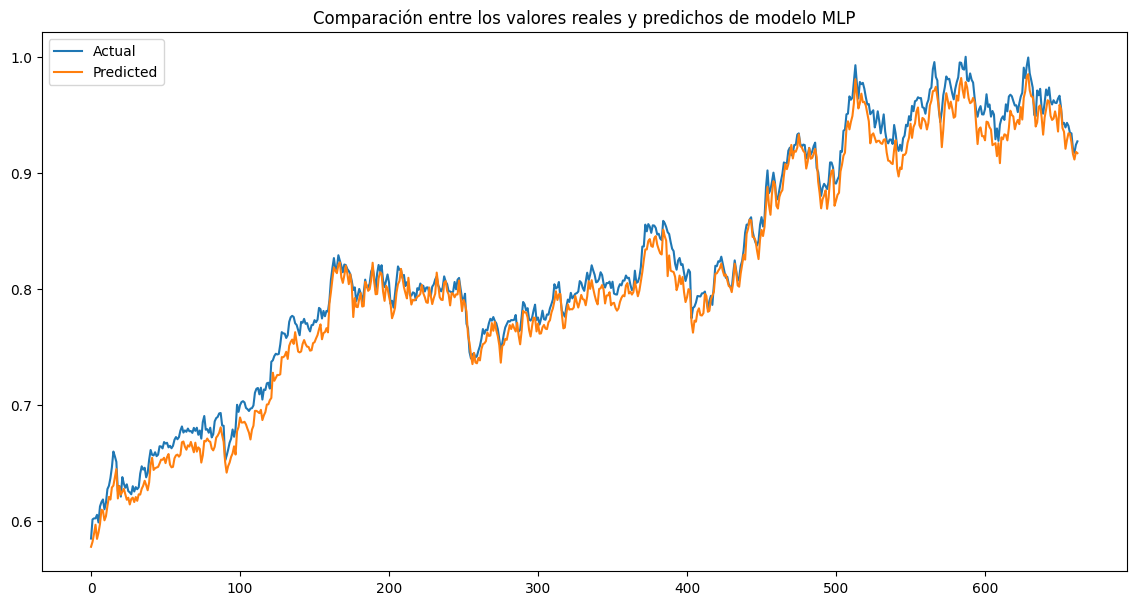

In [131]:
import matplotlib.pyplot as plt

y_pred_test_nn= model_nn.predict(X_test).reshape(-1)

# Visualización de resultados
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual')
plt.plot(y_pred_test_nn, label='Predicted')
plt.title('Comparación entre los valores reales y predichos de modelo MLP')
plt.legend()
plt.show()

## 3.4 Cross Validation Redes Neuronales Multi Layer Perceptrón

In [132]:
X.head()

Open_sqm  High_sqm   Low_sqm  Volume_sqm  Dividends_sqm  \
Date                                                                  
1994-01-03  0.055542  0.055931  0.055042    0.799696            0.0   
1994-01-04  0.056633  0.054306  0.055042    0.750837            0.0   
1994-01-05  0.055542  0.054306  0.052824    0.773359            0.0   
1994-01-06  0.055542  0.053217  0.052267    0.676503            0.0   
1994-01-07  0.051685  0.049366  0.049460    0.713819            0.0   

            Stock Splits_sqm  Open_tasas  High_tasas  Low_tasas  Close_tasas  \
Date                                                                           
1994-01-03               0.0    0.719260    0.720678   0.738481     0.720714   
1994-01-04               0.0    0.728713    0.726582   0.745102     0.726621   
1994-01-05               0.0    0.727542    0.725407   0.744005     0.725445   
1994-01-06               0.0    0.725190    0.723048   0.741804     0.723086   
1994-01-07               0.0    0.722827    0.720678   0.738481     0.718332   

            Volume_tasas  Open_sp500  High_sp500  Low_sp500  Close_sp500  \
Date                                                                       
1994-01-03           0.0    0.025237    0.020434   0.026412     0.024500   
1994-01-04           0.0    0.024279    0.020389   0.026484     0.025799   
1994-01-05           0.0    0.025577    0.021223   0.027811     0.026389   
1994-01-06           0.0    0.026167    0.022279   0.028794     0.026004   
1994-01-07           0.0    0.025756    0.023404   0.028803     0.028483   

            Adj Close_sp500  Volume_sp500  Open_nasdaq  High_nasdaq  \
Date                                                                  
1994-01-03         0.024500      0.435547     0.034628     0.033395   
1994-01-04         0.025799      0.464136     0.033526     0.032366   
1994-01-05         0.026389      0.494683     0.035087     0.033771   
1994-01-06         0.026004      0.481275     0.037182     0.034994   
1994-01-07         0.028483      0.463359     0.036747     0.035880   

            Low_nasdaq  Close_nasdaq  Adj Close_nasdaq  Volume_nasdaq  \
Date                                                                    
1994-01-03    0.033772      0.033456          0.033456       0.197605   
1994-01-04    0.034850      0.034905          0.034905       0.232332   
1994-01-05    0.035949      0.036450          0.036450       0.265560   
1994-01-06    0.037816      0.037413          0.037413       0.265158   
1994-01-07    0.037796      0.038442          0.038442       0.253334   

                Open      High       Low     Close  Adj Close  Day_of_week  \
Date                                                                         
1994-01-03  0.096249  0.154426  0.122543  0.138050   0.138050         0.00   
1994-01-04  0.153585  0.136527  0.143223  0.114427   0.114427         0.25   
1994-01-05  0.103479  0.087551  0.084861  0.077420   0.077420         0.50   
1994-01-06  0.103479  0.097411  0.083568  0.090338   0.090338         0.75   
1994-01-07  0.103479  0.111641  0.068669  0.078213   0.078213         1.00   

            Month  Year  
Date                     
1994-01-03    0.0   0.0  
1994-01-04    0.0   0.0  
1994-01-05    0.0   0.0  
1994-01-06    0.0   0.0  
1994-01-07    0.0   0.0

In [133]:
y.head()

Date
1994-01-03    0.056617
1994-01-04    0.054980
1994-01-05    0.054432
1994-01-06    0.051117
1994-01-07    0.048321
Name: Close_sqm, dtype: float64

In [134]:
X = X.values
y = y.values

In [135]:
print(X, y)

[[0.05554169 0.05593077 0.05504174 ... 0.         0.         0.        ]
 [0.05663261 0.05430599 0.05504174 ... 0.25       0.         0.        ]
 [0.05554169 0.05430599 0.05282424 ... 0.5        0.         0.        ]
 ...
 [0.92034981 0.91947082 0.91946103 ... 0.5        1.         1.        ]
 [0.92177696 0.92206719 0.92597019 ... 0.75       1.         1.        ]
 [0.92140549 0.92487684 0.92606376 ... 1.         1.         1.        ]] [0.05661689 0.05497989 0.05443177 ... 0.91731118 0.92423645 0.92717186]


In [138]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Fijar semillas para reproducibilidad
np.random.seed(0)
tf.random.set_seed(0)

# Asegúrate de que X e y estén definidos antes de este punto y no cambien.
# Por ejemplo:
# X, y = some_preprocessed_data_function()

# Guarda una copia de X e y para verificar si cambian
X_initial = X.copy()
y_initial = y.copy()

# Creando el objeto TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

# Inicializando listas para almacenar las métricas
losses, maes, mses, r2s = [], [], [], []
histories = []

# Entrenamiento y evaluación del modelo utilizando validación cruzada
for train_index, test_index in tscv.split(X):
    # Verifica que X e y no cambien
    assert np.array_equal(X, X_initial), "X ha cambiado durante la ejecución"
    assert np.array_equal(y, y_initial), "y ha cambiado durante la ejecución"

    # Dividiendo X en conjuntos de entrenamiento y prueba usando los índices generados
    X_train_cv, X_test_cv = X[train_index], X[test_index]
    # Dividiendo y en conjuntos de entrenamiento y prueba usando los mismos índices
    y_train_cv, y_test_cv = y[train_index], y[test_index]

    # Define el modelo MLP
    model_nn = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_cv.shape[1],)),
        Dense(64, activation='relu'),
        Dense(1)
    ])

    # Compila el modelo
    model_nn.compile(optimizer='adam', loss='mse')

    # Entrena el modelo y guarda el historial
    history = model_nn.fit(X_train_cv, y_train_cv, epochs=10, verbose=1, validation_data=(X_test_cv, y_test_cv))  # Puedes ajustar el número de épocas según sea necesario
    histories.append(history)

    # Evalúa el modelo en el conjunto de prueba
    loss = model_nn.evaluate(X_test_cv, y_test_cv, verbose=0)
    y_pred_cv = model_nn.predict(X_test_cv).reshape(-1)
    mae = mean_absolute_error(y_test_cv, y_pred_cv)
    mse = mean_squared_error(y_test_cv, y_pred_cv)
    r2 = r2_score(y_test_cv, y_pred_cv)

    # Guardar las métricas del fold actual
    losses.append(loss)
    maes.append(mae)
    mses.append(mse)
    r2s.append(r2)

# Calcular las métricas promedio
loss_avg = np.mean(losses)
mae_avg = np.mean(maes)
mse_avg = np.mean(mses)
r2_avg = np.mean(r2s)

print(f'Average Loss: {loss_avg}')
print(f'Average MAE: {mae_avg}')
print(f'Average MSE: {mse_avg}')
print(f'Average R2: {r2_avg}')



Epoch 1/10
58/58 [==============================] - 2s 11ms/step - loss: 0.0062 - val_loss: 0.0698
Epoch 2/10
58/58 [==============================] - 0s 6ms/step - loss: 7.8745e-04 - val_loss: 0.0337
Epoch 3/10
58/58 [==============================] - 0s 6ms/step - loss: 1.7015e-04 - val_loss: 0.0276
Epoch 4/10
58/58 [==============================] - 0s 3ms/step - loss: 8.0334e-05 - val_loss: 0.0221
Epoch 5/10
58/58 [==============================] - 0s 4ms/step - loss: 6.6703e-05 - val_loss: 0.0216
Epoch 6/10
58/58 [==============================] - 0s 5ms/step - loss: 4.2407e-05 - val_loss: 0.0170
Epoch 7/10
58/58 [==============================] - 0s 4ms/step - loss: 3.2858e-05 - val_loss: 0.0163
Epoch 8/10
58/58 [==============================] - 0s 5ms/step - loss: 2.5525e-05 - val_loss: 0.0153
Epoch 9/10
58/58 [==============================] - 0s 4ms/step - loss: 1.9374e-05 - val_loss: 0.0147
Epoch 10/10
58/58 [==============================] - 0s 1ms/step
Epoch 1/10
115/115 [

In [139]:
X_train_cv.shape

(5477, 31)

In [140]:
X_train_cv.shape[1]

31

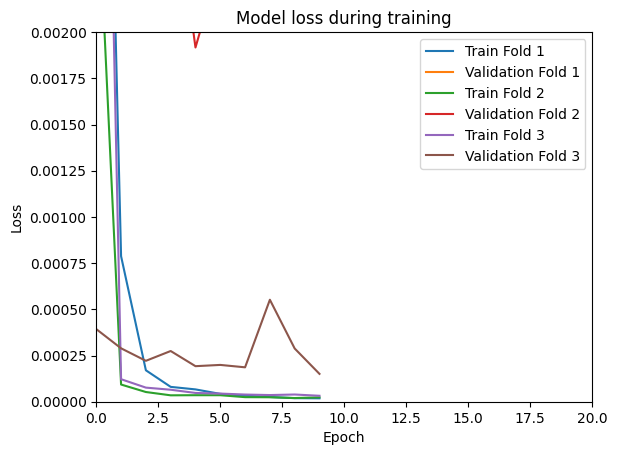

In [141]:
# Graficar el historial de entrenamiento
for i, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f'Train Fold {i+1}')
    plt.plot(history.history['val_loss'], label=f'Validation Fold {i+1}')

plt.title('Model loss during training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0, 0.002)  # Ajustar los límites del eje Y
plt.xlim(0, 20)  # Ajustar los límites del eje X
plt.legend(loc='upper right')
plt.show()

## 3.5 Redes Neuronales Recurrentes LSTM

In [142]:
close_sqm_column = df.pop('Close_sqm')  # Extrae la columna Close_sqm
df.insert(0, 'Close_sqm', close_sqm_column)  # Inserta la columna Close_sqm en la primera posición

In [143]:
df

Close_sqm  Open_sqm  High_sqm   Low_sqm  Volume_sqm  \
Date                                                              
1994-01-03   0.056617  0.055542  0.055931  0.055042    0.799696   
1994-01-04   0.054980  0.056633  0.054306  0.055042    0.750837   
1994-01-05   0.054432  0.055542  0.054306  0.052824    0.773359   
1994-01-06   0.051117  0.055542  0.053217  0.052267    0.676503   
1994-01-07   0.048321  0.051685  0.049366  0.049460    0.713819   
...               ...       ...       ...       ...         ...   
2022-12-23   0.934095  0.933171  0.930607  0.934762    0.793275   
2022-12-27   0.920798  0.931720  0.928070  0.921470    0.849651   
2022-12-28   0.917311  0.920350  0.919471  0.919461    0.847305   
2022-12-29   0.924236  0.921777  0.922067  0.925970    0.832935   
2022-12-30   0.927172  0.921405  0.924877  0.926064    0.792185   

            Dividends_sqm  Stock Splits_sqm  Open_tasas  High_tasas  \
Date                                                                  
1994-01-03            0.0               0.0    0.719260    0.720678   
1994-01-04            0.0               0.0    0.728713    0.726582   
1994-01-05            0.0               0.0    0.727542    0.725407   
1994-01-06            0.0               0.0    0.725190    0.723048   
1994-01-07            0.0               0.0    0.722827    0.720678   
...                   ...               ...         ...         ...   
2022-12-23            0.0               0.0    0.843153    0.842559   
2022-12-27            0.0               0.0    0.843429    0.843940   
2022-12-28            0.0               0.0    0.856147    0.854842   
2022-12-29            0.0               0.0    0.855699    0.853943   
2022-12-30            0.0               0.0    0.852548    0.850964   

            Low_tasas  Close_tasas  Volume_tasas  Open_sp500  High_sp500  \
Date                                                                       
1994-01-03   0.738481     0.720714           0.0    0.025237    0.020434   
1994-01-04   0.745102     0.726621           0.0    0.024279    0.020389   
1994-01-05   0.744005     0.725445           0.0    0.025577    0.021223   
1994-01-06   0.741804     0.723086           0.0    0.026167    0.022279   
1994-01-07   0.738481     0.718332           0.0    0.025756    0.023404   
...               ...          ...           ...         ...         ...   
2022-12-23   0.852861     0.842157           0.0    0.903560    0.905302   
2022-12-27   0.850273     0.842341           0.0    0.906644    0.905395   
2022-12-28   0.865160     0.855347           0.0    0.905142    0.905577   
2022-12-29   0.862391     0.851473           0.0    0.902500    0.906653   
2022-12-30   0.856288     0.848297           0.0    0.905087    0.904652   

            Low_sp500  Close_sp500  Adj Close_sp500  Volume_sp500  \
Date                                                                
1994-01-03   0.026412     0.024500         0.024500      0.435547   
1994-01-04   0.026484     0.025799         0.025799      0.464136   
1994-01-05   0.027811     0.026389         0.026389      0.494683   
1994-01-06   0.028794     0.026004         0.026004      0.481275   
1994-01-07   0.028803     0.028483         0.028483      0.463359   
...               ...          ...              ...           ...   
2022-12-23   0.903803     0.907453         0.907453      0.788813   
2022-12-27   0.905583     0.905755         0.905755      0.799685   
2022-12-28   0.902013     0.900694         0.900694      0.802307   
2022-12-29   0.904730     0.907938         0.907938      0.798356   
2022-12-30   0.904169     0.906873         0.906873      0.797157   

            Open_nasdaq  High_nasdaq  Low_nasdaq  Close_nasdaq  \
Date                                                             
1994-01-03     0.034628     0.033395    0.033772      0.033456   
1994-01-04     0.033526     0.032366    0.034850      0.034905   
1994-01-05     0.035087     0.033771    0.035949      0.036450   

In [144]:
df.shape

(7302, 32)

In [145]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Convierte el DataFrame a un array numpy
data = df.values

data_normalized = data

# Número de pasos de tiempo para usar en la LSTM
n_steps = 30  # Por ejemplo, usa los últimos 30 pasos de tiempo como variables de entrada

# Divide los datos en muestras de entrada y salida
X, y = [], []
for i in range(len(data_normalized) - n_steps):
    X.append(data_normalized[i:i + n_steps, 1:])  # Usa los últimos n_steps como variables de entrada
    y.append(data_normalized[i + n_steps, 0])   # La variable a predecir es el precio de cierre (columna 3)

X, y = np.array(X), np.array(y)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [146]:
X.shape

(7272, 30, 31)

In [147]:
y.shape

(7272,)

In [148]:
# Define el modelo LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Compila el modelo
model_lstm.compile(optimizer='adam', loss='mse')

# Entrena el modelo
model_lstm.fit(X_train, y_train, epochs=10, verbose=1)

Epoch 1/10
182/182 [==============================] - 5s 17ms/step - loss: 0.0029
Epoch 2/10
182/182 [==============================] - 3s 17ms/step - loss: 1.4880e-04
Epoch 3/10
182/182 [==============================] - 2s 13ms/step - loss: 1.2492e-04
Epoch 4/10
182/182 [==============================] - 2s 12ms/step - loss: 1.2530e-04
Epoch 5/10
182/182 [==============================] - 2s 13ms/step - loss: 1.0686e-04
Epoch 6/10
182/182 [==============================] - 4s 20ms/step - loss: 9.5608e-05
Epoch 7/10
182/182 [==============================] - 5s 26ms/step - loss: 9.0519e-05
Epoch 8/10
182/182 [==============================] - 2s 12ms/step - loss: 8.2643e-05
Epoch 9/10
182/182 [==============================] - 2s 13ms/step - loss: 9.1119e-05
Epoch 10/10
182/182 [==============================] - 2s 12ms/step - loss: 7.3356e-05


In [149]:
# Predicciones en el conjunto de entrenamiento
y_pred_train_lstm = model_lstm.predict(X_train).reshape(-1)

# Calcular métricas de evaluación para el conjunto de entrenamiento
mse_train_lstm = mean_squared_error(y_train, y_pred_train_lstm)
mae_train_lstm = mean_absolute_error(y_train, y_pred_train_lstm)
r2_train_lstm = r2_score(y_train, y_pred_train_lstm)

# Imprimir métricas para el conjunto de entrenamiento
print("LSTM (Entrenamiento):")
print("MSE:", mse_train_lstm)
print("MAE:", mae_train_lstm)
print("R2:", r2_train_lstm)

# Predicciones en el conjunto de prueba
y_pred_test_lstm = model_lstm.predict(X_test).reshape(-1)

# Calcular métricas de evaluación para el conjunto de prueba
mse_test_lstm = mean_squared_error(y_test, y_pred_test_lstm)
mae_test_lstm = mean_absolute_error(y_test, y_pred_test_lstm)
r2_test_lstm = r2_score(y_test, y_pred_test_lstm)

# Imprimir métricas para el conjunto de prueba
print("\nLSTM (Prueba):")
print("MSE:", mse_test_lstm)
print("MAE:", mae_test_lstm)
print("R2:", r2_test_lstm)

182/182 [==============================] - 1s 5ms/step
LSTM (Entrenamiento):
MSE: 5.5192897457794674e-05
MAE: 0.005338279873015667
R2: 0.9991374592046357
46/46 [==============================] - 0s 5ms/step

LSTM (Prueba):
MSE: 0.00021449020899834515
MAE: 0.011220835350515863
R2: 0.9795213516553025


46/46 [==============================] - 0s 5ms/step


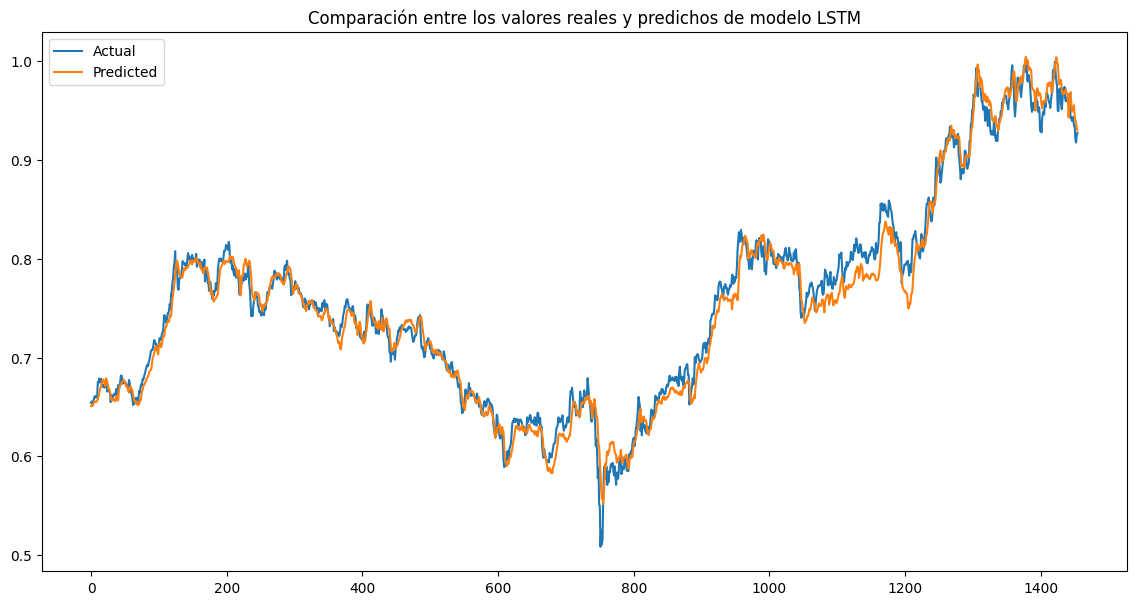

In [150]:
import matplotlib.pyplot as plt
# Predicciones en el conjunto de prueba
y_pred_test_lstm = model_lstm .predict(X_test).reshape(-1)

# Visualización de resultados
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual')
plt.plot(y_pred_test_lstm, label='Predicted')
plt.title('Comparación entre los valores reales y predichos de modelo LSTM')
plt.legend()
plt.show()

## 3.6 Cross Validation LSTM

In [151]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Fijar semillas para reproducibilidad
np.random.seed(0)
tf.random.set_seed(0)

# Asegúrate de que X e y estén definidos antes de este punto y no cambien.
# Por ejemplo:
# X, y = some_preprocessed_data_function()

# Guarda una copia de X e y para verificar si cambian
X_initial = X.copy()
y_initial = y.copy()

# Creando el objeto TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando listas para almacenar las métricas
losses, maes, mses, r2s = [], [], [], []
histories = []

# Entrenamiento y evaluación del modelo utilizando validación cruzada
for train_index, test_index in tscv.split(X):
    # Verifica que X e y no cambien
    assert np.array_equal(X, X_initial), "X ha cambiado durante la ejecución"
    assert np.array_equal(y, y_initial), "y ha cambiado durante la ejecución"

    # Dividiendo X en conjuntos de entrenamiento y prueba usando los índices generados
    X_train_cv, X_test_cv = X[train_index], X[test_index]
    # Dividiendo y en conjuntos de entrenamiento y prueba usando los mismos índices
    y_train_cv, y_test_cv = y[train_index], y[test_index]

    # Define el modelo LSTM
    model_lstm = Sequential([
        LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
        Dense(1)
    ])

    # Compila el modelo
    model_lstm.compile(optimizer='adam', loss='mse')

    # Entrena el modelo y guarda el historial
    history = model_lstm.fit(X_train_cv, y_train_cv, epochs=20, verbose=1, validation_data=(X_test_cv, y_test_cv))  # Puedes ajustar el número de épocas según sea necesario
    histories.append(history)

    # Evalúa el modelo en el conjunto de prueba
    loss = model_lstm.evaluate(X_test_cv, y_test_cv, verbose=0)
    y_pred_cv = model_lstm.predict(X_test_cv).reshape(-1)
    mae = mean_absolute_error(y_test_cv, y_pred_cv)
    mse = mean_squared_error(y_test_cv, y_pred_cv)
    r2 = r2_score(y_test_cv, y_pred_cv)

    # Guardar las métricas del fold actual
    losses.append(loss)
    maes.append(mae)
    mses.append(mse)
    r2s.append(r2)

# Calcular las métricas promedio
loss_avg = np.mean(losses)
mae_avg = np.mean(maes)
mse_avg = np.mean(mses)
r2_avg = np.mean(r2s)

print(f'Average Loss: {loss_avg}')
print(f'Average MAE: {mae_avg}')
print(f'Average MSE: {mse_avg}')
print(f'Average R2: {r2_avg}')


Epoch 1/20
38/38 [==============================] - 2s 25ms/step - loss: 0.0016 - val_loss: 0.0058
Epoch 2/20
38/38 [==============================] - 1s 18ms/step - loss: 5.0475e-04 - val_loss: 0.0019
Epoch 3/20
38/38 [==============================] - 1s 18ms/step - loss: 1.9952e-04 - val_loss: 0.0023
Epoch 4/20
38/38 [==============================] - 1s 18ms/step - loss: 1.3887e-04 - val_loss: 0.0021
Epoch 5/20
38/38 [==============================] - 1s 21ms/step - loss: 1.0235e-04 - val_loss: 0.0029
Epoch 6/20
38/38 [==============================] - 1s 28ms/step - loss: 9.9473e-05 - val_loss: 0.0010
Epoch 7/20
38/38 [==============================] - 1s 27ms/step - loss: 8.8426e-05 - val_loss: 0.0011
Epoch 8/20
38/38 [==============================] - 1s 28ms/step - loss: 9.3381e-05 - val_loss: 9.9930e-04
Epoch 9/20
38/38 [==============================] - 1s 26ms/step - loss: 6.3160e-05 - val_loss: 7.9517e-04
Epoch 10/20
38/38 [==============================] - 1s 22ms/step - l

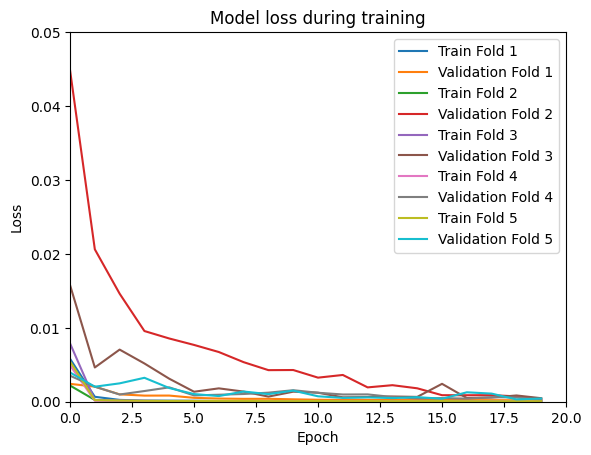

In [ ]:
# Graficar el historial de entrenamiento
for i, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f'Train Fold {i+1}')
    plt.plot(history.history['val_loss'], label=f'Validation Fold {i+1}')

plt.title('Model loss during training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0, 0.05)  # Ajustar los límites del eje Y
plt.xlim(0, 20)  # Ajustar los límites del eje X
plt.legend(loc='upper right')
plt.show()

## 3.7 Entrenamiento Red Neuronal Recurrente RNN

In [152]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Define el modelo RNN
model_rnn = Sequential([
    SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Compila el modelo
model_rnn.compile(optimizer='adam', loss='mse')

# Entrena el modelo
model_rnn.fit(X_train, y_train, epochs=10, verbose=1)

# Evaluación del modelo
loss = model_rnn.evaluate(X_test, y_test, verbose=1)

Epoch 1/10
182/182 [==============================] - 3s 9ms/step - loss: 0.0089
Epoch 2/10
182/182 [==============================] - 1s 7ms/step - loss: 8.5418e-04
Epoch 3/10
182/182 [==============================] - 1s 7ms/step - loss: 4.8203e-04
Epoch 4/10
182/182 [==============================] - 1s 7ms/step - loss: 3.4379e-04
Epoch 5/10
182/182 [==============================] - 1s 7ms/step - loss: 2.7417e-04
Epoch 6/10
182/182 [==============================] - 1s 7ms/step - loss: 2.3950e-04
Epoch 7/10
182/182 [==============================] - 1s 7ms/step - loss: 2.0765e-04
Epoch 8/10
182/182 [==============================] - 2s 9ms/step - loss: 1.8285e-04
Epoch 9/10
182/182 [==============================] - 2s 11ms/step - loss: 1.7937e-04
Epoch 10/10
46/46 [==============================] - 0s 3ms/step - loss: 0.0013


In [153]:
# Predicciones en el conjunto de entrenamiento
y_pred_train_rnn = model_rnn.predict(X_train).reshape(-1)

# Calcular métricas de evaluación para el conjunto de entrenamiento
mse_train_rnn = mean_squared_error(y_train, y_pred_train_rnn)
mae_train_rnn = mean_absolute_error(y_train, y_pred_train_rnn)
r2_train_rnn = r2_score(y_train, y_pred_train_rnn)

# Imprimir métricas para el conjunto de entrenamiento
print("RNN (Entrenamiento):")
print("MSE:", mse_train_rnn)
print("MAE:", mae_train_rnn)
print("R2:", r2_train_rnn)

# Predicciones en el conjunto de prueba
y_pred_test_rnn= model_rnn.predict(X_test).reshape(-1)

# Calcular métricas de evaluación para el conjunto de prueba
mse_test_rnn = mean_squared_error(y_test, y_pred_test_rnn)
mae_test_rnn = mean_absolute_error(y_test, y_pred_test_rnn)
r2_test_rnn = r2_score(y_test, y_pred_test_rnn)

# Imprimir métricas para el conjunto de prueba
print("\nRNN (Prueba):")
print("MSE:", mse_test_rnn)
print("MAE:", mae_test_rnn)
print("R2:", r2_test_rnn)

182/182 [==============================] - 1s 4ms/step
RNN (Entrenamiento):
MSE: 0.00013050963187913472
MAE: 0.008558294176757698
R2: 0.9979604281190383
46/46 [==============================] - 0s 5ms/step

RNN (Prueba):
MSE: 0.0013231040386813282
MAE: 0.030765945843271244
R2: 0.8736754350786565


46/46 [==============================] - 0s 7ms/step


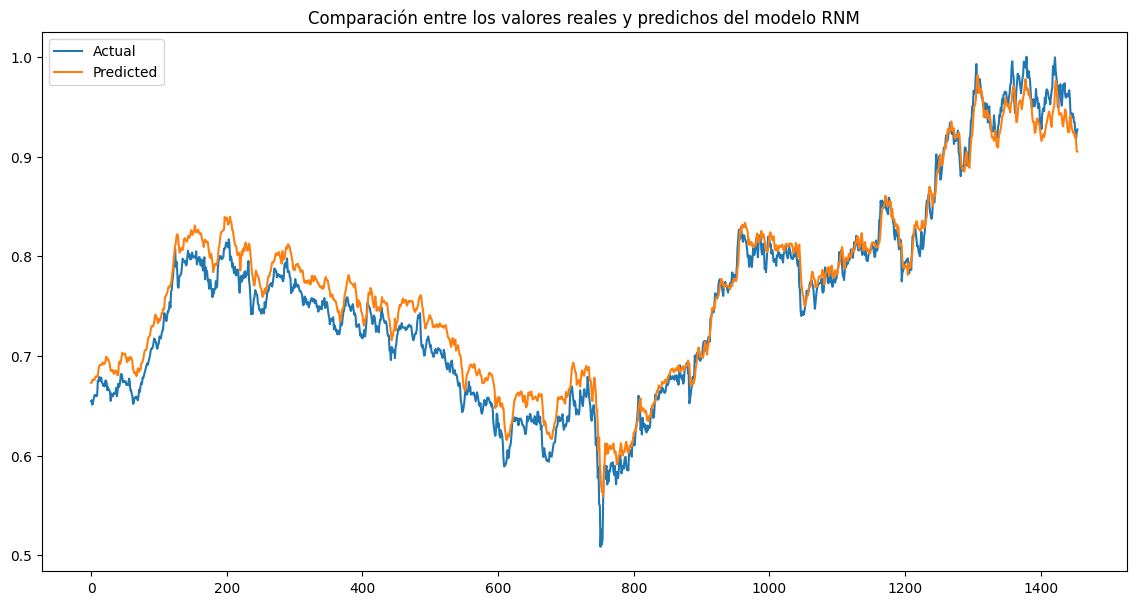

In [154]:
y_pred_test_rnn = model_lstm .predict(X_test).reshape(-1)

# Visualización de resultados
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual')
plt.plot(y_pred_test_rnn, label='Predicted')
plt.title('Comparación entre los valores reales y predichos del modelo RNM')
plt.legend()
plt.show()

## 3.8 Cross Validation Red Neuronal Recurrente RNN

In [155]:
# Fijar semillas para reproducibilidad
np.random.seed(0)
tf.random.set_seed(0)

# Asegúrate de que X e y estén definidos antes de este punto y no cambien.
# Por ejemplo:
# X, y = some_preprocessed_data_function()

# Guarda una copia de X e y para verificar si cambian
X_initial = X.copy()
y_initial = y.copy()

# Creando el objeto TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando listas para almacenar las métricas
losses, maes, mses, r2s = [], [], [], []
histories = []

# Entrenamiento y evaluación del modelo utilizando validación cruzada
for train_index, test_index in tscv.split(X):
    # Verifica que X e y no cambien
    assert np.array_equal(X, X_initial), "X ha cambiado durante la ejecución"
    assert np.array_equal(y, y_initial), "y ha cambiado durante la ejecución"

    # Dividiendo X en conjuntos de entrenamiento y prueba usando los índices generados
    X_train_cv, X_test_cv = X[train_index], X[test_index]
    # Dividiendo y en conjuntos de entrenamiento y prueba usando los mismos índices
    y_train_cv, y_test_cv = y[train_index], y[test_index]


    # Define el modelo RNN
    model_rnn = Sequential([
    SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
    ])

    # Compila el modelo
    model_rnn.compile(optimizer='adam', loss='mse')

    # Entrena el modelo
    model_rnn.fit(X_train, y_train, epochs=10, verbose=1)

    # Entrena el modelo y guarda el historial
    history = model_rnn.fit(X_train_cv, y_train_cv, epochs=20, verbose=1, validation_data=(X_test_cv, y_test_cv))  # Puedes ajustar el número de épocas según sea necesario
    histories.append(history)

    # Evalúa el modelo en el conjunto de prueba
    loss = model_rnn.evaluate(X_test_cv, y_test_cv, verbose=0)
    y_pred_cv = model_rnn.predict(X_test_cv).reshape(-1)
    mae = mean_absolute_error(y_test_cv, y_pred_cv)
    mse = mean_squared_error(y_test_cv, y_pred_cv)
    r2 = r2_score(y_test_cv, y_pred_cv)

    # Guardar las métricas del fold actual
    losses.append(loss)
    maes.append(mae)
    mses.append(mse)
    r2s.append(r2)

# Calcular las métricas promedio
loss_avg = np.mean(losses)
mae_avg = np.mean(maes)
mse_avg = np.mean(mses)
r2_avg = np.mean(r2s)

print(f'Average Loss: {loss_avg}')
print(f'Average MAE: {mae_avg}')
print(f'Average MSE: {mse_avg}')
print(f'Average R2: {r2_avg}')


Epoch 1/10
182/182 [==============================] - 3s 8ms/step - loss: 0.0271
Epoch 2/10
182/182 [==============================] - 1s 7ms/step - loss: 6.4483e-04
Epoch 3/10
182/182 [==============================] - 1s 7ms/step - loss: 4.7416e-04
Epoch 4/10
182/182 [==============================] - 1s 7ms/step - loss: 3.8186e-04
Epoch 5/10
182/182 [==============================] - 1s 7ms/step - loss: 3.5518e-04
Epoch 6/10
182/182 [==============================] - 1s 7ms/step - loss: 2.7513e-04
Epoch 7/10
182/182 [==============================] - 1s 7ms/step - loss: 2.6857e-04
Epoch 8/10
182/182 [==============================] - 1s 7ms/step - loss: 2.3189e-04
Epoch 9/10
182/182 [==============================] - 2s 10ms/step - loss: 2.1369e-04
Epoch 10/10
182/182 [==============================] - 2s 11ms/step - loss: 1.9728e-04
Epoch 1/20
38/38 [==============================] - 1s 17ms/step - loss: 1.3658e-04 - val_loss: 1.1217e-04
Epoch 2/20
38/38 [==========================

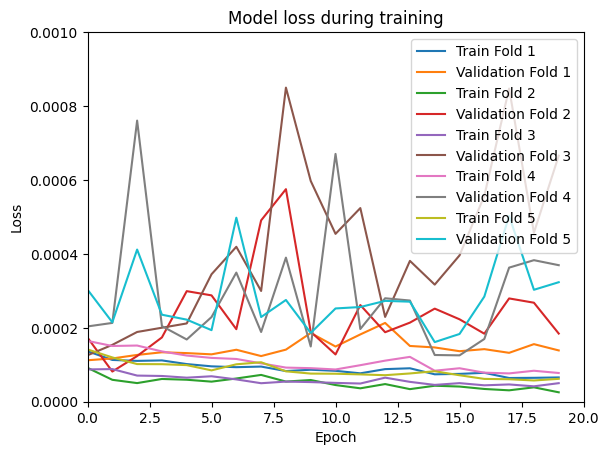

In [158]:
# Graficar el historial de entrenamiento
for i, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f'Train Fold {i+1}')
    plt.plot(history.history['val_loss'], label=f'Validation Fold {i+1}')

plt.title('Model loss during training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0, 0.001)  # Ajustar los límites del eje Y
plt.xlim(0, 20)  # Ajustar los límites del eje X
plt.legend(loc='upper right')
plt.show()

## 3.8 Entrenamiento de Red Neuronal Unidad Recurrente Cerrada GRU

In [159]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense


# Define el modelo GRU
model_gru = Sequential([
    GRU(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Compila el modelo
model_gru.compile(optimizer='adam', loss='mse')

# Entrena el modelo
model_gru.fit(X_train, y_train, epochs=10, verbose=1)

# Evaluación del modelo
loss = model_gru.evaluate(X_test, y_test, verbose=1)

Epoch 1/10
182/182 [==============================] - 6s 17ms/step - loss: 0.0030
Epoch 2/10
182/182 [==============================] - 2s 12ms/step - loss: 1.4926e-04
Epoch 3/10
182/182 [==============================] - 2s 12ms/step - loss: 9.6512e-05
Epoch 4/10
182/182 [==============================] - 2s 12ms/step - loss: 7.7241e-05
Epoch 5/10
182/182 [==============================] - 2s 13ms/step - loss: 7.4825e-05
Epoch 6/10
182/182 [==============================] - 4s 21ms/step - loss: 7.7483e-05
Epoch 7/10
182/182 [==============================] - 2s 13ms/step - loss: 5.9923e-05
Epoch 8/10
182/182 [==============================] - 2s 12ms/step - loss: 6.6913e-05
Epoch 9/10
182/182 [==============================] - 2s 12ms/step - loss: 6.1948e-05
Epoch 10/10
46/46 [==============================] - 0s 5ms/step - loss: 1.8361e-04


In [161]:
 model_gru.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50)                12450     
                                                                 
 dense_24 (Dense)            (None, 1)                 51        
                                                                 
Total params: 12501 (48.83 KB)
Trainable params: 12501 (48.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [160]:
# Predicciones en el conjunto de entrenamiento
y_pred_train_gru = model_gru.predict(X_train).reshape(-1)

# Calcular métricas de evaluación para el conjunto de entrenamiento
mse_train_gru = mean_squared_error(y_train, y_pred_train_gru)
mae_train_gru = mean_absolute_error(y_train, y_pred_train_gru)
r2_train_gru = r2_score(y_train, y_pred_train_gru)

# Imprimir métricas para el conjunto de entrenamiento
print("GRU (Entrenamiento):")
print("MSE:", mse_train_gru)
print("MAE:", mae_train_gru)
print("R2:", r2_train_gru)

# Predicciones en el conjunto de prueba
y_pred_test_gru = model_gru.predict(X_test).reshape(-1)

# Calcular métricas de evaluación para el conjunto de prueba
mse_test_gru = mean_squared_error(y_test, y_pred_test_gru)
mae_test_gru = mean_absolute_error(y_test, y_pred_test_gru)
r2_test_gru = r2_score(y_test, y_pred_test_gru)

# Imprimir métricas para el conjunto de prueba
print("\nGRU (Prueba):")
print("MSE:", mse_test_gru)
print("MAE:", mae_test_gru)
print("R2:", r2_test_gru)

182/182 [==============================] - 1s 6ms/step
GRU (Entrenamiento):
MSE: 4.6735924923382796e-05
MAE: 0.004821987125513818
R2: 0.9992696226559528
46/46 [==============================] - 0s 7ms/step

GRU (Prueba):
MSE: 0.00018361502035123834
MAE: 0.010244010523429142
R2: 0.9824691884532292


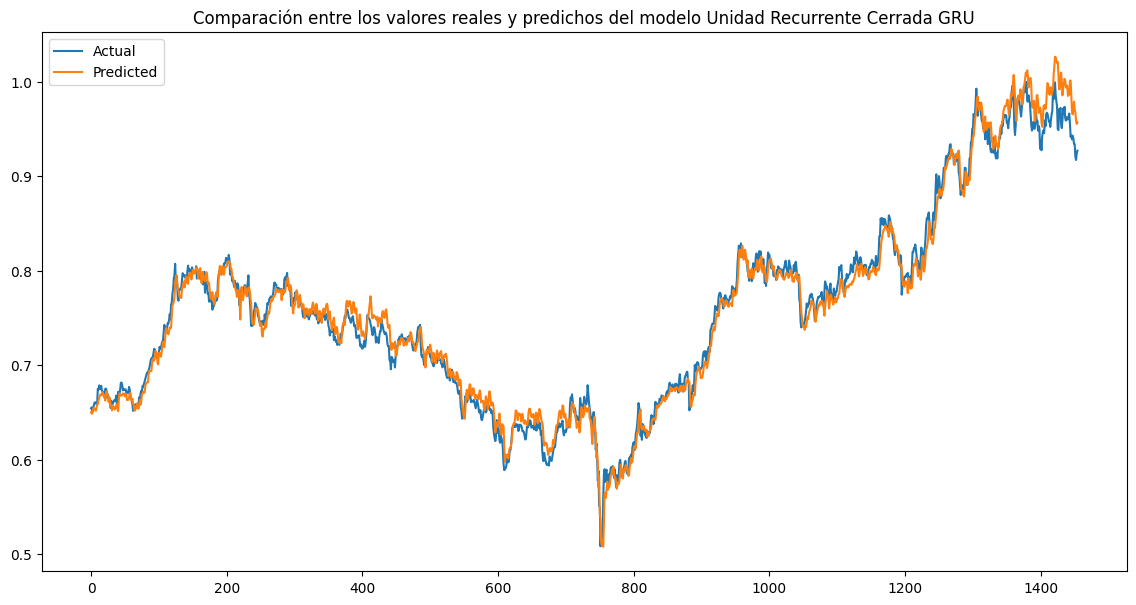

In [162]:
# Visualización de resultados
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual')
plt.plot(y_pred_test_gru, label='Predicted')
plt.title('Comparación entre los valores reales y predichos del modelo Unidad Recurrente Cerrada GRU')
plt.legend()
plt.show()

## 3.9 Cross Validation Red Neuronal Unidad Recurrente Cerrada GRU


In [163]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Fijar semillas para reproducibilidad
np.random.seed(0)
tf.random.set_seed(0)

# Asegúrate de que X e y estén definidos antes de este punto y no cambien.
# Por ejemplo:
# X, y = some_preprocessed_data_function()

# Guarda una copia de X e y para verificar si cambian
X_initial = X.copy()
y_initial = y.copy()

# Creando el objeto TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando listas para almacenar las métricas
losses, maes, mses, r2s = [], [], [], []
histories = []

# Entrenamiento y evaluación del modelo utilizando validación cruzada
for train_index, test_index in tscv.split(X):
    # Verifica que X e y no cambien
    assert np.array_equal(X, X_initial), "X ha cambiado durante la ejecución"
    assert np.array_equal(y, y_initial), "y ha cambiado durante la ejecución"

    # Dividiendo X en conjuntos de entrenamiento y prueba usando los índices generados
    X_train_cv, X_test_cv = X[train_index], X[test_index]
    # Dividiendo y en conjuntos de entrenamiento y prueba usando los mismos índices
    y_train_cv, y_test_cv = y[train_index], y[test_index]

    # Define el modelo GRU
    model_gru = Sequential([
        GRU(50, activation='relu', input_shape=(X_train_cv.shape[1], X_train_cv.shape[2])),
        Dense(1)
    ])

    # Compila el modelo
    model_gru.compile(optimizer='adam', loss='mse')

    # Entrena el modelo y guarda el historial
    history = model_gru.fit(X_train_cv, y_train_cv, epochs=20, verbose=1, validation_data=(X_test_cv, y_test_cv))  # Puedes ajustar el número de épocas según sea necesario
    histories.append(history)

    # Evalúa el modelo en el conjunto de prueba
    loss = model_gru.evaluate(X_test_cv, y_test_cv, verbose=0)
    y_pred_cv = model_gru.predict(X_test_cv).reshape(-1)
    mae = mean_absolute_error(y_test_cv, y_pred_cv)
    mse = mean_squared_error(y_test_cv, y_pred_cv)
    r2 = r2_score(y_test_cv, y_pred_cv)

    # Guardar las métricas del fold actual
    losses.append(loss)
    maes.append(mae)
    mses.append(mse)
    r2s.append(r2)

# Calcular las métricas promedio
loss_avg = np.mean(losses)
mae_avg = np.mean(maes)
mse_avg = np.mean(mses)
r2_avg = np.mean(r2s)

print(f'Average Loss: {loss_avg}')
print(f'Average MAE: {mae_avg}')
print(f'Average MSE: {mse_avg}')
print(f'Average R2: {r2_avg}')


Epoch 1/20
38/38 [==============================] - 6s 49ms/step - loss: 0.0044 - val_loss: 0.0109
Epoch 2/20
38/38 [==============================] - 1s 18ms/step - loss: 0.0011 - val_loss: 0.0063
Epoch 3/20
38/38 [==============================] - 1s 21ms/step - loss: 5.3771e-04 - val_loss: 0.0033
Epoch 4/20
38/38 [==============================] - 1s 17ms/step - loss: 2.7518e-04 - val_loss: 0.0013
Epoch 5/20
38/38 [==============================] - 1s 17ms/step - loss: 1.7302e-04 - val_loss: 9.7930e-04
Epoch 6/20
38/38 [==============================] - 1s 18ms/step - loss: 1.3993e-04 - val_loss: 6.6765e-04
Epoch 7/20
38/38 [==============================] - 1s 18ms/step - loss: 8.4727e-05 - val_loss: 6.0342e-04
Epoch 8/20
38/38 [==============================] - 1s 17ms/step - loss: 8.6996e-05 - val_loss: 6.0962e-04
Epoch 9/20
38/38 [==============================] - 1s 17ms/step - loss: 6.1854e-05 - val_loss: 5.1792e-04
Epoch 10/20
38/38 [==============================] - 1s 17ms/

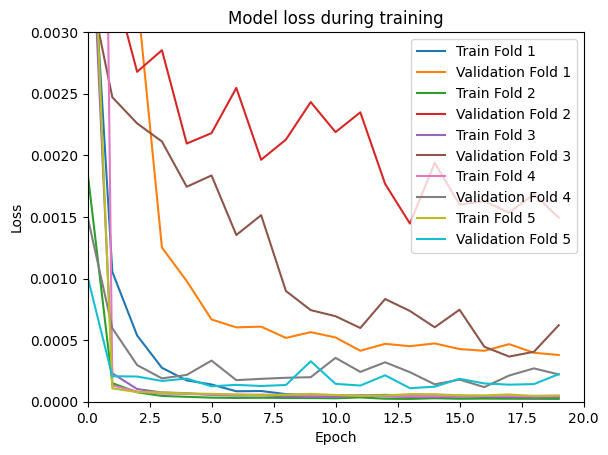

In [165]:
# Graficar el historial de entrenamiento
for i, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f'Train Fold {i+1}')
    plt.plot(history.history['val_loss'], label=f'Validation Fold {i+1}')

plt.title('Model loss during training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0, 0.003)  # Ajustar los límites del eje Y
plt.xlim(0, 20)  # Ajustar los límites del eje X
plt.legend(loc='upper right')
plt.show()

# 4. Forecasting SQM para el 2023

In [166]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Define el modelo RNN
model_rnn = Sequential([
    SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Compila el modelo
model_rnn.compile(optimizer='adam', loss='mse')

# Entrena el modelo
model_rnn.fit(X_train, y_train, epochs=10, verbose=1)

# Evaluación del modelo
loss = model_rnn.evaluate(X_test, y_test, verbose=1)

Epoch 1/10
182/182 [==============================] - 4s 13ms/step - loss: 0.0049
Epoch 2/10
182/182 [==============================] - 2s 13ms/step - loss: 8.3185e-04
Epoch 3/10
182/182 [==============================] - 2s 11ms/step - loss: 5.5737e-04
Epoch 4/10
182/182 [==============================] - 2s 10ms/step - loss: 4.6299e-04
Epoch 5/10
182/182 [==============================] - 1s 7ms/step - loss: 3.3983e-04
Epoch 6/10
182/182 [==============================] - 1s 7ms/step - loss: 2.5151e-04
Epoch 7/10
182/182 [==============================] - 1s 7ms/step - loss: 1.8248e-04
Epoch 8/10
182/182 [==============================] - 1s 7ms/step - loss: 1.8158e-04
Epoch 9/10
182/182 [==============================] - 1s 7ms/step - loss: 1.4186e-04
Epoch 10/10
46/46 [==============================] - 0s 4ms/step - loss: 3.9933e-04


In [169]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Fijar semillas para reproducibilidad
np.random.seed(0)
tf.random.set_seed(0)

# Asegúrate de que X e y estén definidos antes de este punto y no cambien.
# Por ejemplo:
# X, y = some_preprocessed_data_function()

# Guarda una copia de X e y para verificar si cambian
X_initial = X.copy()
y_initial = y.copy()

# Creando el objeto TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando listas para almacenar las métricas
losses, maes, mses, r2s = [], [], [], []
histories = []

# Inicializando un modelo para promediar los pesos
average_model = Sequential([
    SimpleRNN(50, activation='relu', input_shape=(X.shape[1], X.shape[2])),
    Dense(1)
])

# Compilar el modelo promediado
average_model.compile(optimizer='adam', loss='mse')

# Entrenamiento y evaluación del modelo utilizando validación cruzada
for train_index, test_index in tscv.split(X):
    # Verifica que X e y no cambien
    assert np.array_equal(X, X_initial), "X ha cambiado durante la ejecución"
    assert np.array_equal(y, y_initial), "y ha cambiado durante la ejecución"

    # Dividiendo X en conjuntos de entrenamiento y prueba usando los índices generados
    X_train_cv, X_test_cv = X[train_index], X[test_index]
    # Dividiendo y en conjuntos de entrenamiento y prueba usando los mismos índices
    y_train_cv, y_test_cv = y[train_index], y[test_index]

    # Define el modelo RNN
    model_rnn = Sequential([
        SimpleRNN(50, activation='relu', input_shape=(X_train_cv.shape[1], X_train_cv.shape[2])),
        Dense(1)
    ])

    # Compila el modelo
    model_rnn.compile(optimizer='adam', loss='mse')

    # Entrena el modelo y guarda el historial
    history = model_rnn.fit(X_train_cv, y_train_cv, epochs=20, verbose=1, validation_data=(X_test_cv, y_test_cv))  # Puedes ajustar el número de épocas según sea necesario
    histories.append(history)

    # Evalúa el modelo en el conjunto de prueba
    loss = model_rnn.evaluate(X_test_cv, y_test_cv, verbose=0)
    y_pred_cv = model_rnn.predict(X_test_cv).reshape(-1)
    mae = mean_absolute_error(y_test_cv, y_pred_cv)
    mse = mean_squared_error(y_test_cv, y_pred_cv)
    r2 = r2_score(y_test_cv, y_pred_cv)

    # Guardar las métricas del fold actual
    losses.append(loss)
    maes.append(mae)
    mses.append(mse)
    r2s.append(r2)

    # Promediar los pesos del modelo actual con el modelo promediado
    for layer, layer_avg in zip(model_rnn.layers, average_model.layers):
        layer_avg.set_weights([w + w_avg for w, w_avg in zip(layer.get_weights(), layer_avg.get_weights())])

# Calcular las métricas promedio
loss_avg = np.mean(losses)
mae_avg = np.mean(maes)
mse_avg = np.mean(mses)
r2_avg = np.mean(r2s)

print(f'Average Loss: {loss_avg}')
print(f'Average MAE: {mae_avg}')
print(f'Average MSE: {mse_avg}')
print(f'Average R2: {r2_avg}')

# Dividir los pesos promediados por el número de folds para obtener el promedio real
for layer_avg in average_model.layers:
    layer_avg.set_weights([w / len(tscv.split(X)) for w in layer_avg.get_weights()])

# Entrenar el modelo promediado con todos los datos
average_model.fit(X, y, epochs=20, verbose=1)  # Ajusta el número de épocas según sea necesario



Epoch 1/20
38/38 [==============================] - 7s 45ms/step - loss: 0.0065 - val_loss: 0.0101
Epoch 2/20
38/38 [==============================] - 1s 23ms/step - loss: 0.0014 - val_loss: 0.0045
Epoch 3/20
38/38 [==============================] - 1s 23ms/step - loss: 8.9073e-04 - val_loss: 0.0033
Epoch 4/20
38/38 [==============================] - 1s 26ms/step - loss: 6.1301e-04 - val_loss: 0.0024
Epoch 5/20
38/38 [==============================] - 2s 45ms/step - loss: 4.4327e-04 - val_loss: 0.0023
Epoch 6/20
38/38 [==============================] - 1s 33ms/step - loss: 3.2872e-04 - val_loss: 0.0022
Epoch 7/20
38/38 [==============================] - 1s 28ms/step - loss: 2.7828e-04 - val_loss: 0.0024
Epoch 8/20
38/38 [==============================] - 0s 11ms/step - loss: 2.7050e-04 - val_loss: 0.0025
Epoch 9/20
38/38 [==============================] - 0s 10ms/step - loss: 2.2018e-04 - val_loss: 0.0028
Epoch 10/20
38/38 [==============================] - 0s 11ms/step - loss: 1.7932e

TypeError: object of type 'generator' has no len()